In [1]:
# Run only once to install the dependencies
import sys

!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

     |████████████████████████████████| 235kB 3.3MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
from networkx import Graph as NXGraph

In [3]:
tkgs = {'2013': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2013/merged_kg.ttl',
        '2014': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2014/merged_kg.ttl',
        '2015': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2015/merged_kg.ttl',
        '2016': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2016/merged_kg.ttl',
        '2017': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2017/merged_kg.ttl',
        '2018': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2018/merged_kg.ttl',
        '2019': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2019/merged_kg.ttl'}

nxgs = {}
for tkg in tkgs.keys():
    rdfg = RDFGraph()
    rdfg.parse(tkgs[tkg], format='turtle')
    print('Loaded TKG {}'.format(tkg))
    nxg = rdflib_to_networkx_graph(rdfg)
    print(' - Converted to complex network: {} nodes and {} edges'.format(nxg.number_of_nodes(), nxg.number_of_edges()))
    print(' -- Network density: {}'.format(nx.density(nxg)))
    nxgs[tkg] = nxg

Loaded TKG 2013
 - Converted to complex network: 7719 nodes and 10519 edges
 -- Network density: 0.00035313326968944585
Loaded TKG 2014
 - Converted to complex network: 7225 nodes and 9767 edges
 -- Network density: 0.000374261879854541
Loaded TKG 2015
 - Converted to complex network: 6925 nodes and 9352 edges
 -- Network density: 0.0003900835684804802
Loaded TKG 2016
 - Converted to complex network: 6506 nodes and 8843 edges
 -- Network density: 0.00041789604487361395
Loaded TKG 2017
 - Converted to complex network: 7921 nodes and 10779 edges
 -- Network density: 0.0003436396537015146
Loaded TKG 2018
 - Converted to complex network: 7445 nodes and 10270 edges
 -- Network density: 0.0003706204446074004
Loaded TKG 2019
 - Converted to complex network: 8261 nodes and 11495 edges
 -- Network density: 0.00033691961968384366


In [4]:
def get_centrality(method=nx.degree_centrality, top_limit=20):
    nkgs_degrees = {}
    nkg_index = 0
    overall_top_degrees = {}
    for nxg in nxgs.keys():
        top_keys = []
        top_values = []
        links = {}

        dc = method(nxgs[nxg])
        degrees = dict()
        for key, value in dc.items():
            neighbors = [n for n in nxgs[nxg].neighbors(key)]
            ontology_links = [m for m in neighbors if 'cso' in m]
            if len(ontology_links) > 0:
                if len(ontology_links) > 1: # Just enforcing ...
                    print('Warning: multiple links for {}'.format(key))
                    print(ontology_links)

                links[key] = ontology_links[0]
                if not key in nkgs_degrees.keys():
                    lst = [0] * len(nxgs)
                else:
                    lst = nkgs_degrees[key]
                lst[nkg_index] = value
                nkgs_degrees[key] = lst

                top_keys.append(key)
                top_values.append(value)
        
        nkg_index += 1

        n = top_limit
        max_indexes = sorted(range(len(top_values)), key = lambda sub: top_values[sub])[-n:]
        print('Top {} values for {}'.format(n, nxg))
        for i in reversed(range(len(max_indexes))):
            print(' - {}: {} -- ref: {}'.format(top_keys[max_indexes[i]], top_values[max_indexes[i]], links[top_keys[max_indexes[i]]]))
            overall_top_degrees[top_keys[max_indexes[i]]] = nkgs_degrees[top_keys[max_indexes[i]]]

    return nkgs_degrees, overall_top_degrees

def plot(degrees, indexes, title=None, enlarge=False):
    yrs_degrees = np.array(list(degrees.values()))
    idx = np.arange(len(yrs_degrees[:,0]))
    if enlarge:
        fig = plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')
    else:
        fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    colours=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w'] # add more if required!
    bar_width = 0.25
    for i in indexes:
        ax.bar(idx + i*bar_width, yrs_degrees[:,i], color=colours[i], width = bar_width, align='edge')

    ax.set_xticks(idx)
    if len(indexes) > 1:
        ax.legend(list(tkgs.keys())[:len(indexes)])
    if not title is None:
        ax.set_title(title)
    ax.set_xlabel('Concept')
    ax.set_ylabel('Centrality')

def plot_combined(degrees, title=None, enlarge=False):
    plot(degrees, range(len(tkgs.keys())), title, enlarge)

def plot_all(degrees, title=None):
    for i in range(len(tkgs.keys())):
        plot(degrees, [i], title, enlarge=True)
    plot_combined(degrees, title, enlarge=True)

def draw_subgraph(year, node, neighborhood_level=1, verbose=False):
    nodes = {node}
    for i in range(0, neighborhood_level):
        neighbors = set()
        for key in nodes:
            neighbors.update(set([n for n in nxgs[year].neighbors(key) if not n in nodes]))
        nodes.update(neighbors)

    if neighborhood_level == 1:
        print('Subgraph for immediate neighbors of {}, in {}:'.format(node, year))
        print('- # of immediate neighbors: {}'.format(len(nodes)-1))
    else:
        print('Subgraph for level {} neighbors of {}, in {}:'.format(neighborhood_level, node, year))

    if verbose:
        print(nodes)

    subgraph = nxgs[year].subgraph(nodes)

    color_map = []
    for n in subgraph.nodes:
        if n == node:
            color_map.append('r')
        elif subgraph.has_edge(n, node):
            color_map.append('g')
        else: # non-immediate neighbors.
            sp = nx.shortest_path_length(subgraph, node, n)
            if sp == 2:
                color_map.append('b')
            else: # not differentiating above 2
                color_map.append('y')

    mapping = {}
    for n in nodes:
        if 'cso' in n:
            mapping[n] = 'cso:{}'.format(n.split('/')[-1])
        elif 'local' in n:
            mapping[n] = ':{}'.format(n.split('#')[-1])
        else: # literal
            mapping[n] = '"{}"'.format(n)
    subgraph = nx.relabel_nodes(subgraph, mapping)

    pos = nx.spring_layout(subgraph, scale=1)
    edge_labels = nx.get_edge_attributes(subgraph, 'r')

    plt.figure(year)
    #nx.draw_networkx_edge_labels(subgraph, pos, labels=edge_labels)
    nx.draw(subgraph, pos, node_color=color_map, with_labels=(neighborhood_level<2))
    plt.show()
    

In [5]:
deg_centrality, top_deg_centrality = get_centrality(nx.degree_centrality)

Top 20 values for 2013
 - http://local/local.owl#ontology: 0.005441824306815237 -- ref: https://cso.kmi.open.ac.uk/topics/ontology
 - http://local/local.owl#semantic: 0.003109613889608707 -- ref: https://cso.kmi.open.ac.uk/topics/semantics
 - http://local/local.owl#semantic_web: 0.0022026431718061676 -- ref: https://cso.kmi.open.ac.uk/topics/semantic_web
 - http://local/local.owl#owl: 0.001813941435605079 -- ref: https://cso.kmi.open.ac.uk/topics/owl
 - http://local/local.owl#inference: 0.001813941435605079 -- ref: https://cso.kmi.open.ac.uk/topics/inference
 - http://local/local.owl#dbpedia: 0.0016843741902047163 -- ref: https://cso.kmi.open.ac.uk/topics/dbpedia
 - http://local/local.owl#rdf: 0.0016843741902047163 -- ref: https://cso.kmi.open.ac.uk/topics/rdf
 - http://local/local.owl#semantics: 0.0015548069448043534 -- ref: https://cso.kmi.open.ac.uk/topics/semantics
 - http://local/local.owl#engine: 0.0014252396994039907 -- ref: https://cso.kmi.open.ac.uk/topics/engine
 - http://loc

DEGREE CENTRALITY


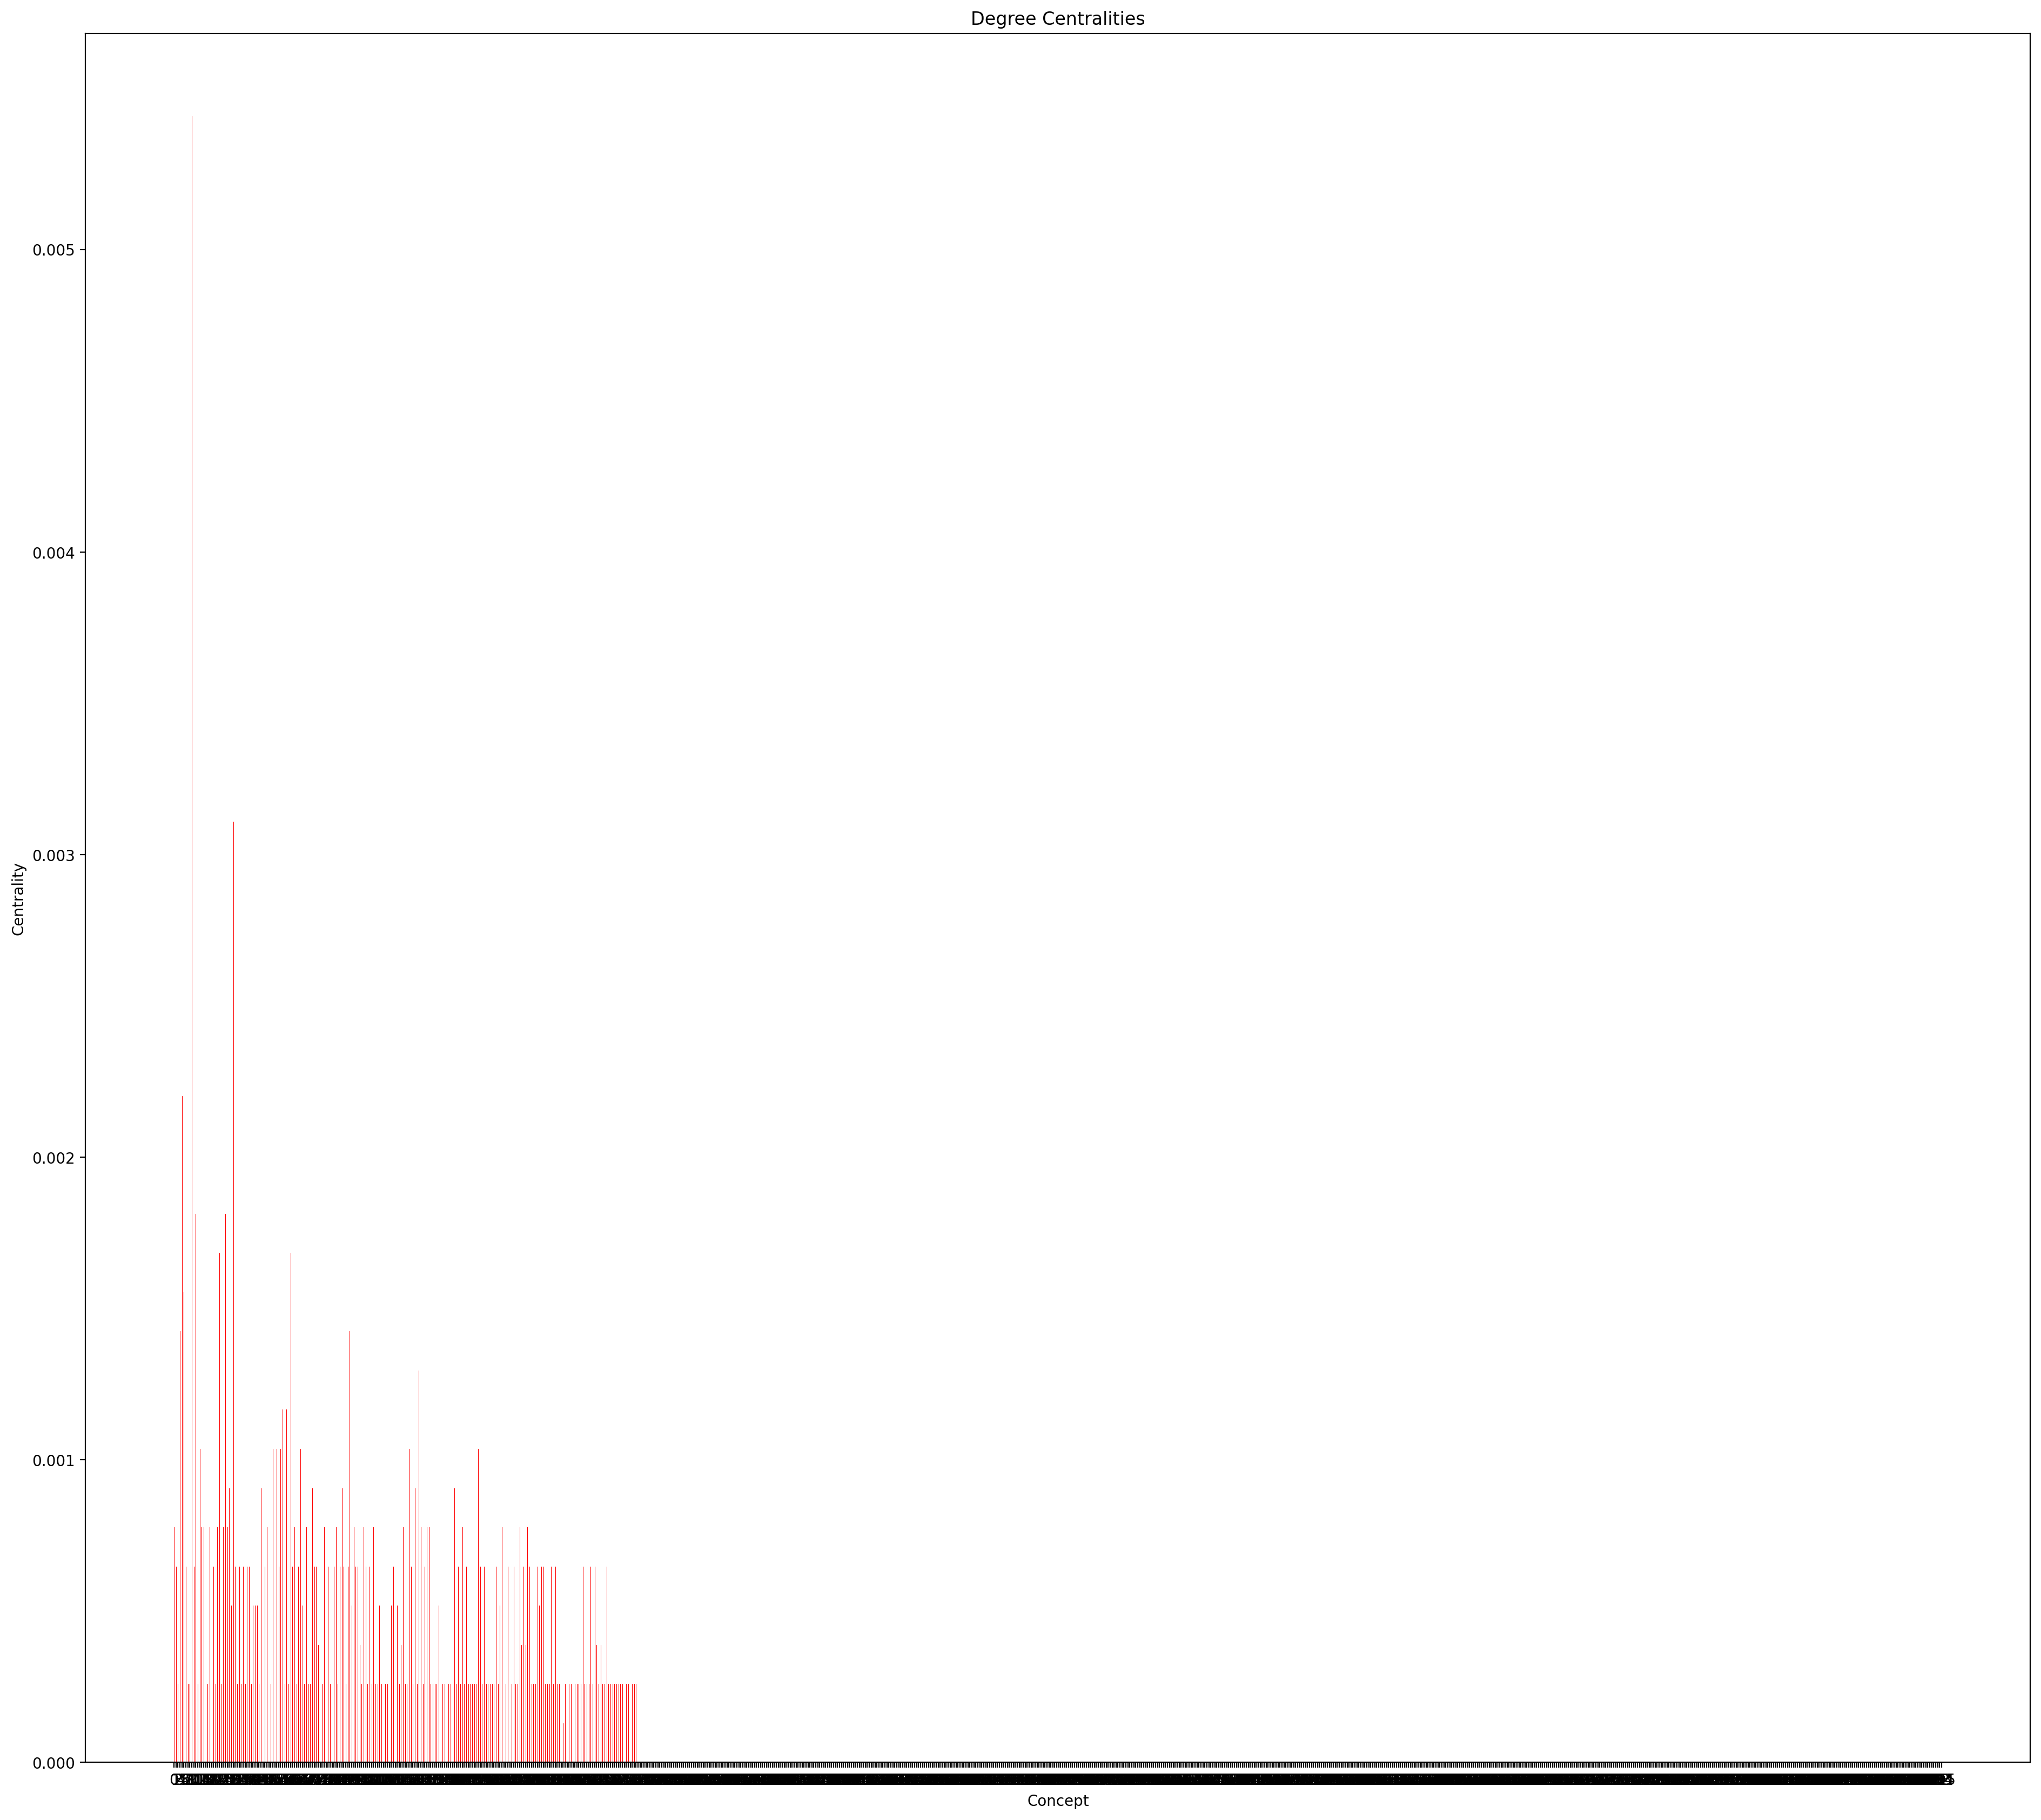

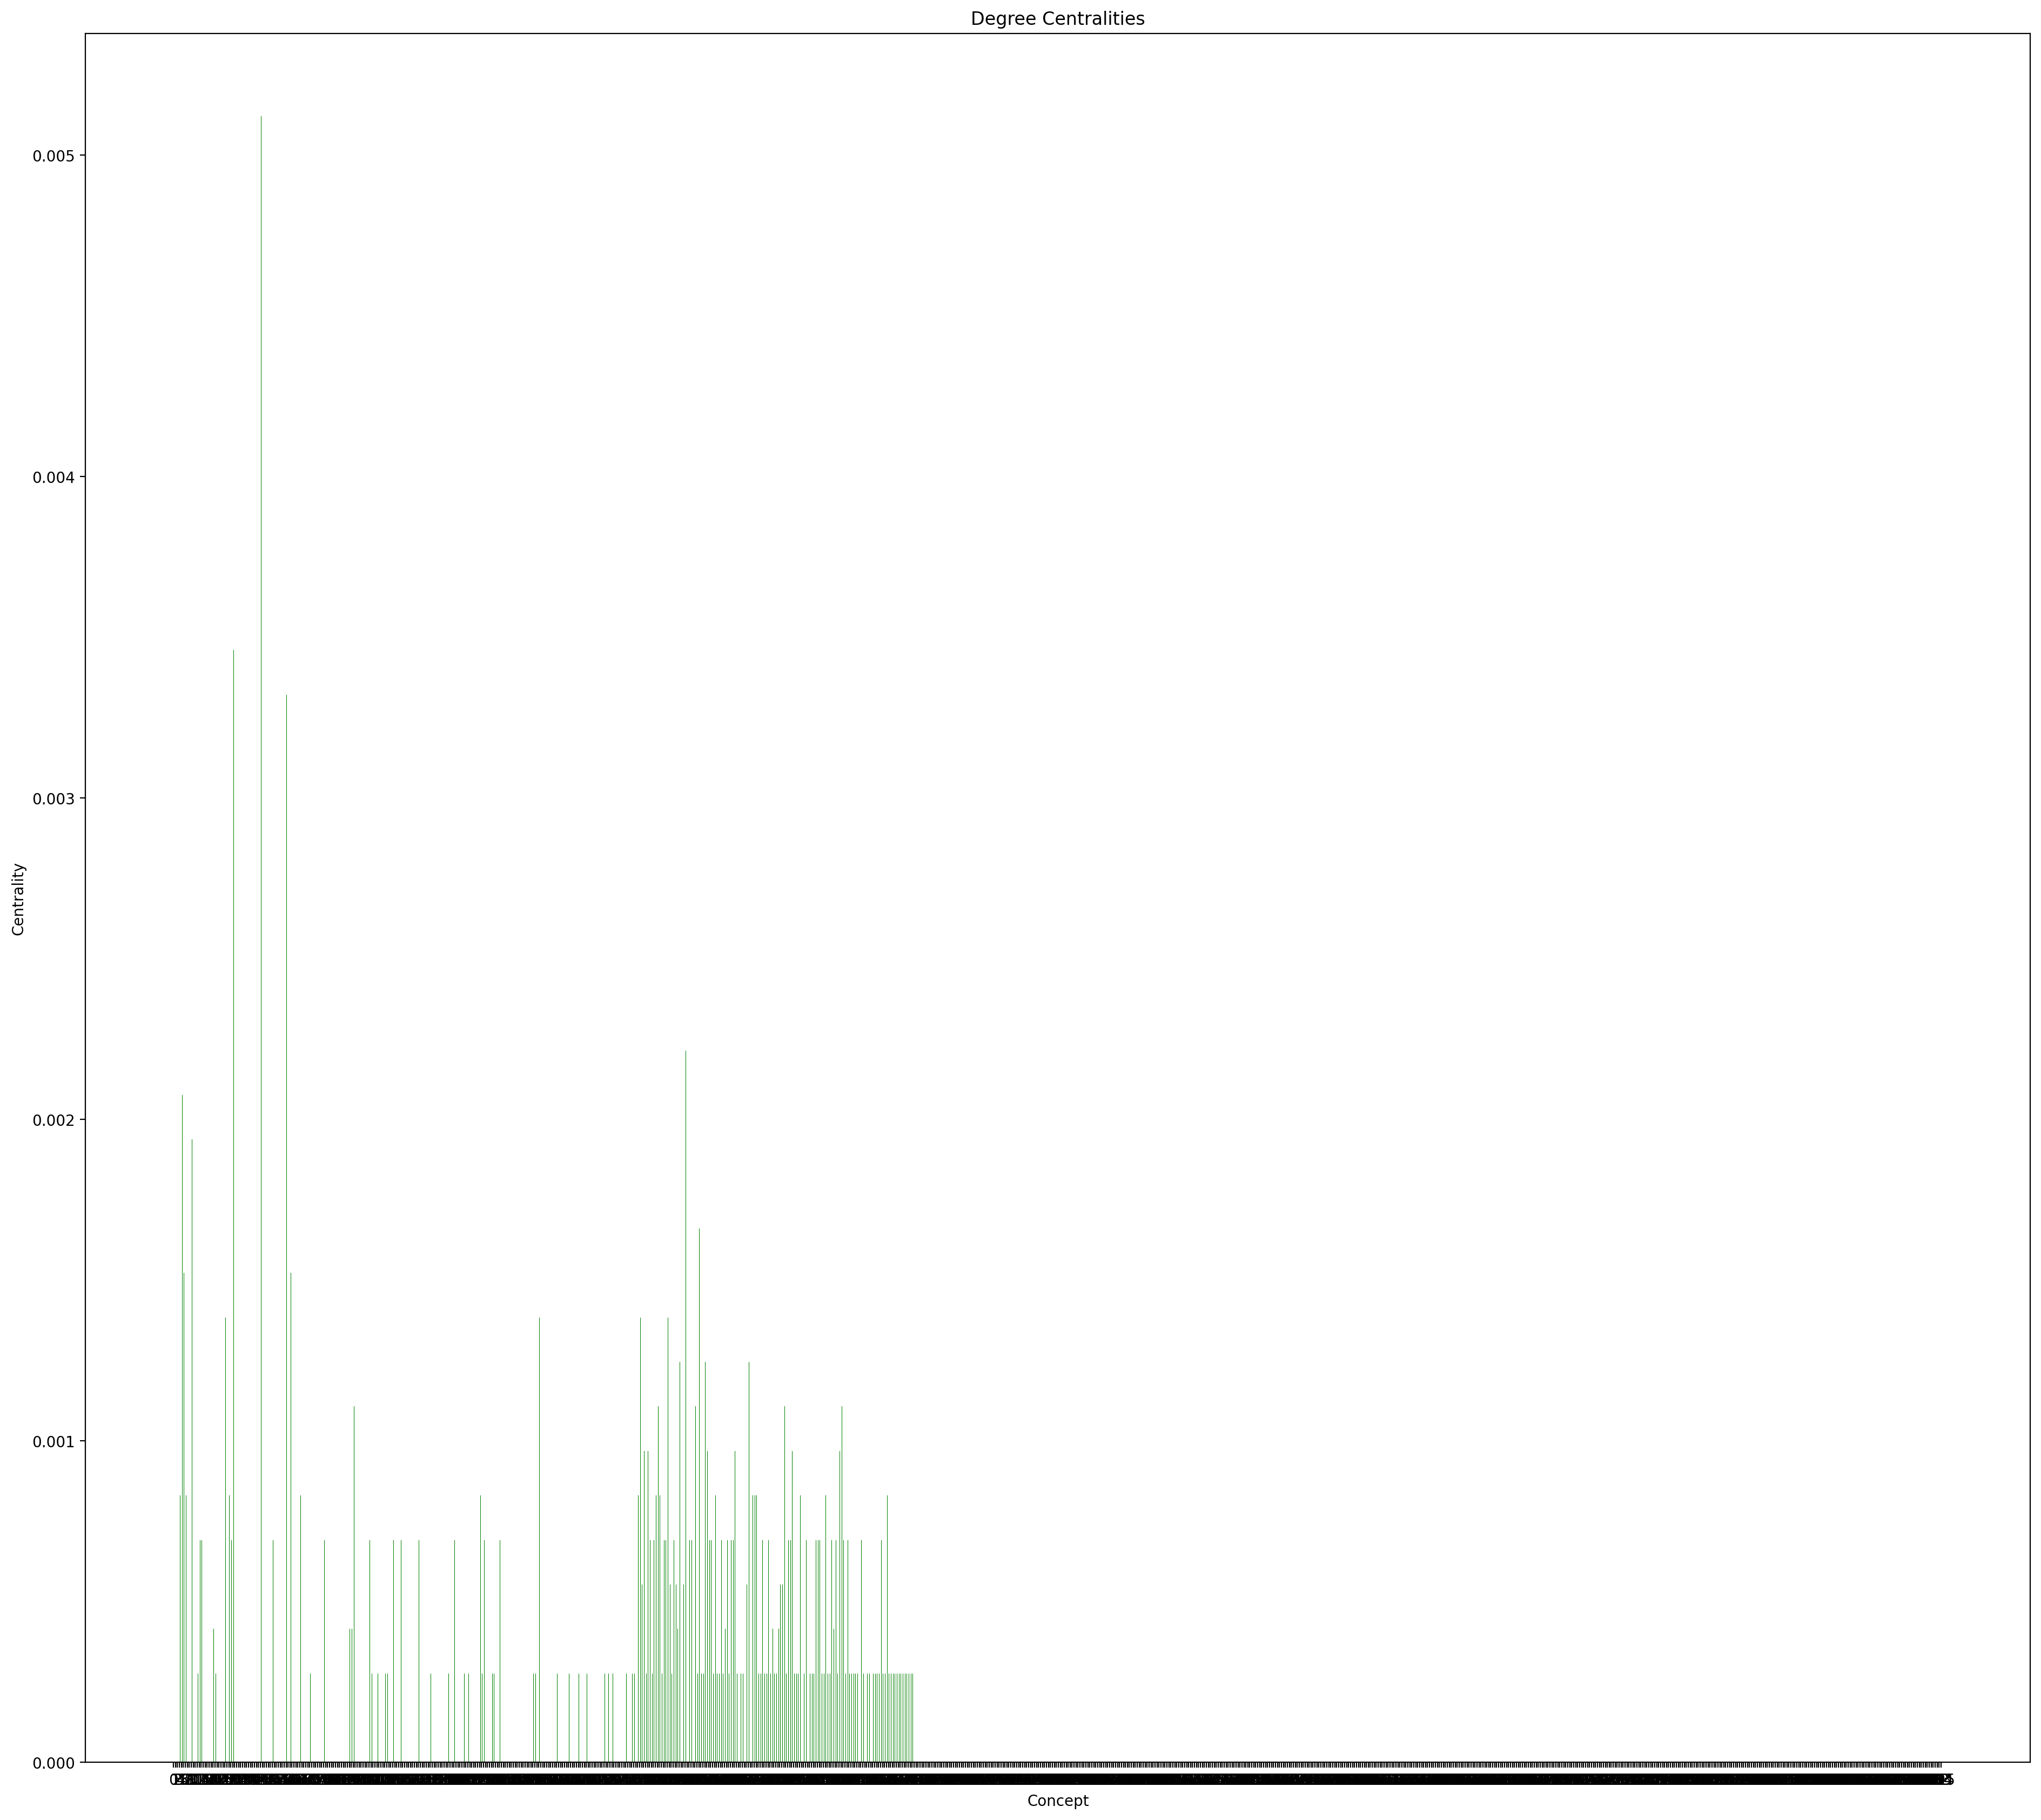

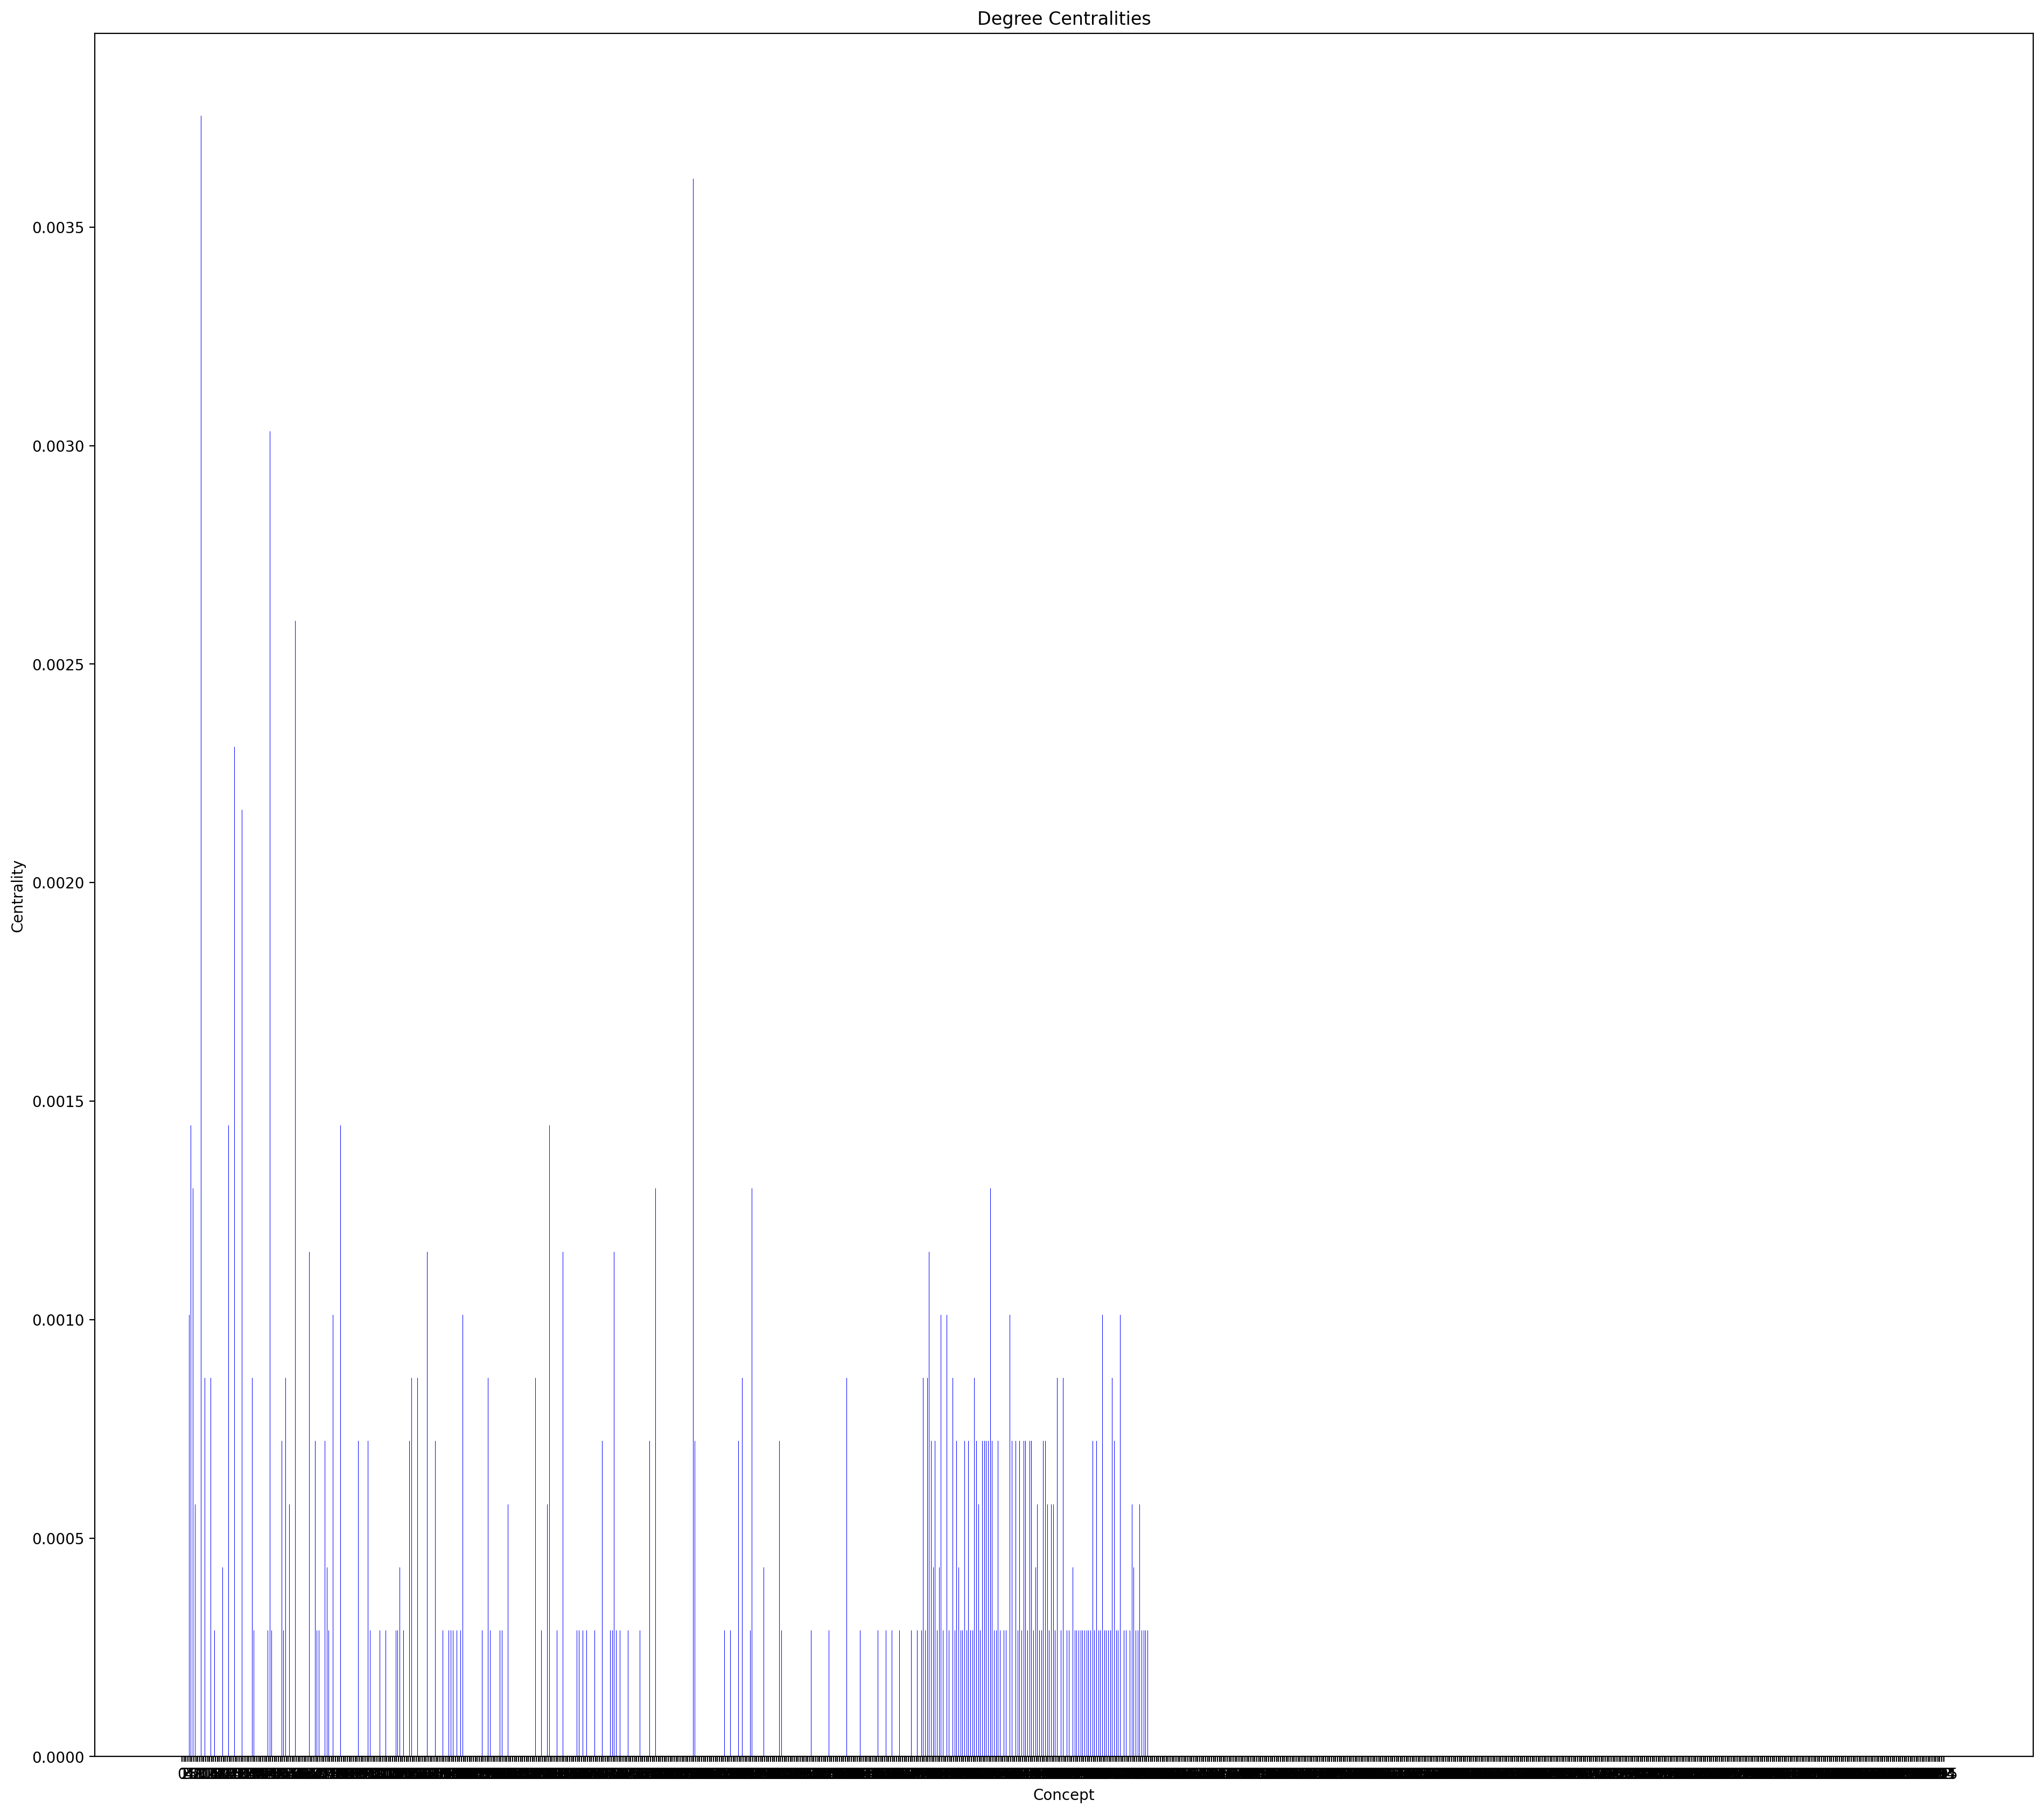

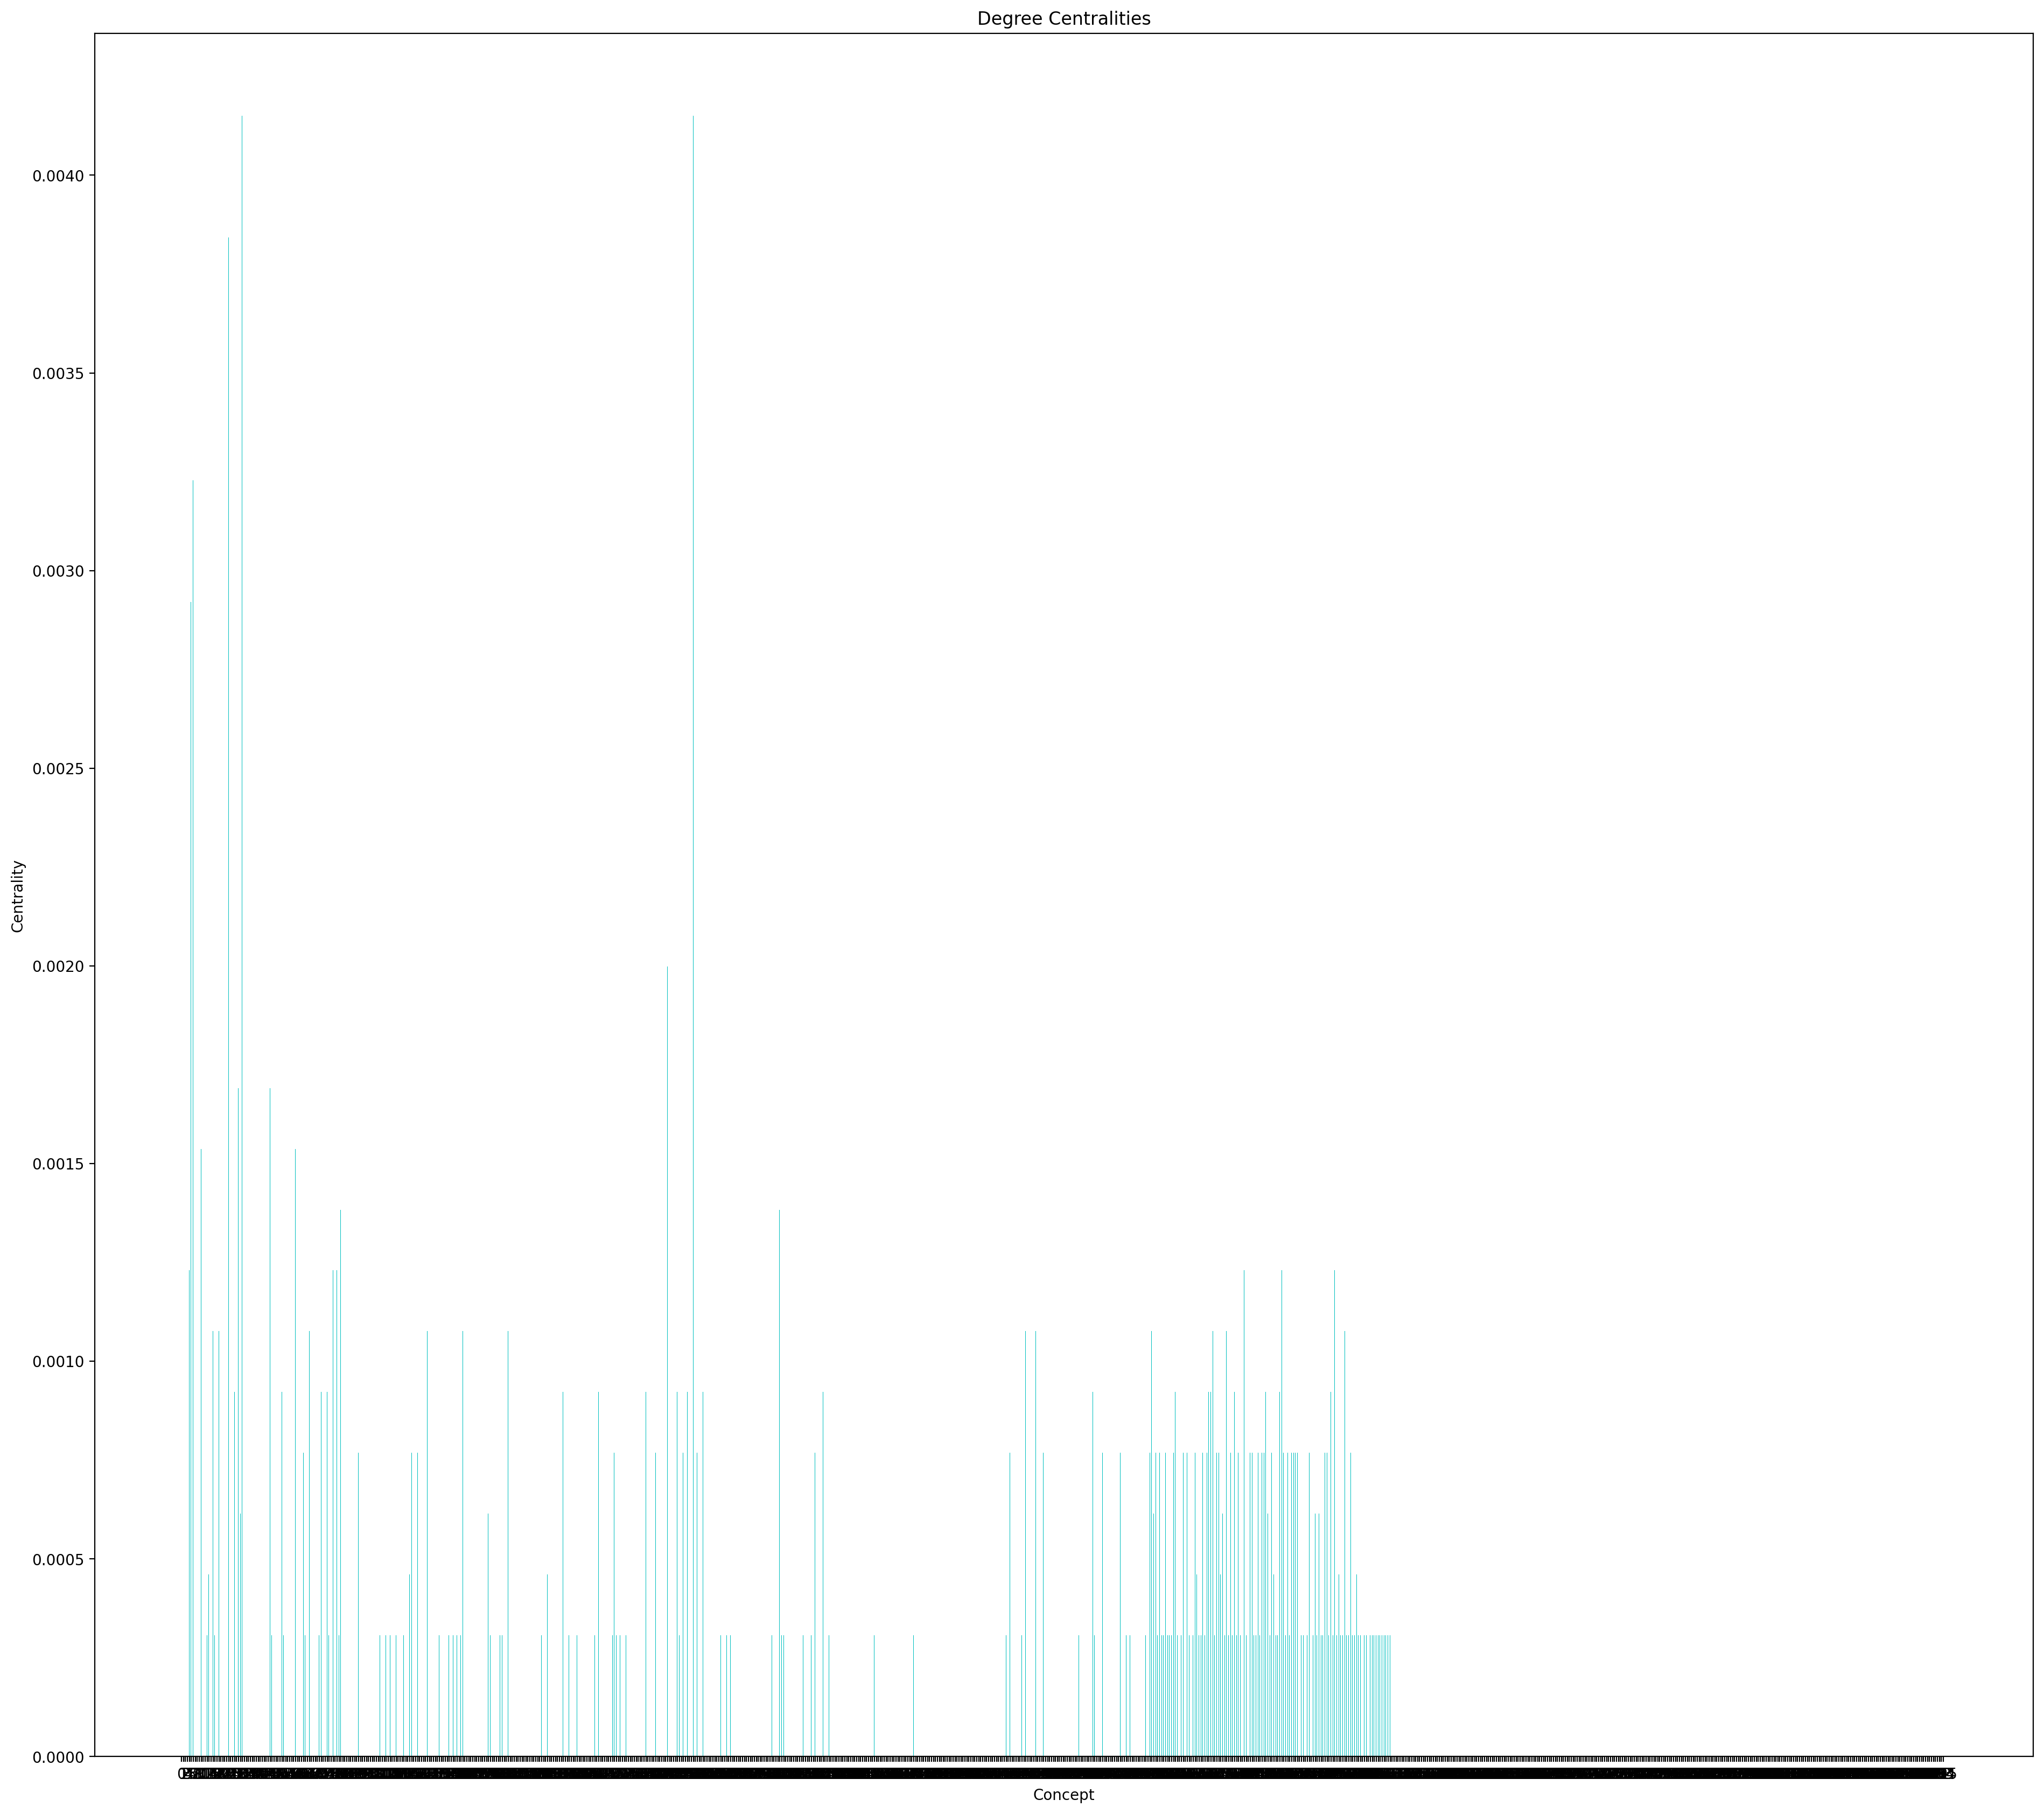

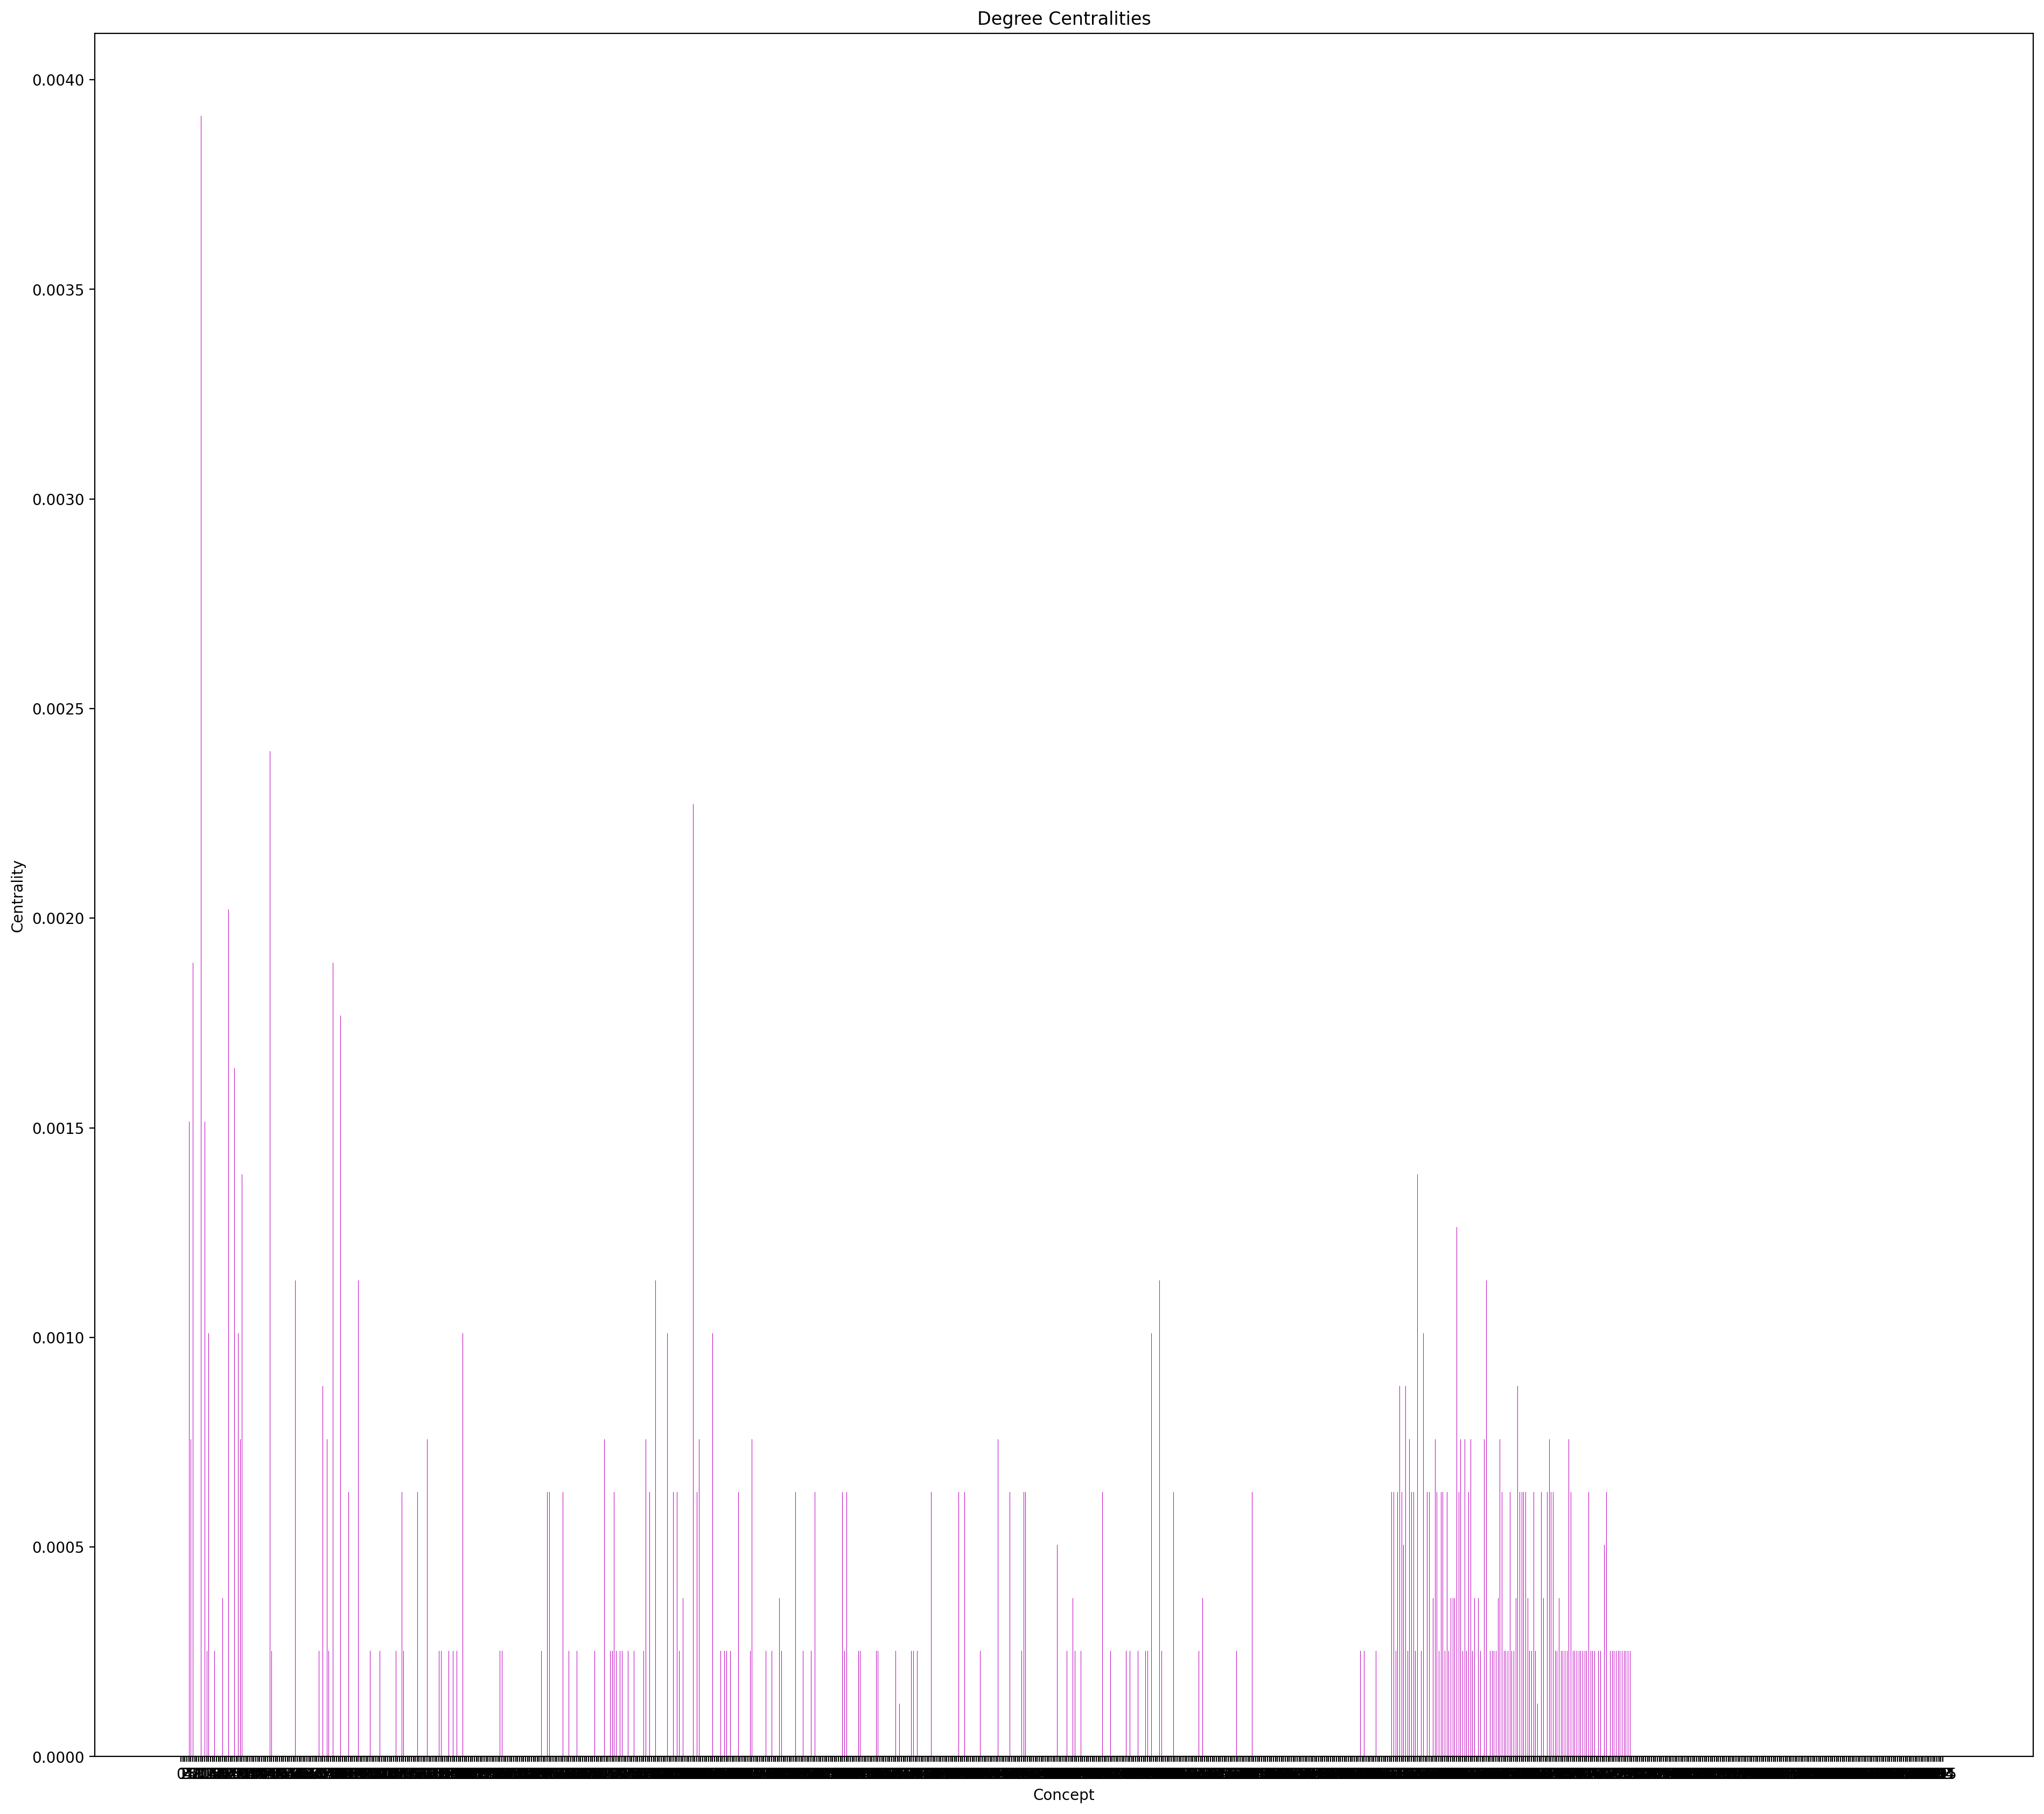

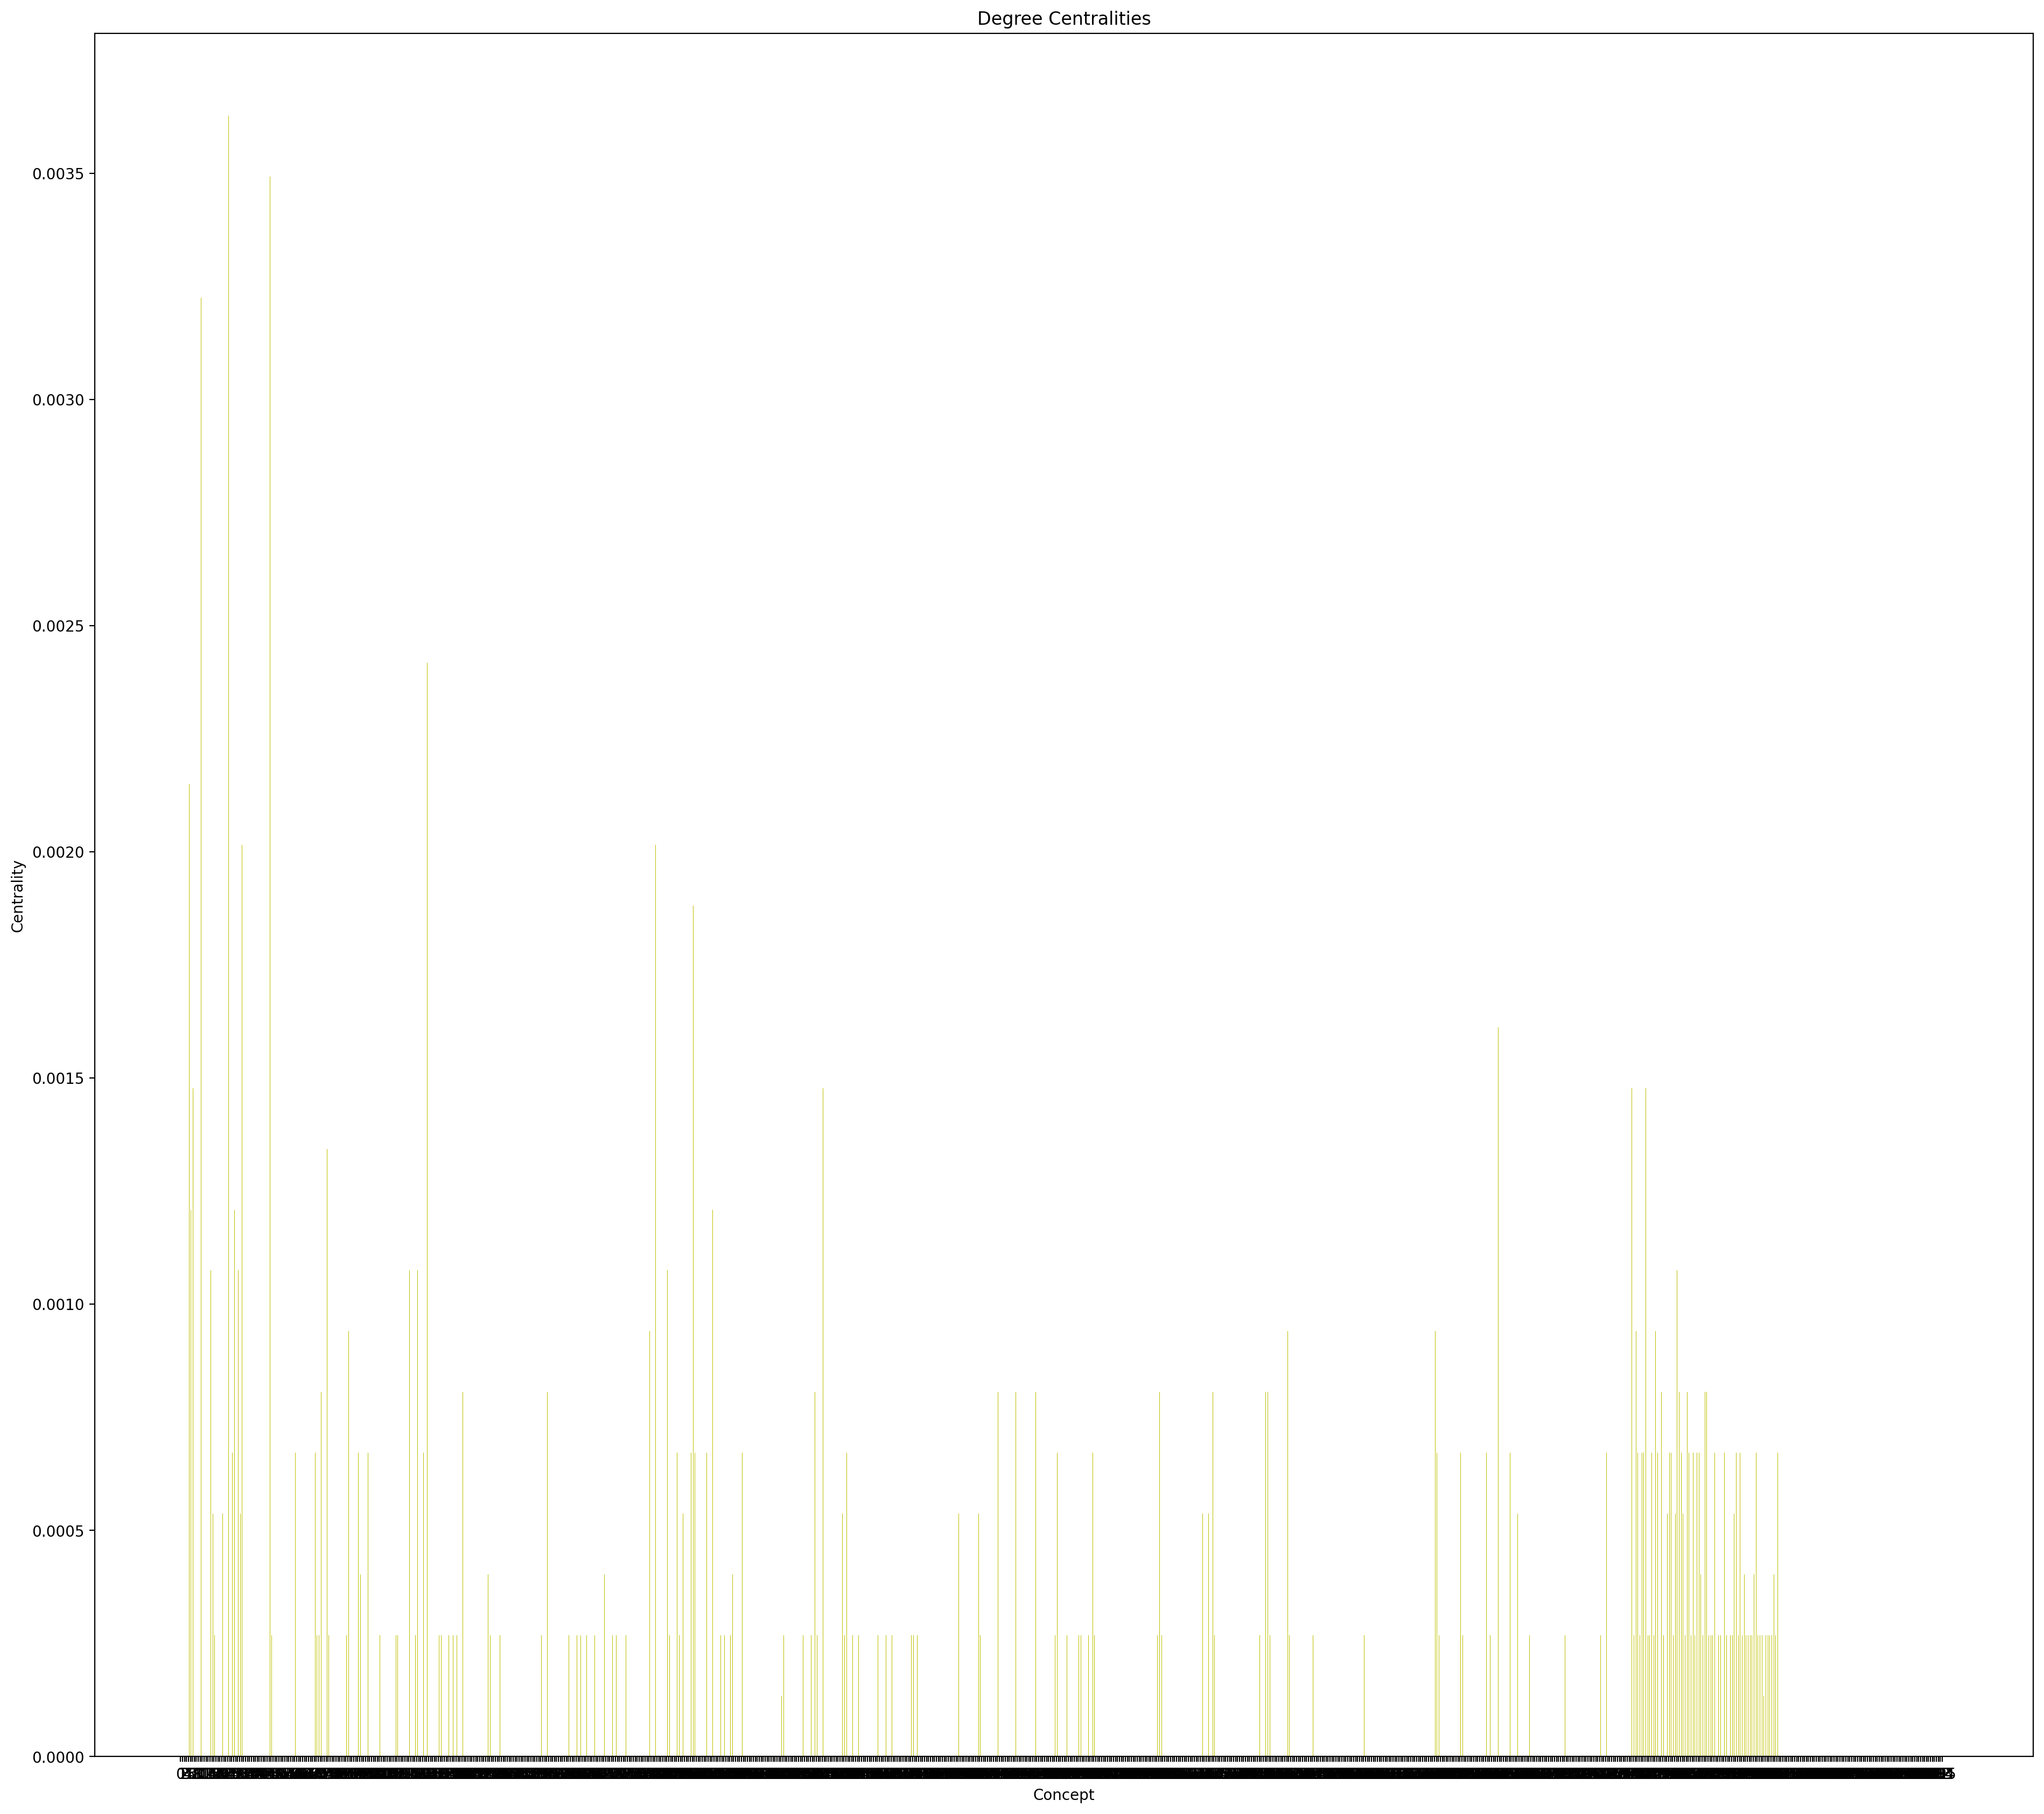

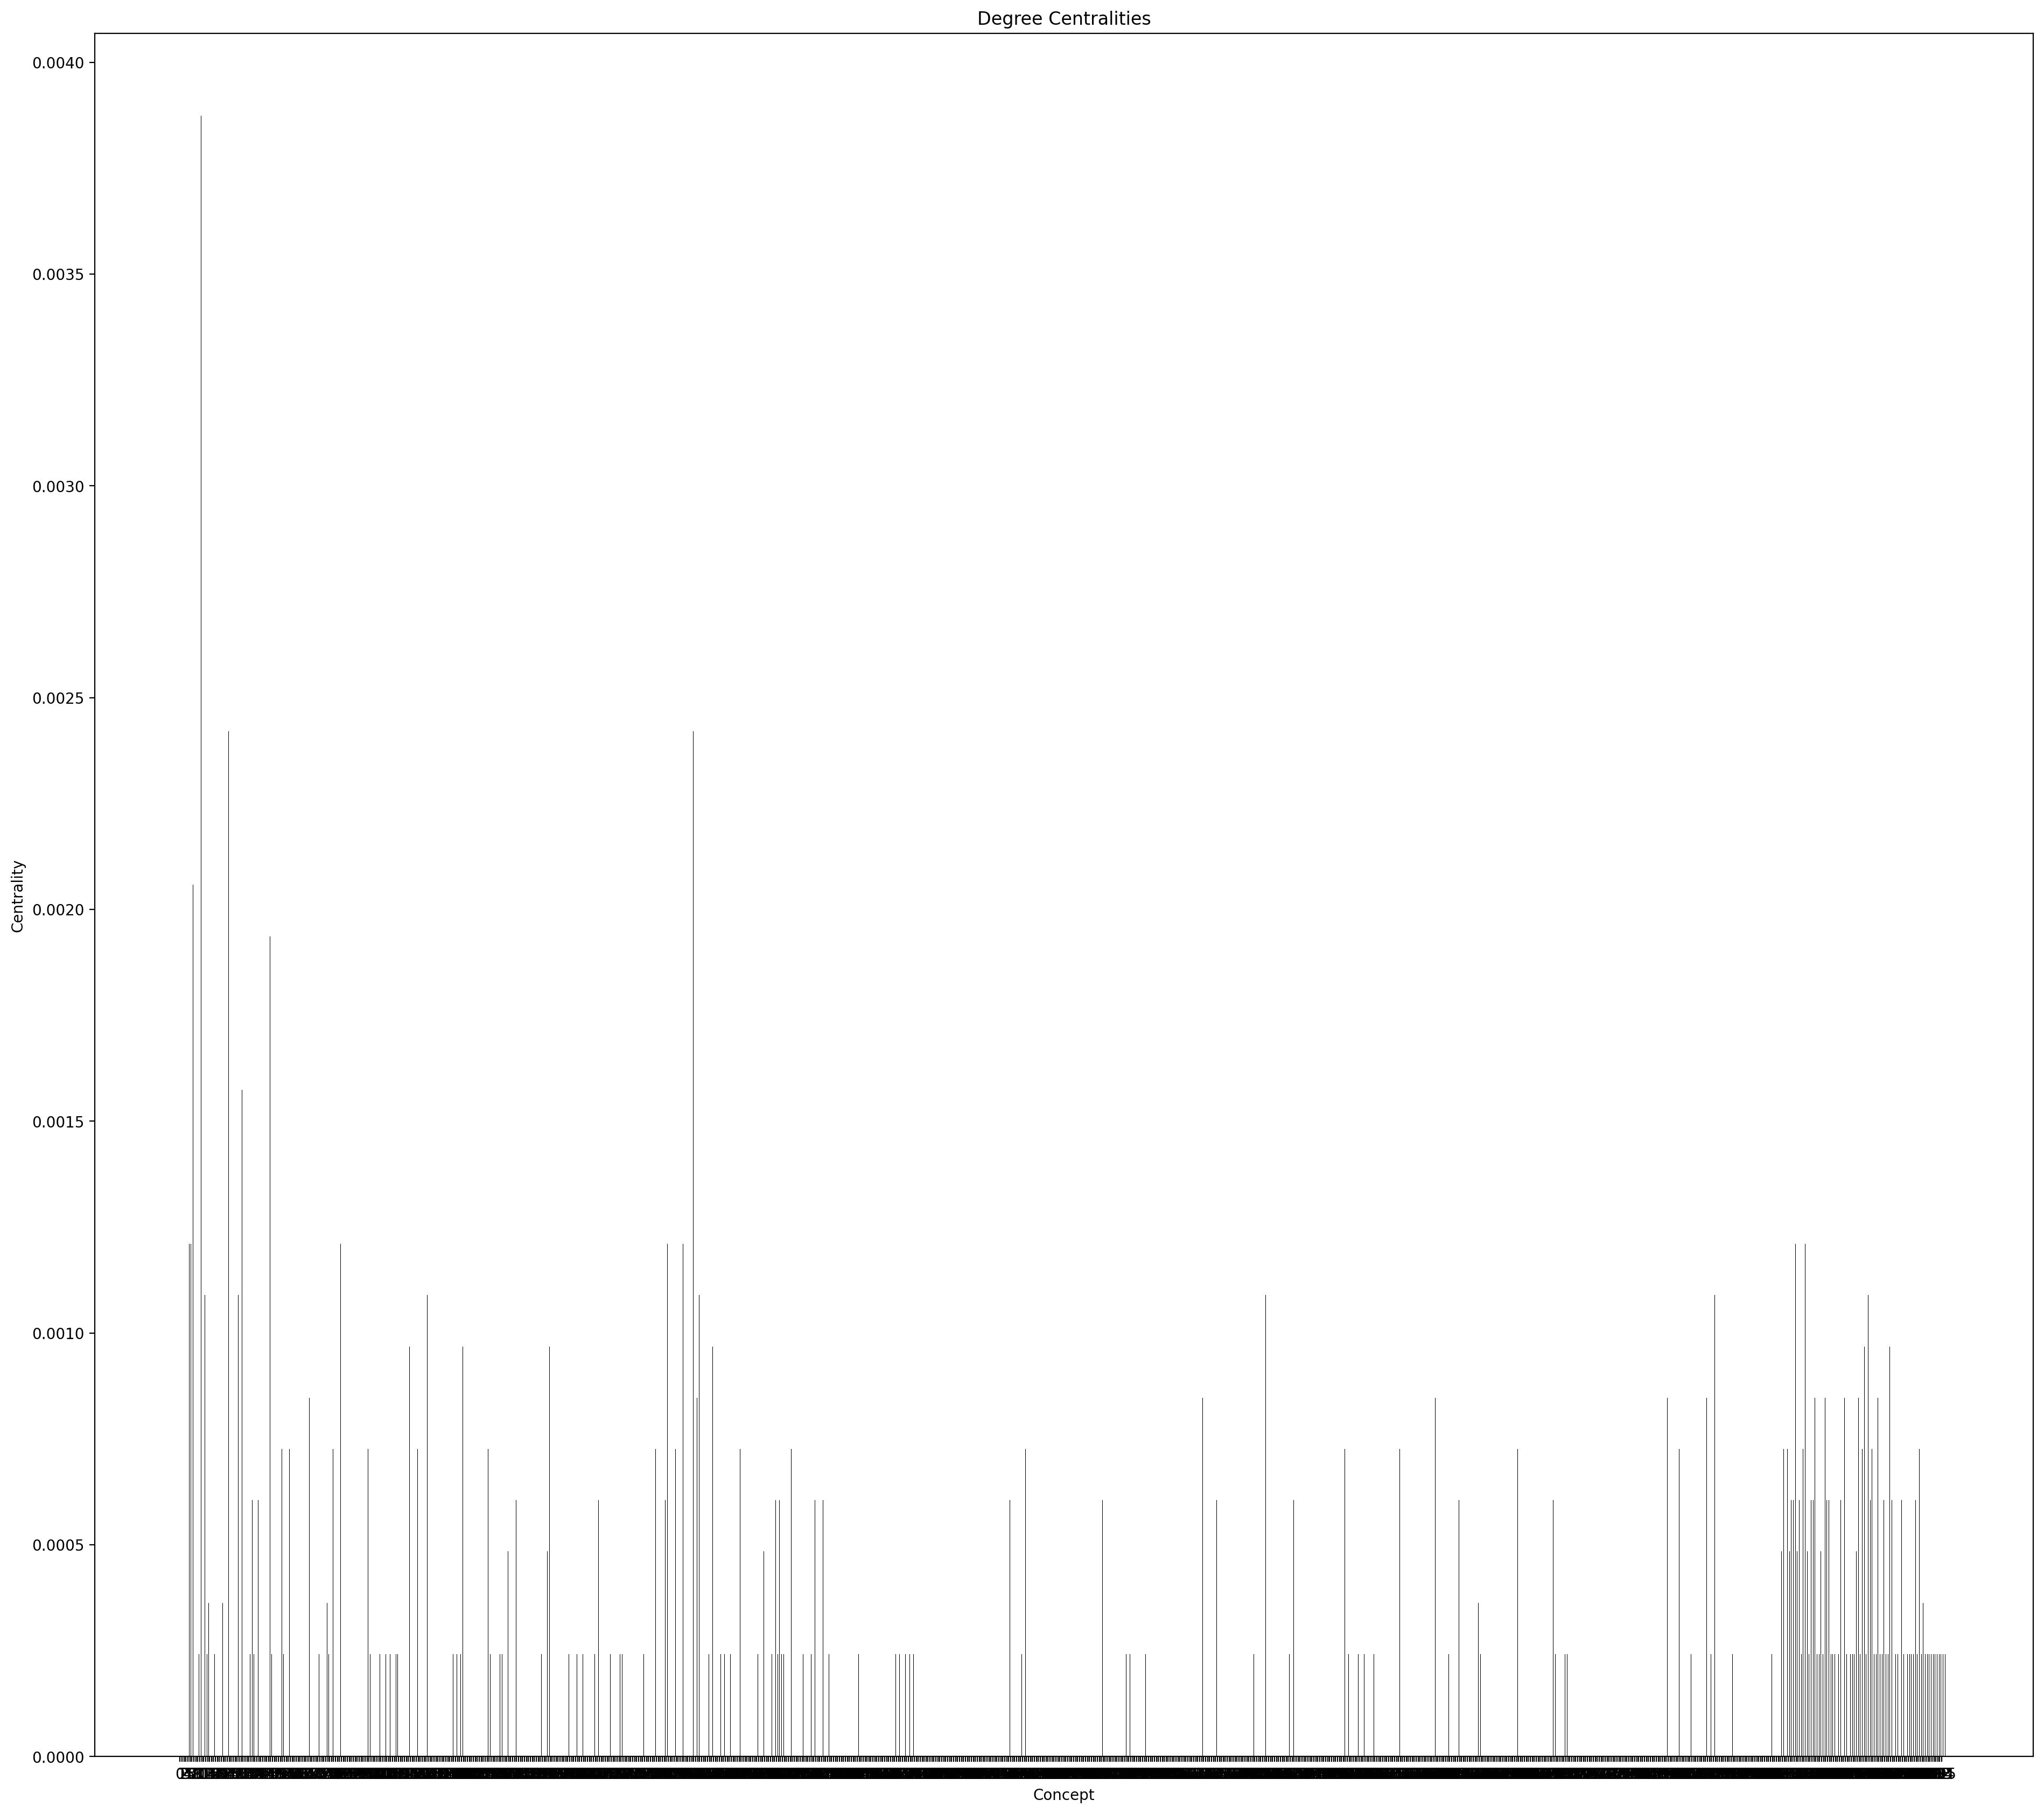

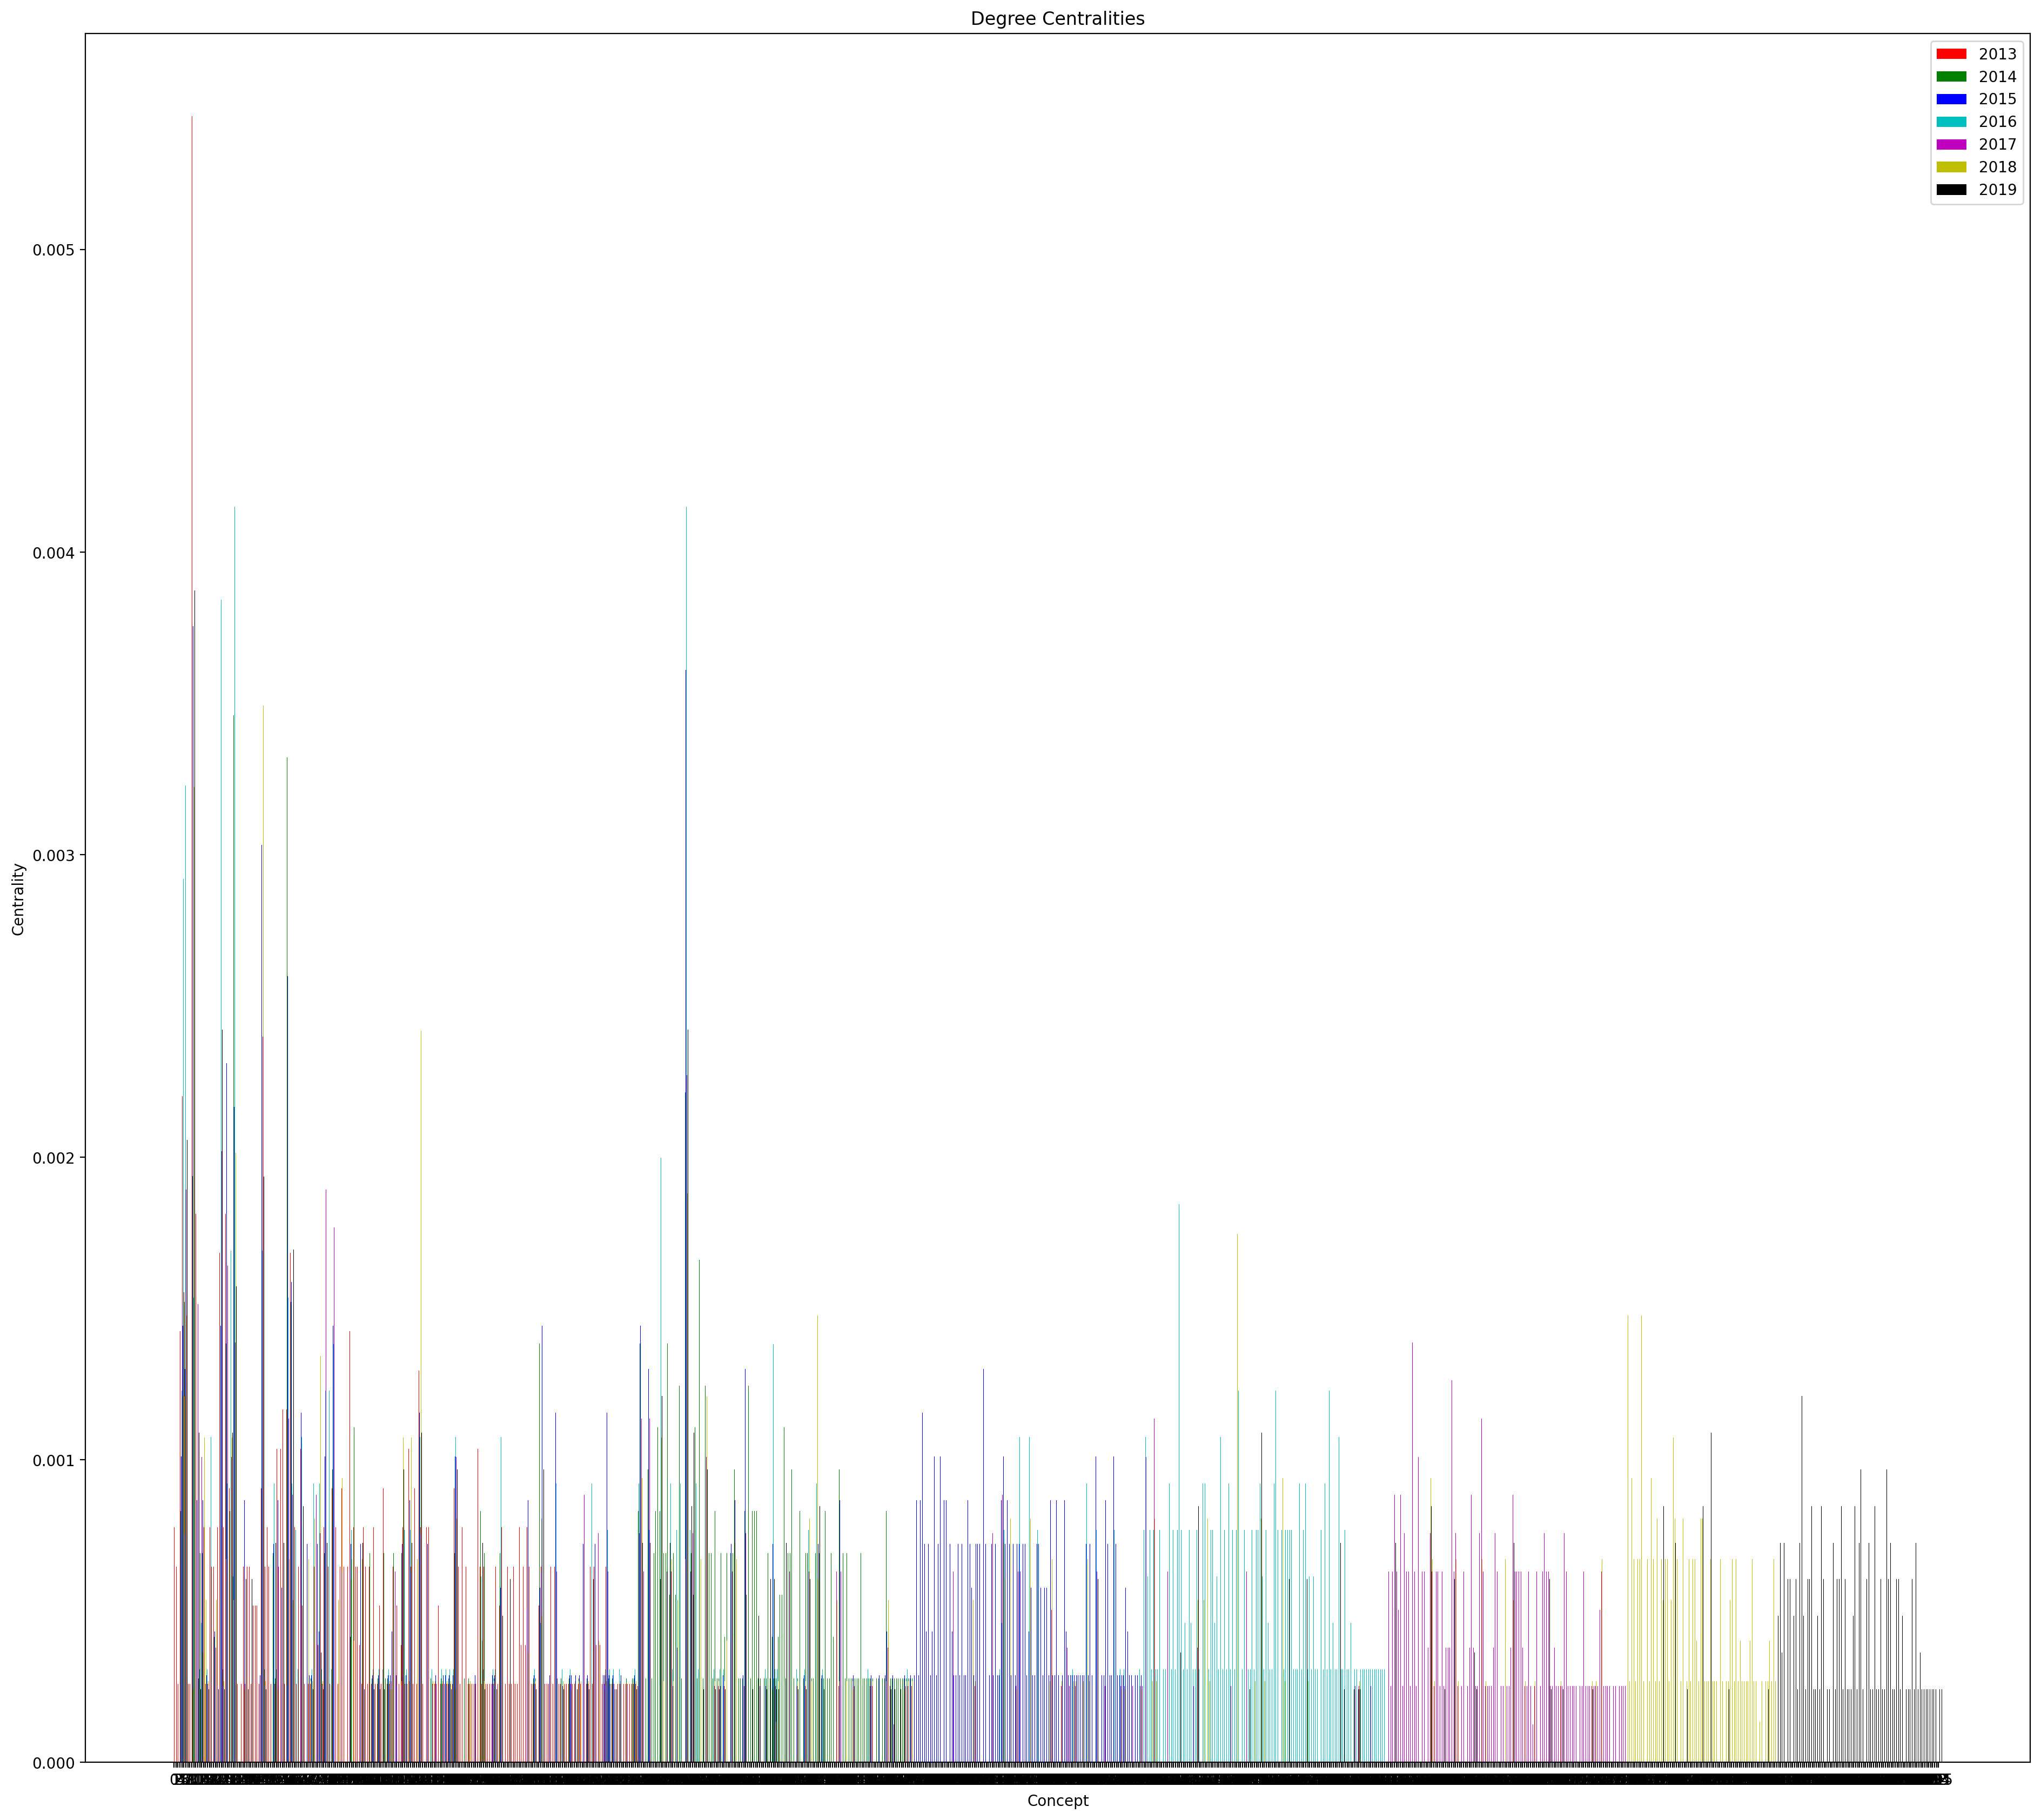

In [6]:
print('DEGREE CENTRALITY')
plot_all(deg_centrality, 'Degree Centralities')

TOP DEGREE CENTRALITIES
66
{rdflib.term.URIRef('http://local/local.owl#ontology'): [0.005441824306815237, 0.001937984496124031, 0.0037550548815713457, 0.0015372790161414297, 0.003914141414141414, 0.0032240730789897904, 0.00387409200968523], rdflib.term.URIRef('http://local/local.owl#semantic'): [0.003109613889608707, 0.0034606866002214838, 0.002166377816291161, 0.004150653343581861, 0.001388888888888889, 0.002015045674368619, 0.0015738498789346247], rdflib.term.URIRef('http://local/local.owl#semantic_web'): [0.0022026431718061676, 0.00207641196013289, 0.0014442518775274406, 0.0029208301306687164, 0.0007575757575757576, 0.0012090274046211715, 0.0012106537530266344], rdflib.term.URIRef('http://local/local.owl#owl'): [0.001813941435605079, 0.0013842746400885935, 0.002310803004043905, 0.0009223674096848579, 0.0016414141414141414, 0.0012090274046211715, 0], rdflib.term.URIRef('http://local/local.owl#inference'): [0.001813941435605079, 0, 0.0008665511265164644, 0, 0.0015151515151515152, 0, 0

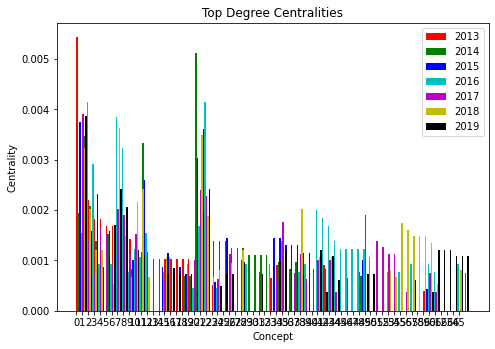

In [7]:
print('TOP DEGREE CENTRALITIES')
print(len(top_deg_centrality))
print(top_deg_centrality)
plot_combined(top_deg_centrality, 'Top Degree Centralities')

DEGREE CENTRALITY GRAPH EXAMPLES
Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2013:
- # of immediate neighbors: 42


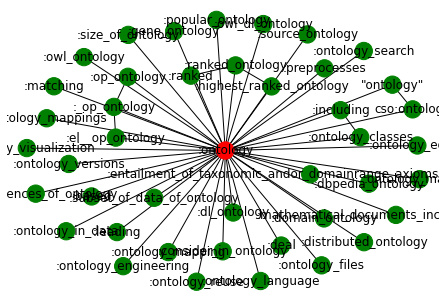

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2014:
- # of immediate neighbors: 14


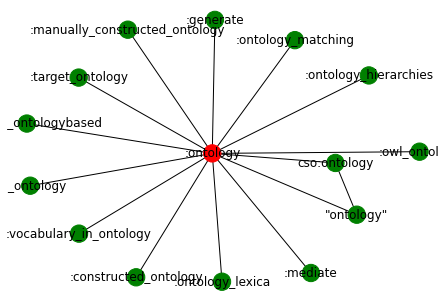

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2015:
- # of immediate neighbors: 26


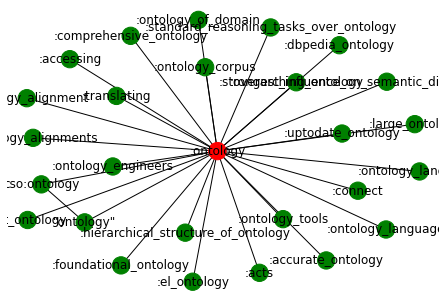

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2016:
- # of immediate neighbors: 10


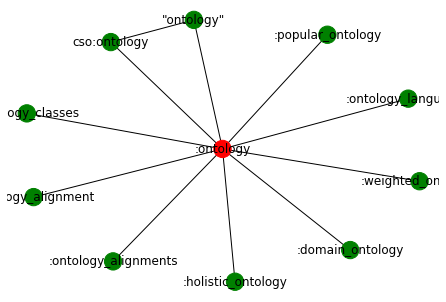

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2017:
- # of immediate neighbors: 31


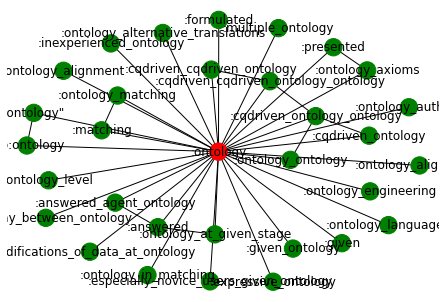

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2018:
- # of immediate neighbors: 22


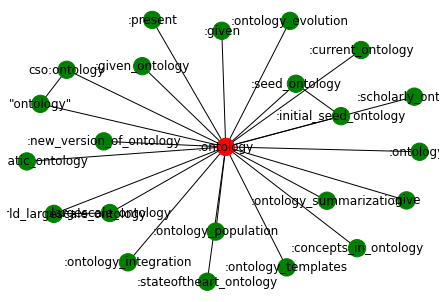

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2019:
- # of immediate neighbors: 32


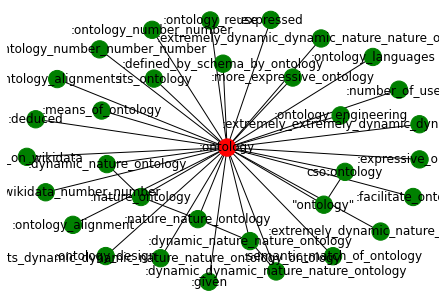

In [8]:
print('DEGREE CENTRALITY GRAPH EXAMPLES')
for curr_year in nxgs.keys():
    for key in top_deg_centrality.keys():
        if key.endswith('#ontology'):
            draw_subgraph(curr_year, key)
            break

In [9]:
eig_centrality, top_eig_centrality = get_centrality(nx.eigenvector_centrality)

Top 20 values for 2013
 - http://local/local.owl#ontology: 0.035997819814834416 -- ref: https://cso.kmi.open.ac.uk/topics/ontology
 - http://local/local.owl#stream_data: 0.02460486608805126 -- ref: https://cso.kmi.open.ac.uk/topics/stream_data
 - http://local/local.owl#rdf_data: 0.022299687864484823 -- ref: https://cso.kmi.open.ac.uk/topics/rdf_data
 - http://local/local.owl#linked_data: 0.020890871241724212 -- ref: https://cso.kmi.open.ac.uk/topics/linked_data
 - http://local/local.owl#scholarly_data: 0.020662575684410094 -- ref: https://cso.kmi.open.ac.uk/topics/scholarly_data
 - http://local/local.owl#rdfs_data: 0.02012433026671077 -- ref: https://cso.kmi.open.ac.uk/topics/rdf_data
 - http://local/local.owl#geospatial_data: 0.02009847274376993 -- ref: https://cso.kmi.open.ac.uk/topics/geo-spatial_data
 - http://local/local.owl#data_integration: 0.019992789244819176 -- ref: https://cso.kmi.open.ac.uk/topics/data_integration
 - http://local/local.owl#relational_data: 0.019740861298636

ALL EIGENVECTOR CENTRALITIES


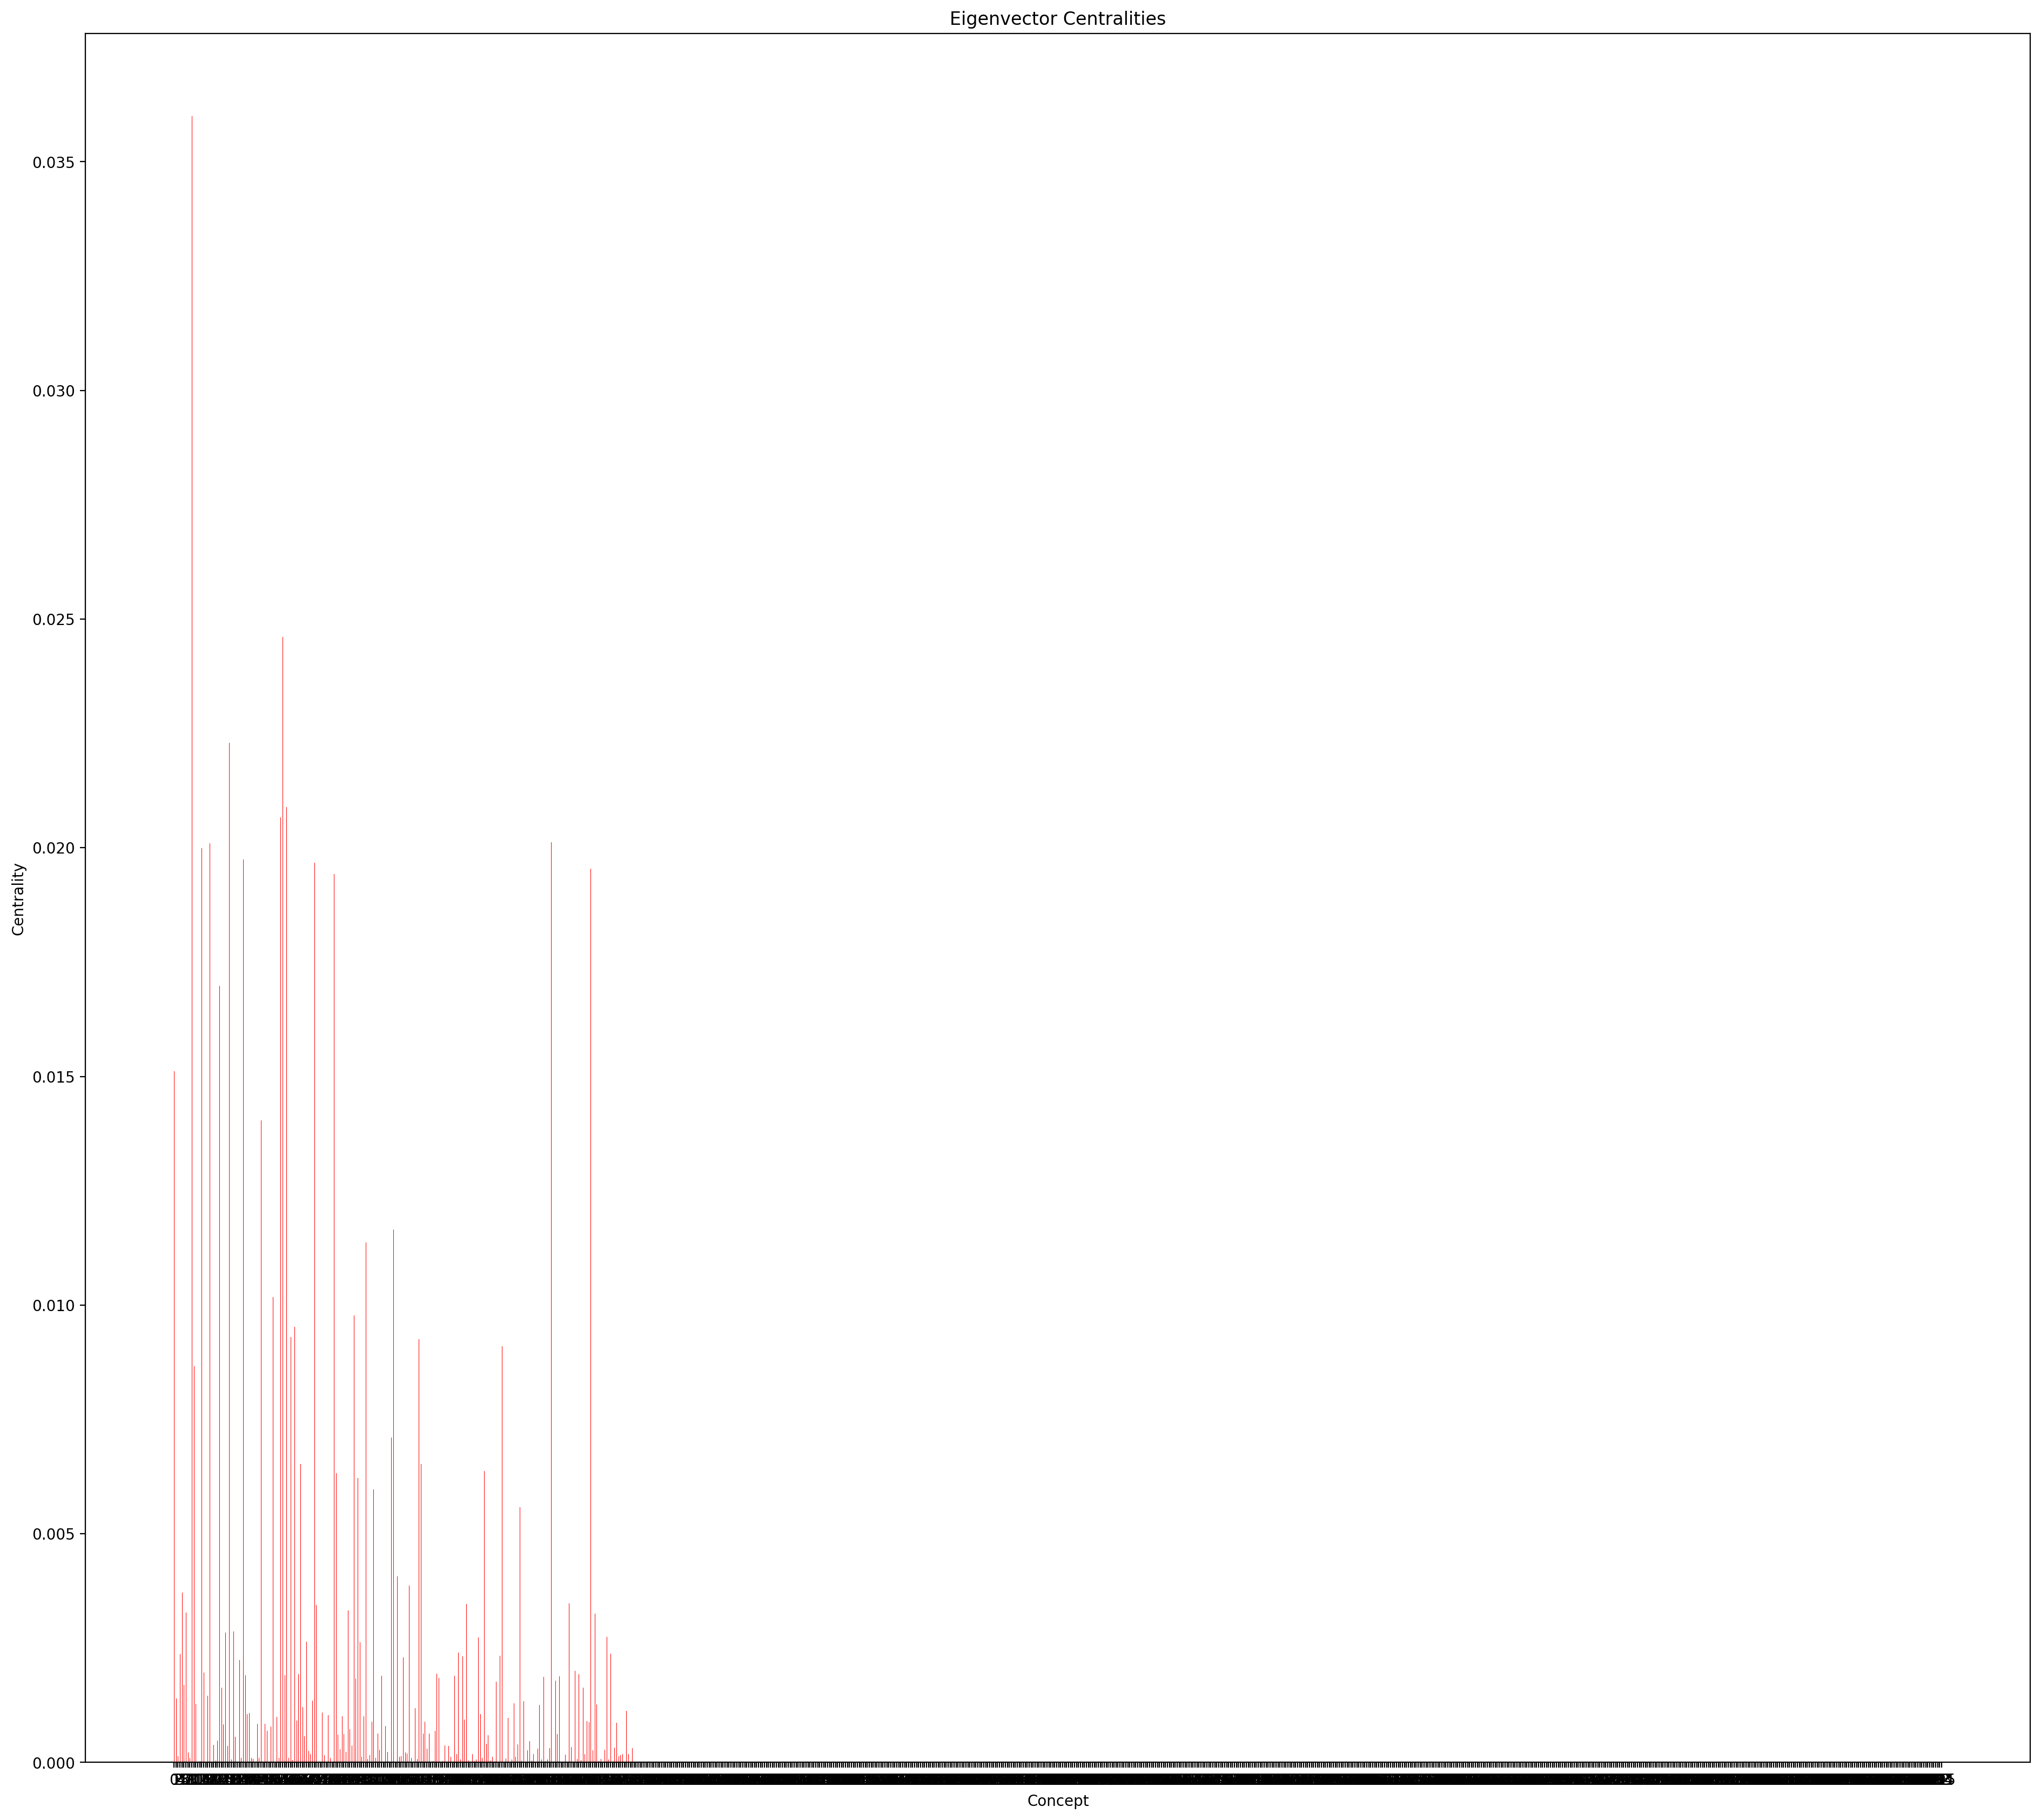

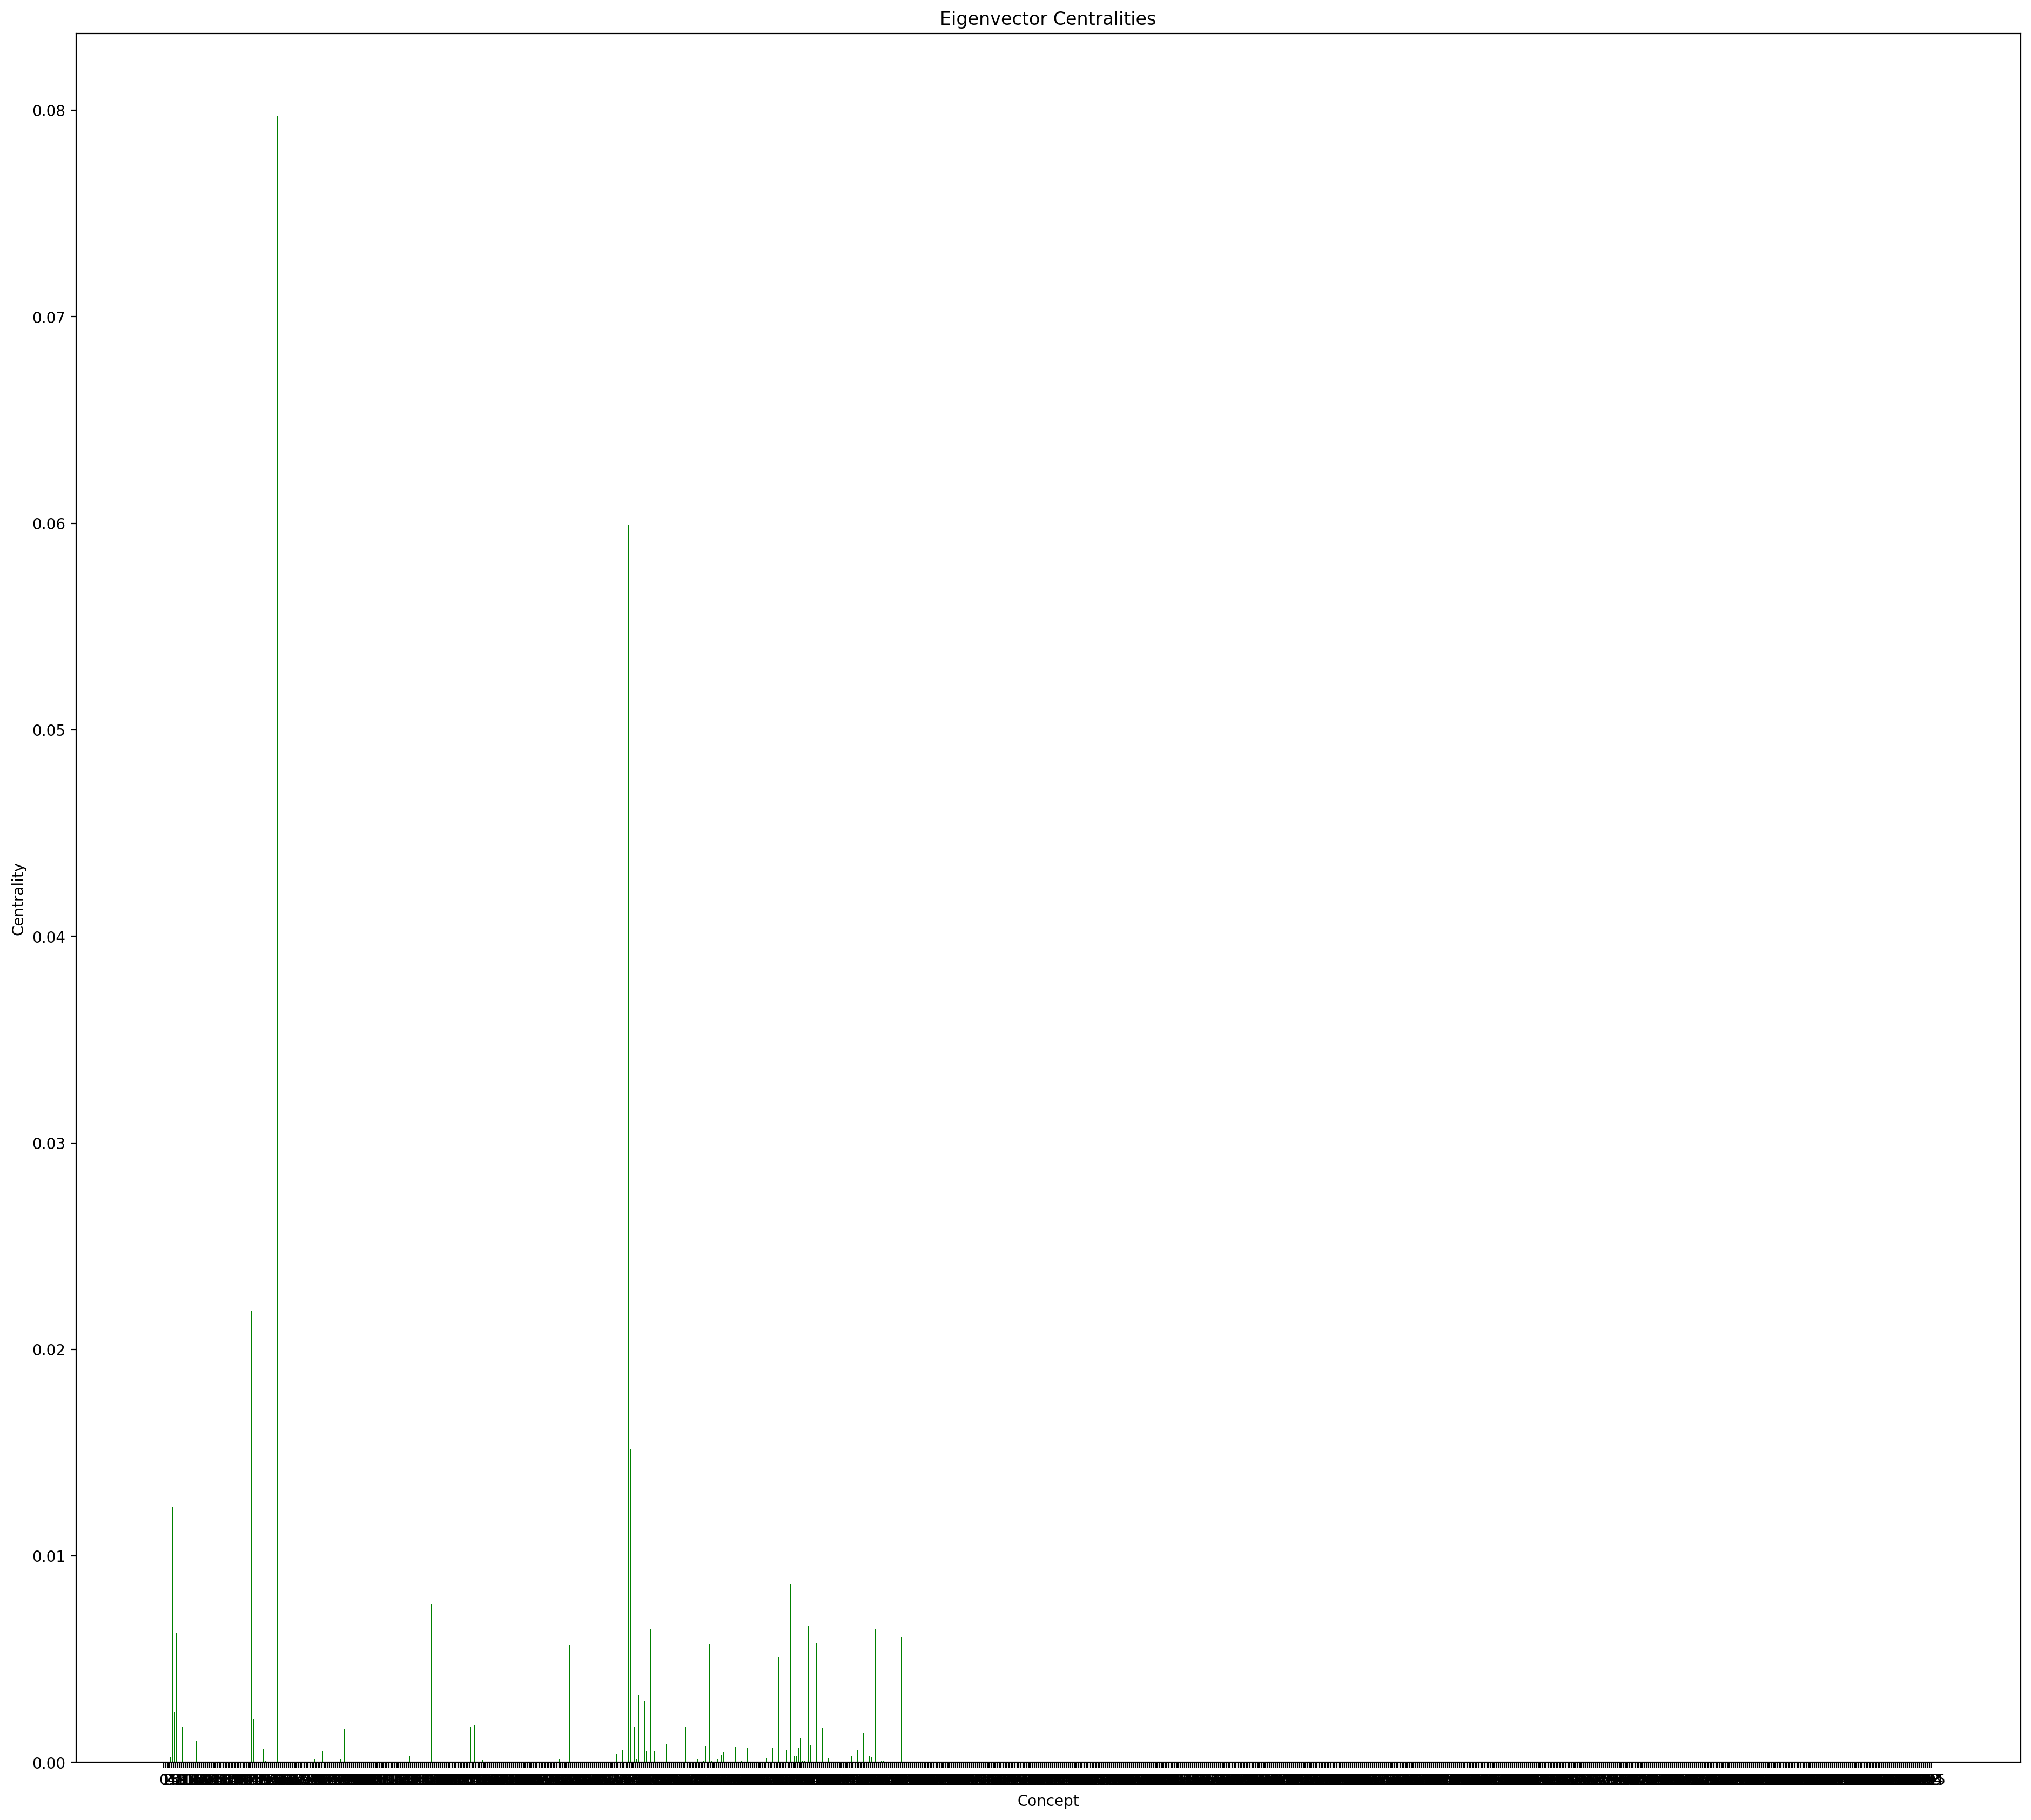

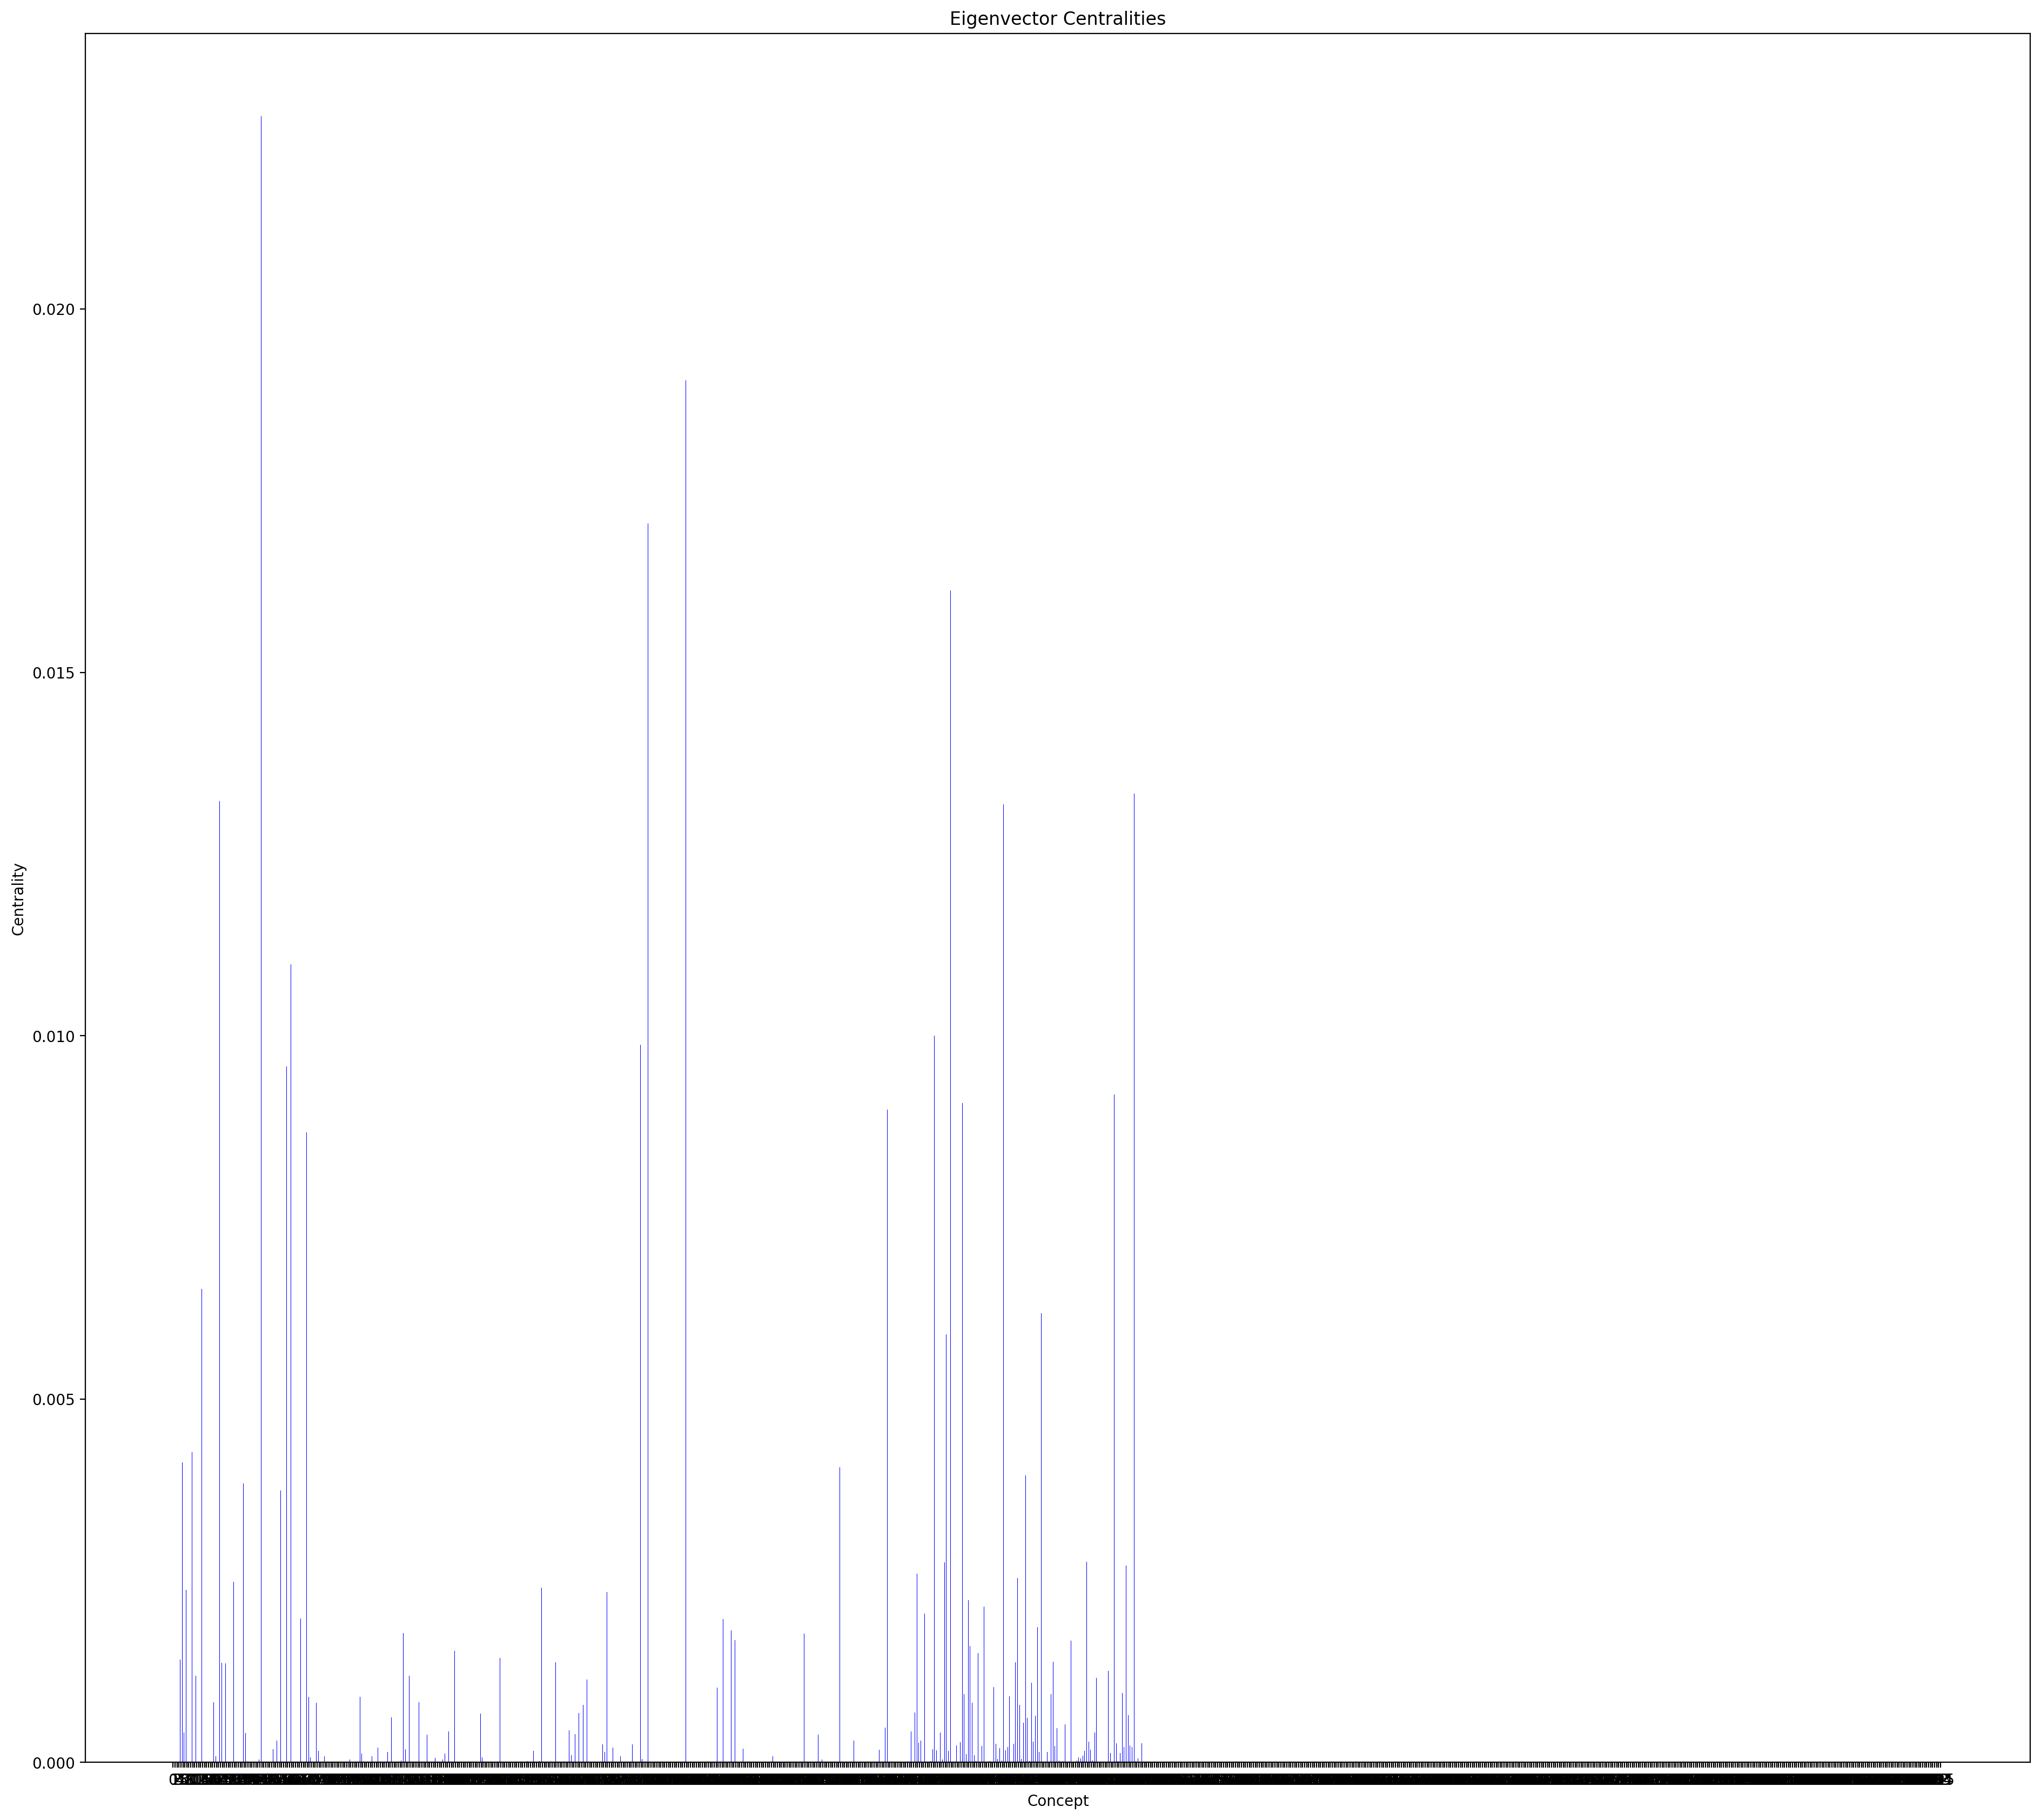

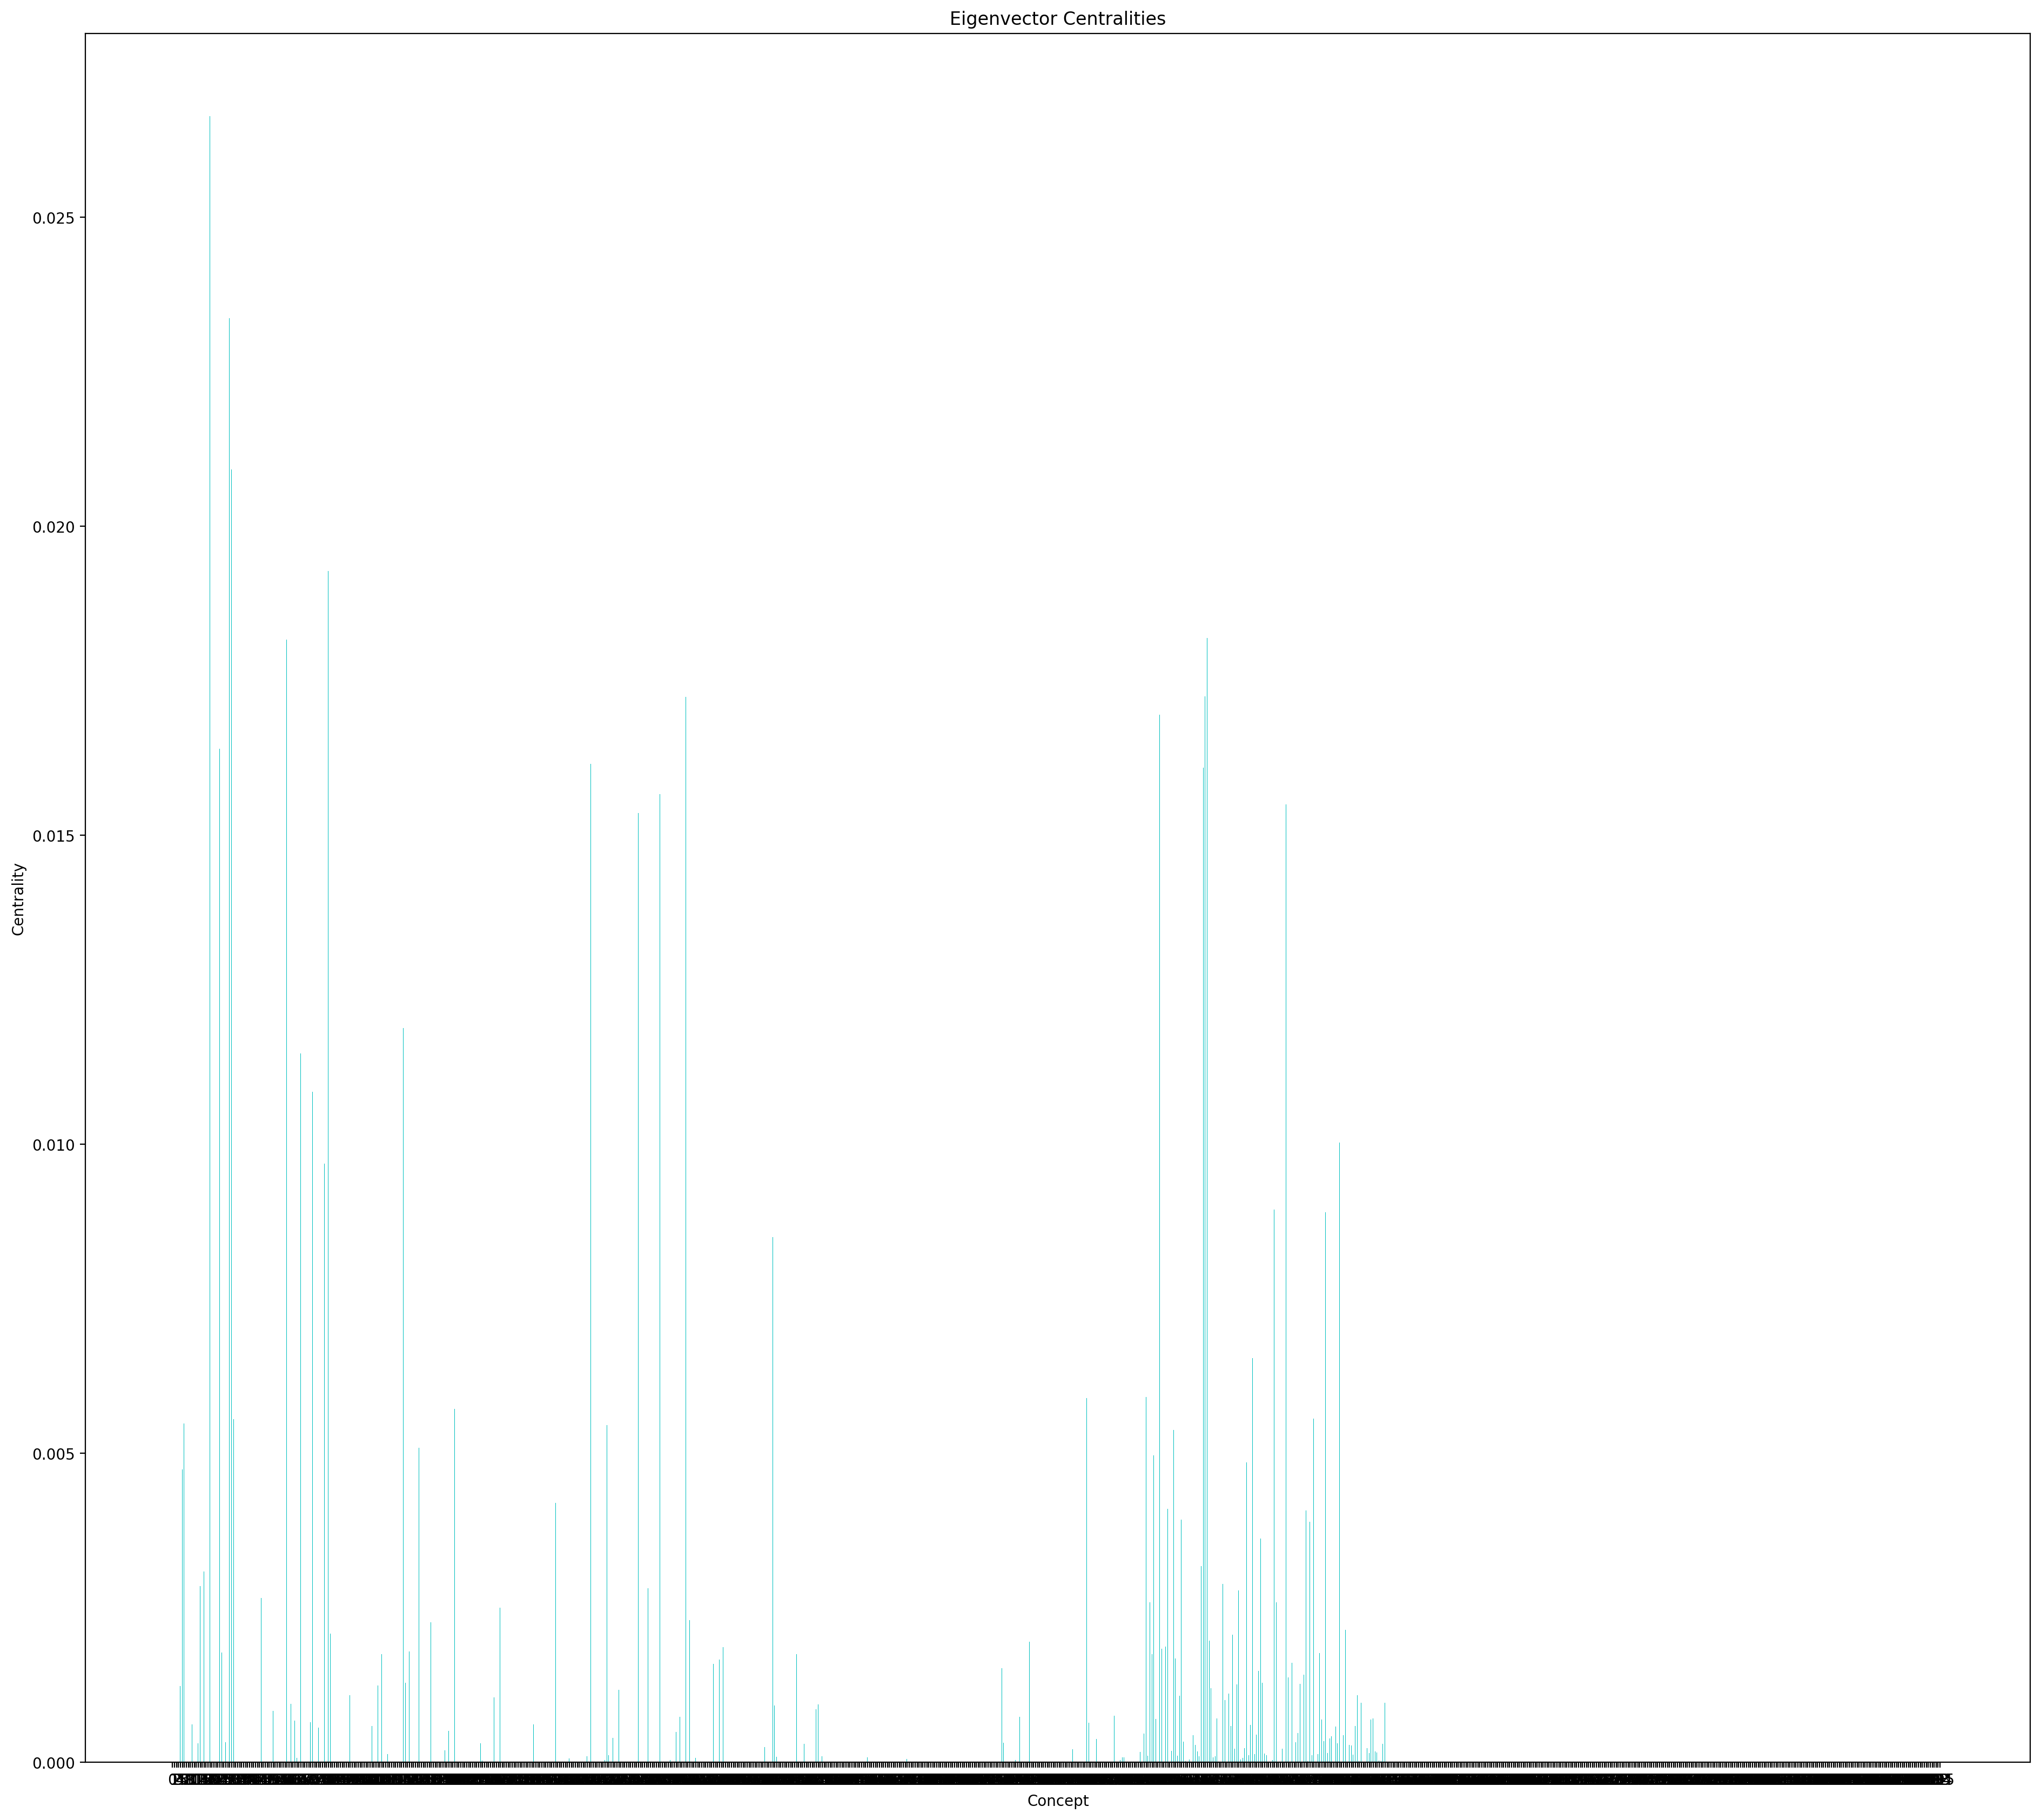

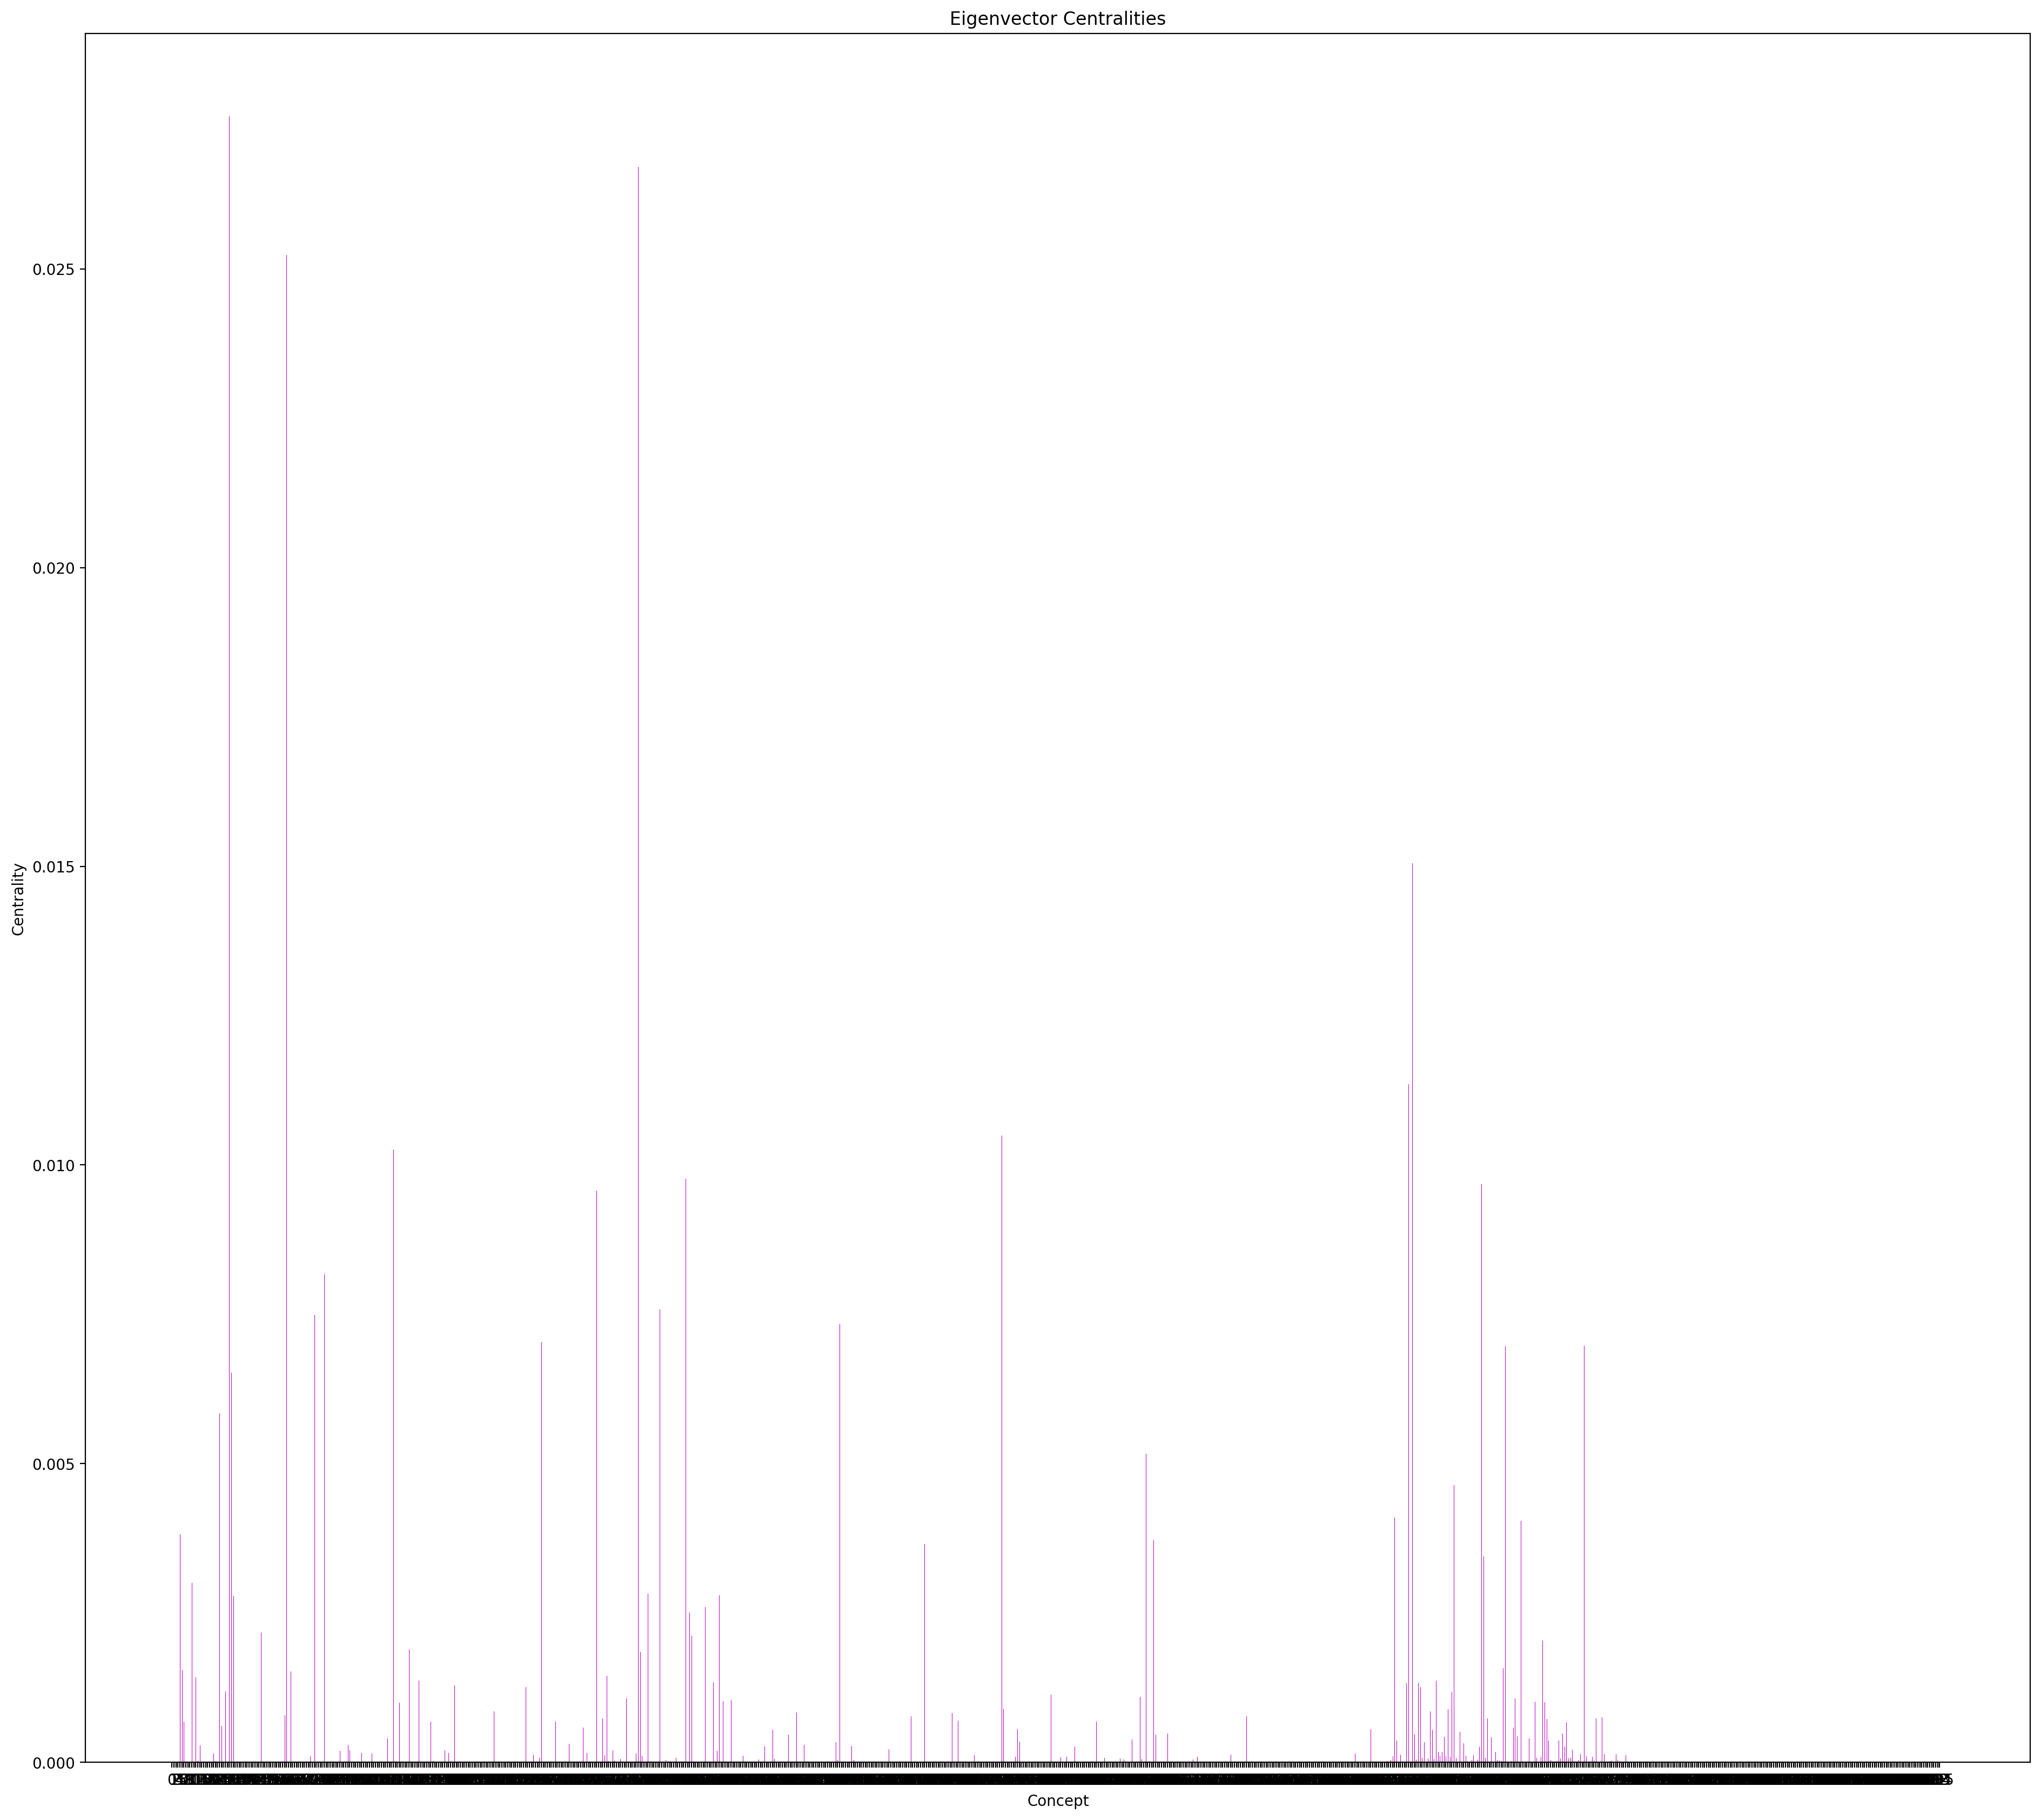

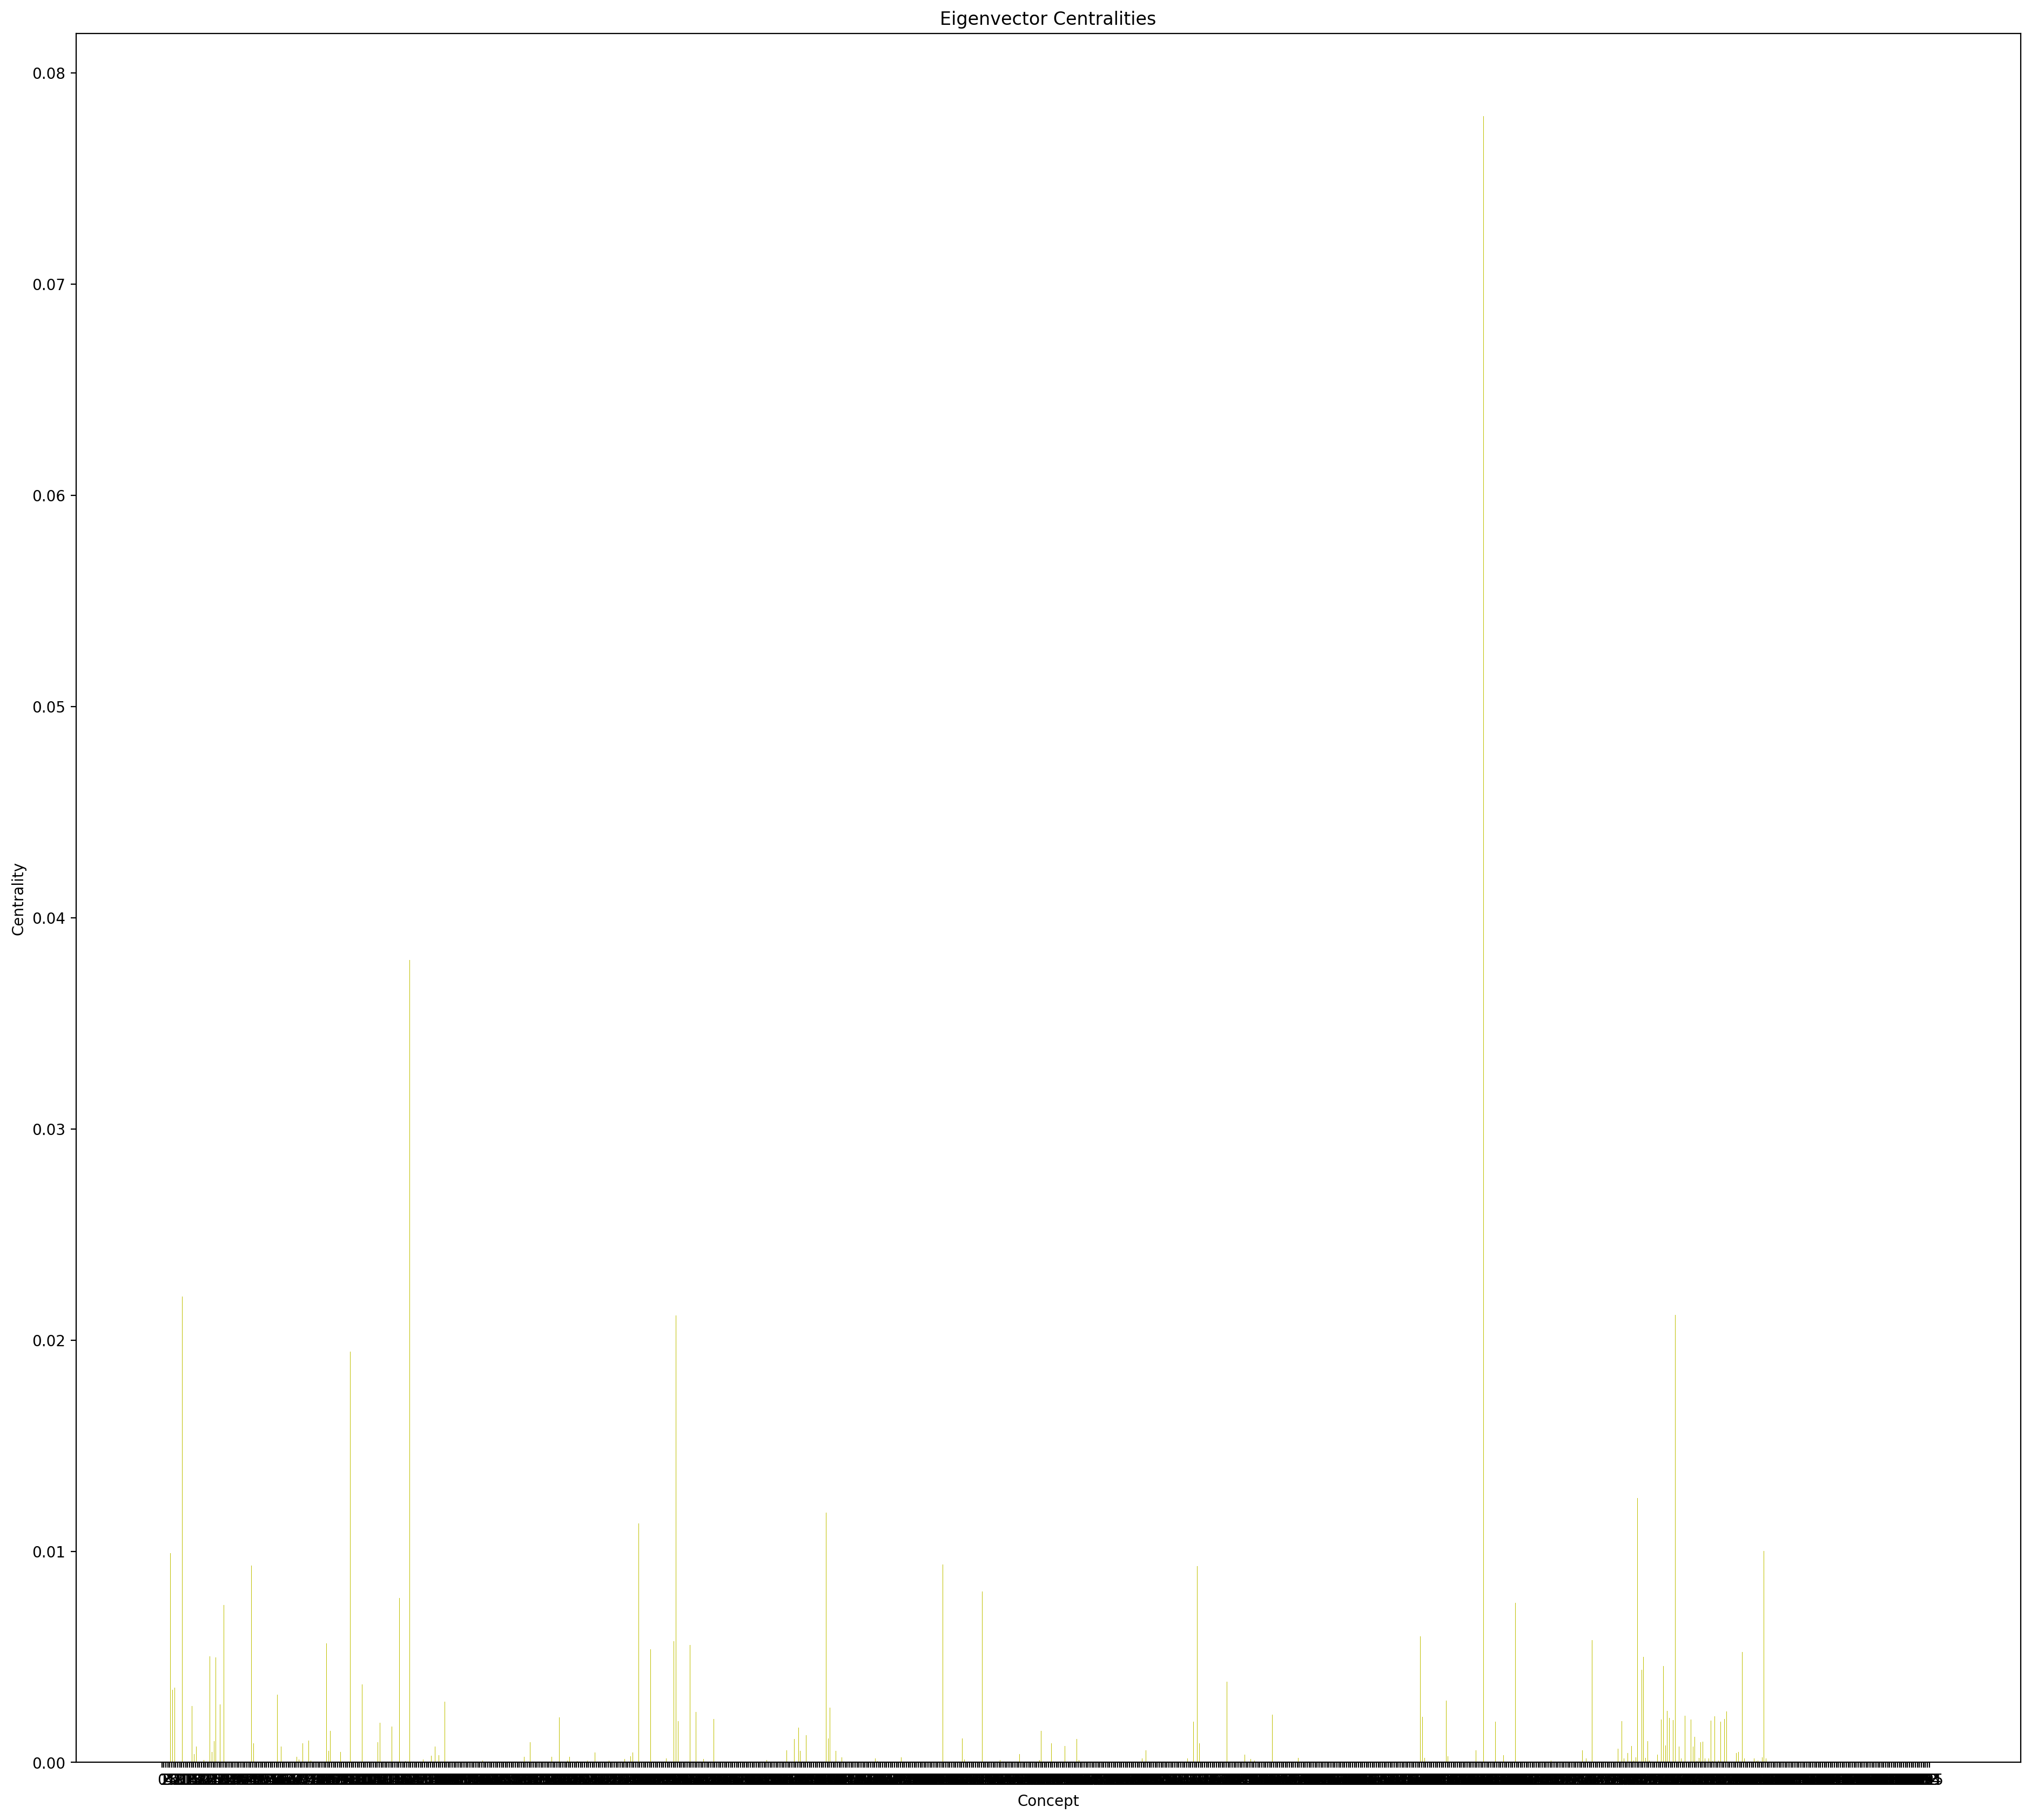

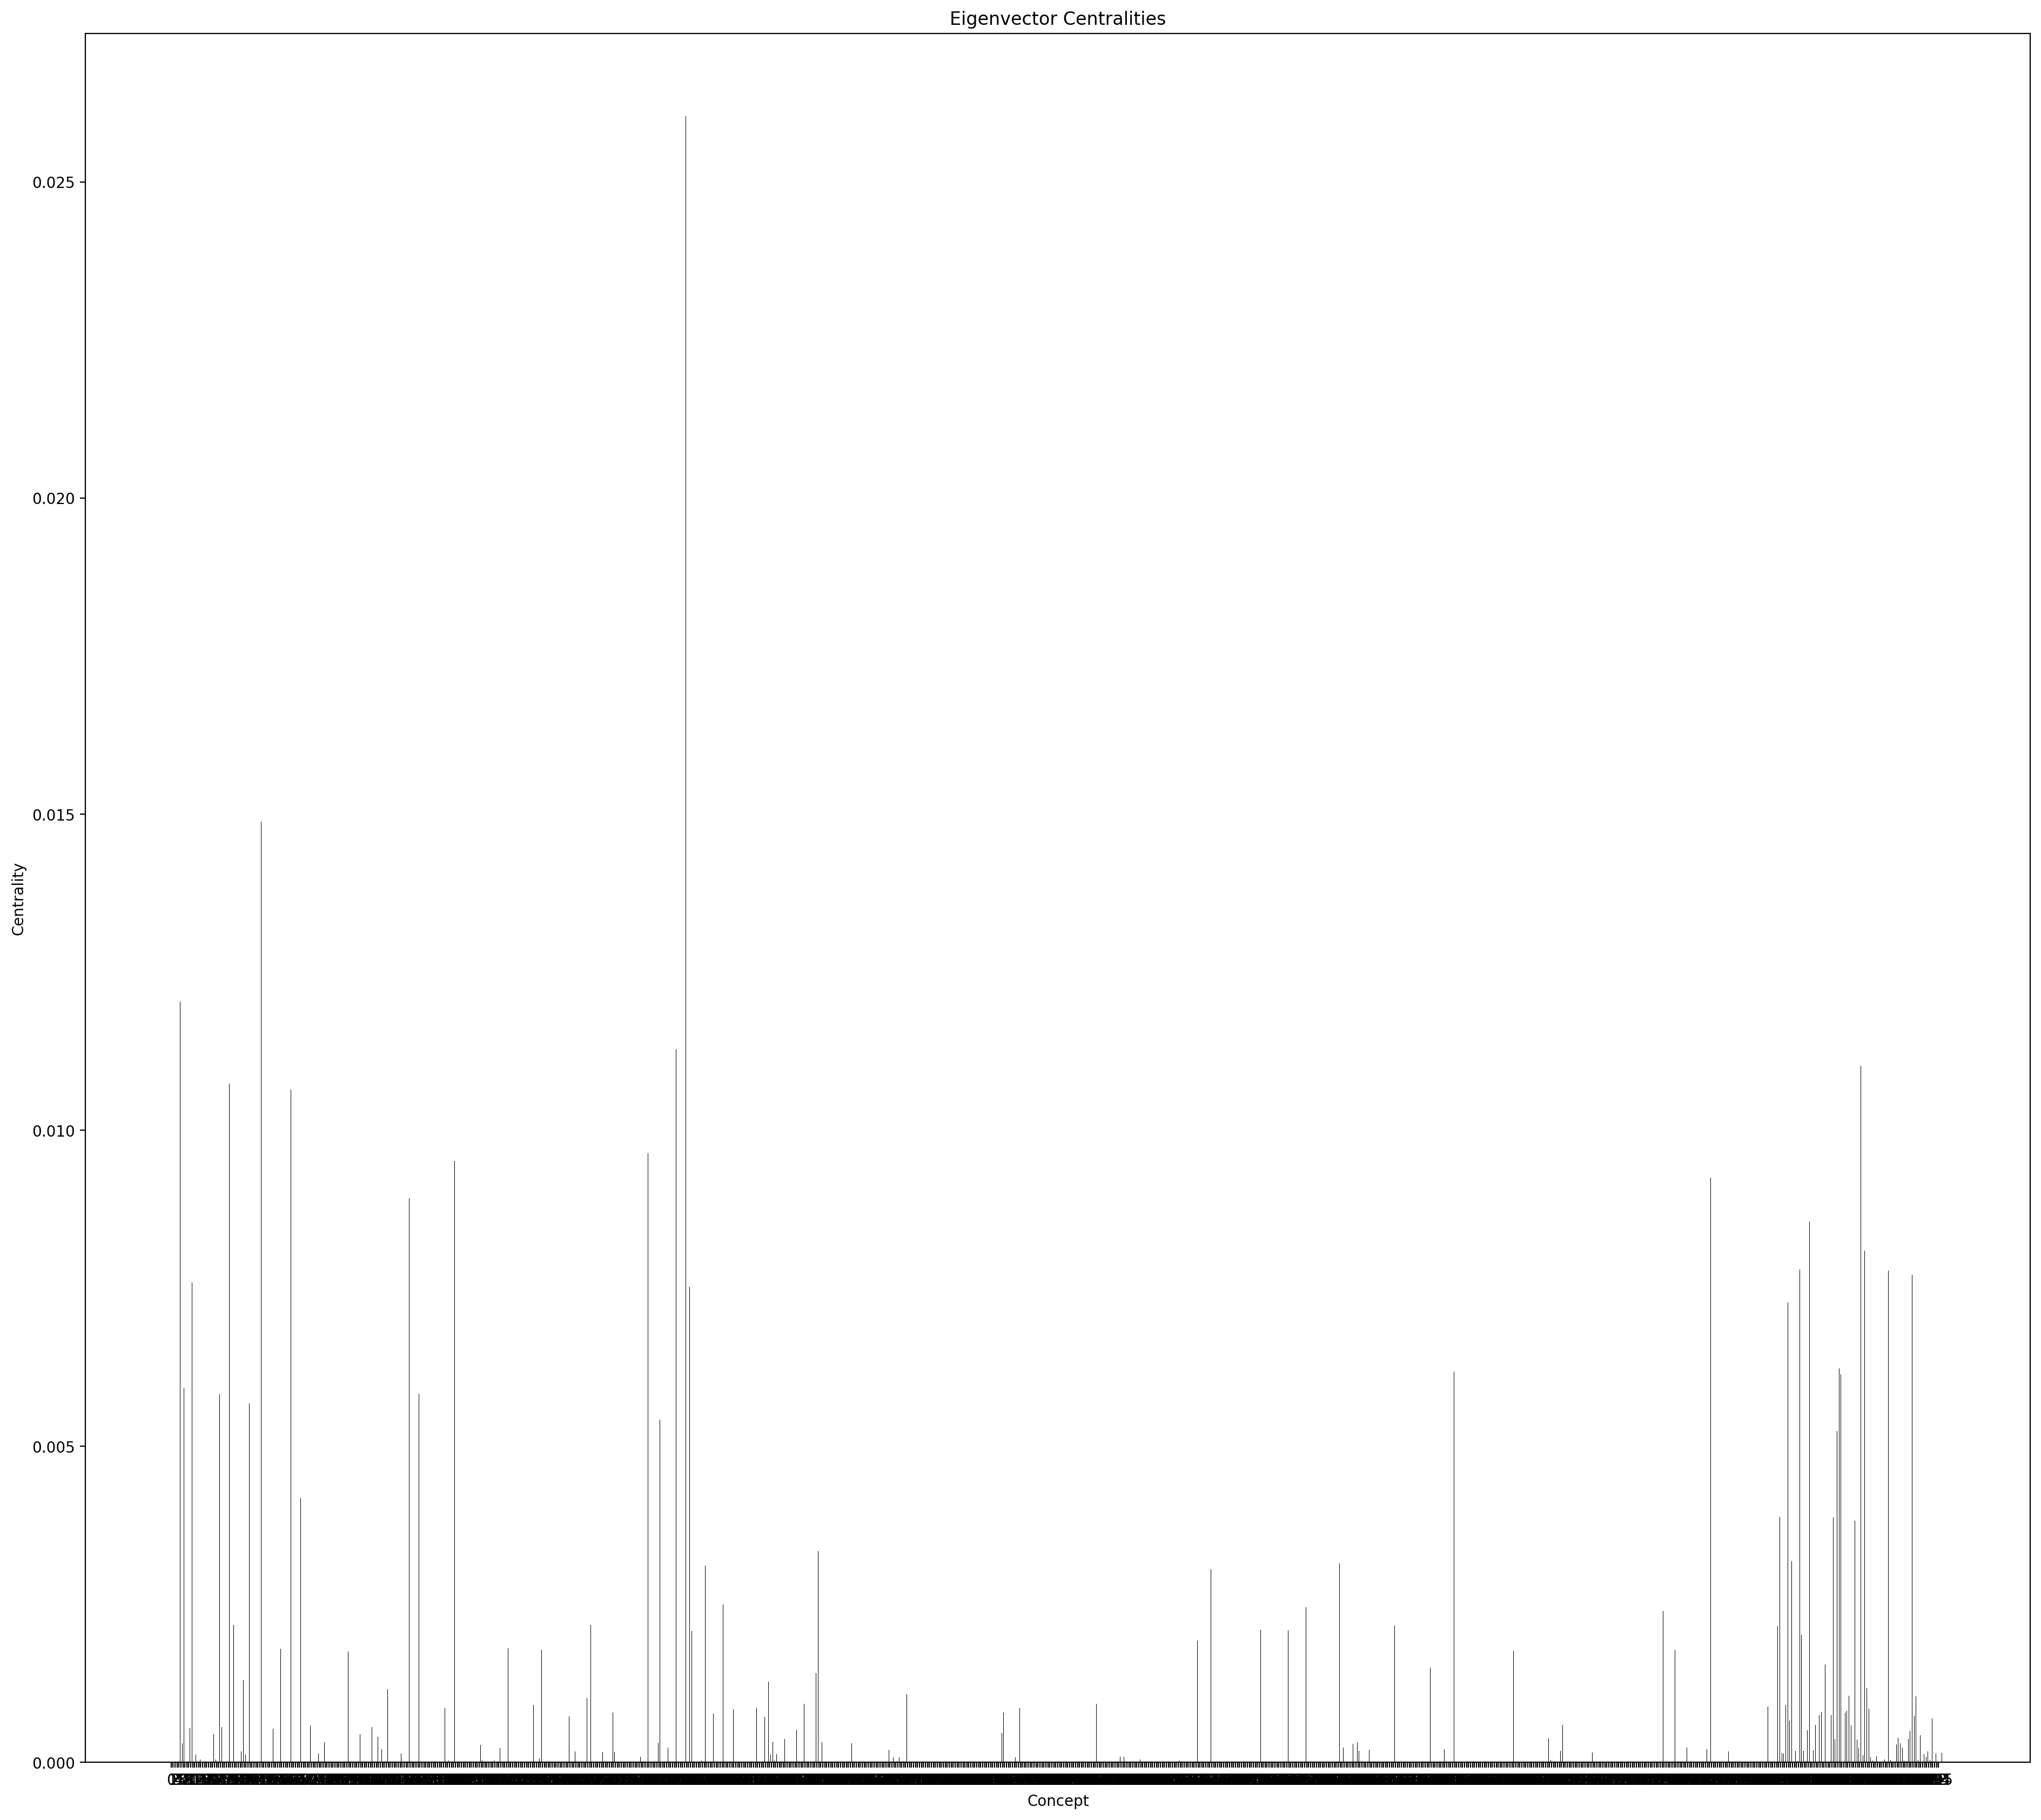

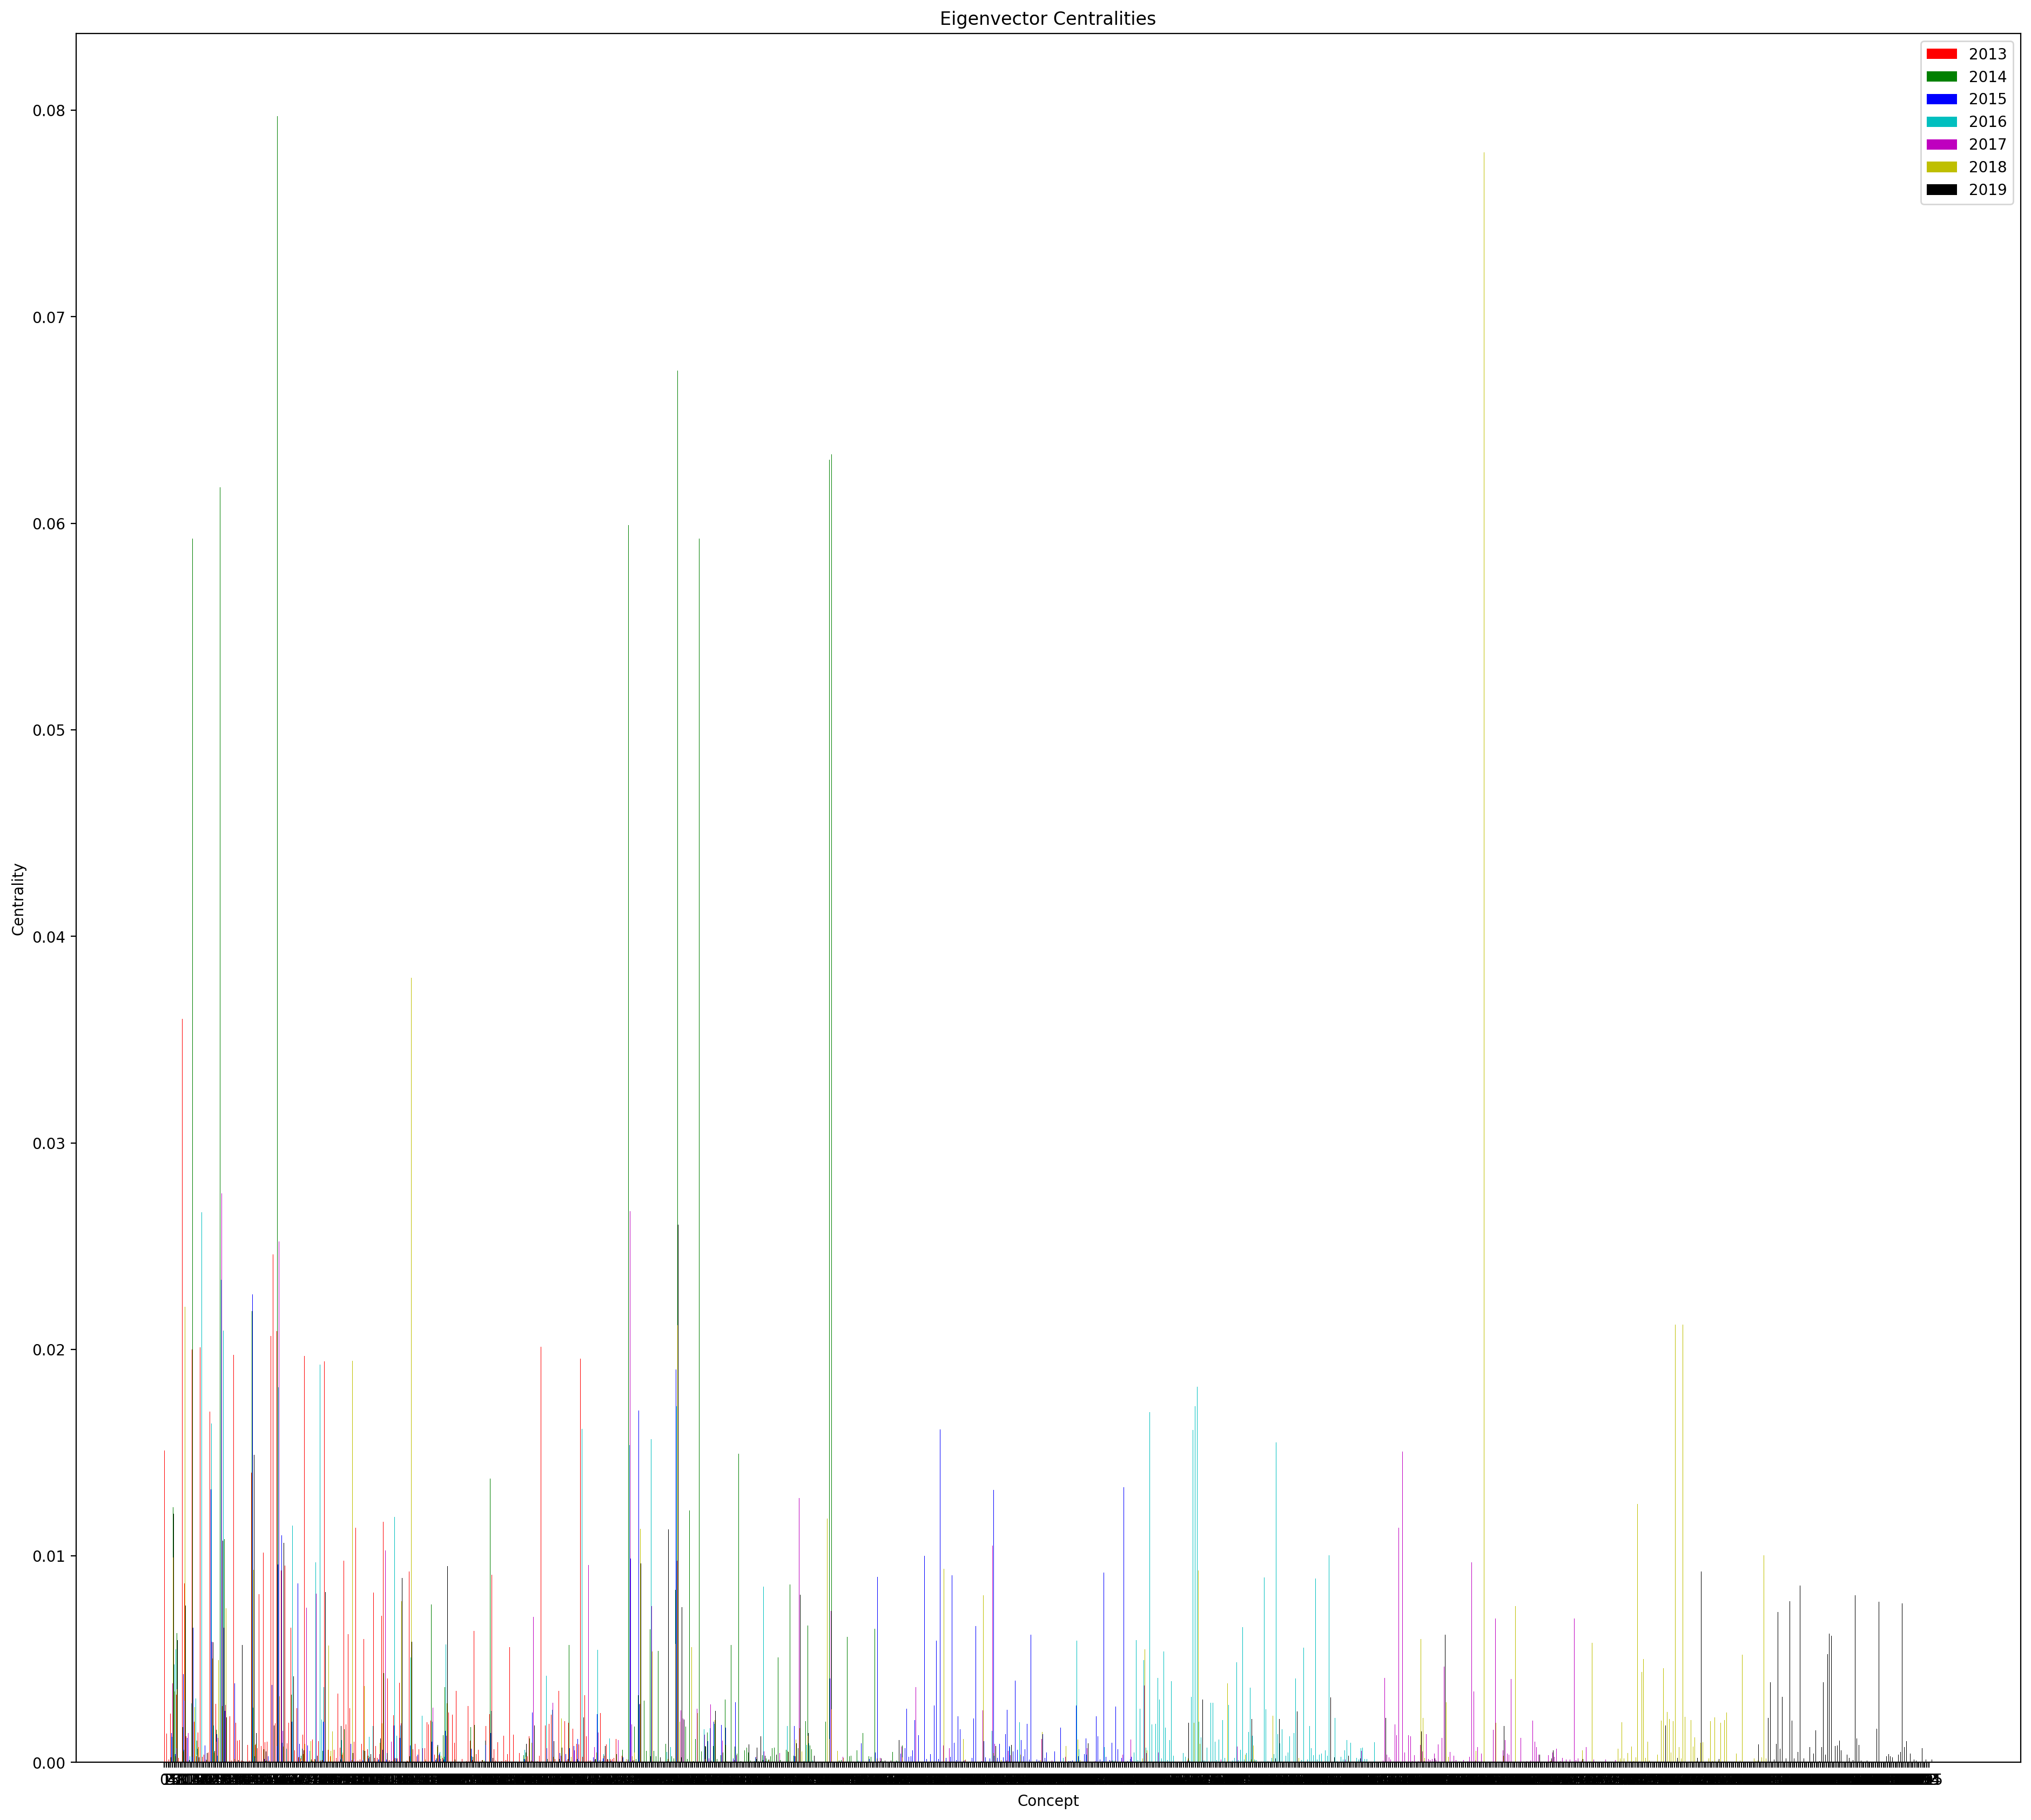

In [10]:
print('ALL EIGENVECTOR CENTRALITIES')
plot_all(eig_centrality, 'Eigenvector Centralities')

TOP EIGENVECTOR CENTRALITIES
96
{rdflib.term.URIRef('http://local/local.owl#ontology'): [0.035997819814834416, 0.0017084638943627595, 0.004268271600453972, 0.0006187338157498638, 0.0030037098737209617, 0.022057935716596776, 0.007591888144596695], rdflib.term.URIRef('http://local/local.owl#stream_data'): [0.02460486608805126, 0, 0, 0, 0, 0, 0], rdflib.term.URIRef('http://local/local.owl#rdf_data'): [0.022299687864484823, 0.06175072283184587, 0, 0.023369386036925593, 0.027556501902121486, 0.0027433223509468947, 0.010735144291855592], rdflib.term.URIRef('http://local/local.owl#linked_data'): [0.020890871241724212, 0.07972089043046268, 0.009577445147646503, 0.018164857125252443, 0.025226677095369198, 0.0032125133208457685, 0], rdflib.term.URIRef('http://local/local.owl#scholarly_data'): [0.020662575684410094, 0, 0.003742161306580371, 0, 0, 0, 0.0018007719826725443], rdflib.term.URIRef('http://local/local.owl#rdfs_data'): [0.02012433026671077, 0, 0, 0, 0, 0, 0], rdflib.term.URIRef('http://l

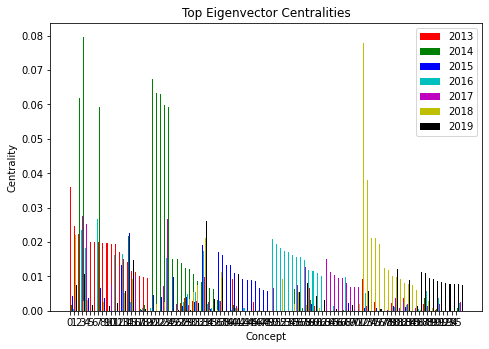

In [11]:
print('TOP EIGENVECTOR CENTRALITIES')
print(len(top_eig_centrality))
print(top_eig_centrality)
plot_combined(top_eig_centrality, 'Top Eigenvector Centralities')

EIGENVECTOR CENTRALITY GRAPH EXAMPLES
Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2013:


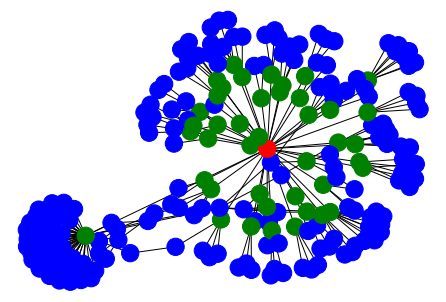

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2014:


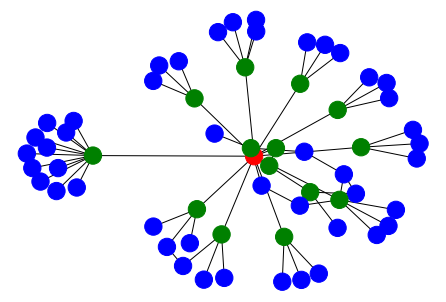

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2015:


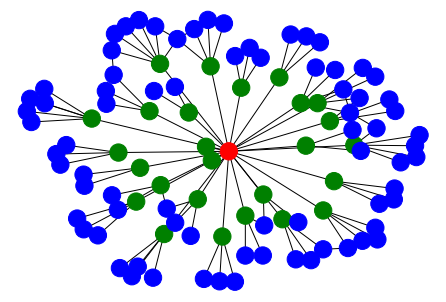

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2016:


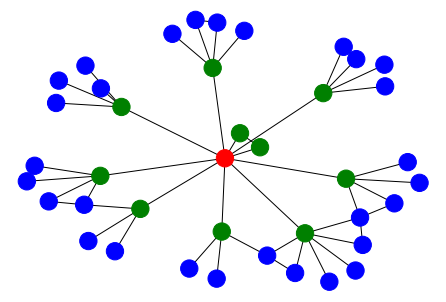

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2017:


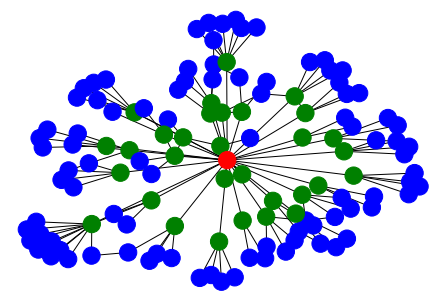

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2018:


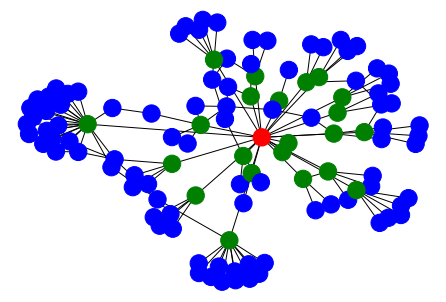

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2019:


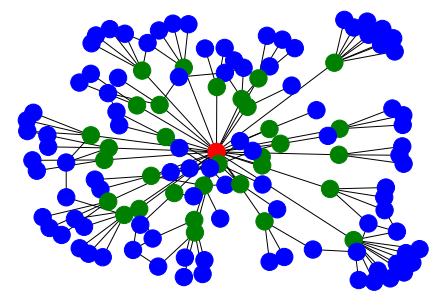

In [12]:
print('EIGENVECTOR CENTRALITY GRAPH EXAMPLES')
for curr_year in nxgs.keys():
    for key in top_eig_centrality.keys():
        if key.endswith('#ontology'):
            draw_subgraph(curr_year, key, neighborhood_level=2)
            break

In [13]:
bet_centrality, top_bet_centrality = get_centrality(nx.betweenness_centrality)

Top 20 values for 2013
 - http://local/local.owl#ontology: 0.052330550798693524 -- ref: https://cso.kmi.open.ac.uk/topics/ontology
 - http://local/local.owl#semantic: 0.019342858381081723 -- ref: https://cso.kmi.open.ac.uk/topics/semantics
 - http://local/local.owl#rdf: 0.015023350962028639 -- ref: https://cso.kmi.open.ac.uk/topics/rdf
 - http://local/local.owl#semantic_web: 0.0143719297477797 -- ref: https://cso.kmi.open.ac.uk/topics/semantic_web
 - http://local/local.owl#query_processing: 0.009071030931085262 -- ref: https://cso.kmi.open.ac.uk/topics/query_processing
 - http://local/local.owl#owl: 0.005937201983708314 -- ref: https://cso.kmi.open.ac.uk/topics/owl
 - http://local/local.owl#linked_data: 0.005649244340141072 -- ref: https://cso.kmi.open.ac.uk/topics/linked_data
 - http://local/local.owl#dbpedia: 0.005587635053908057 -- ref: https://cso.kmi.open.ac.uk/topics/dbpedia
 - http://local/local.owl#inference: 0.004886602327043261 -- ref: https://cso.kmi.open.ac.uk/topics/infere

ALL BETWEENNESS CENTRALITIES


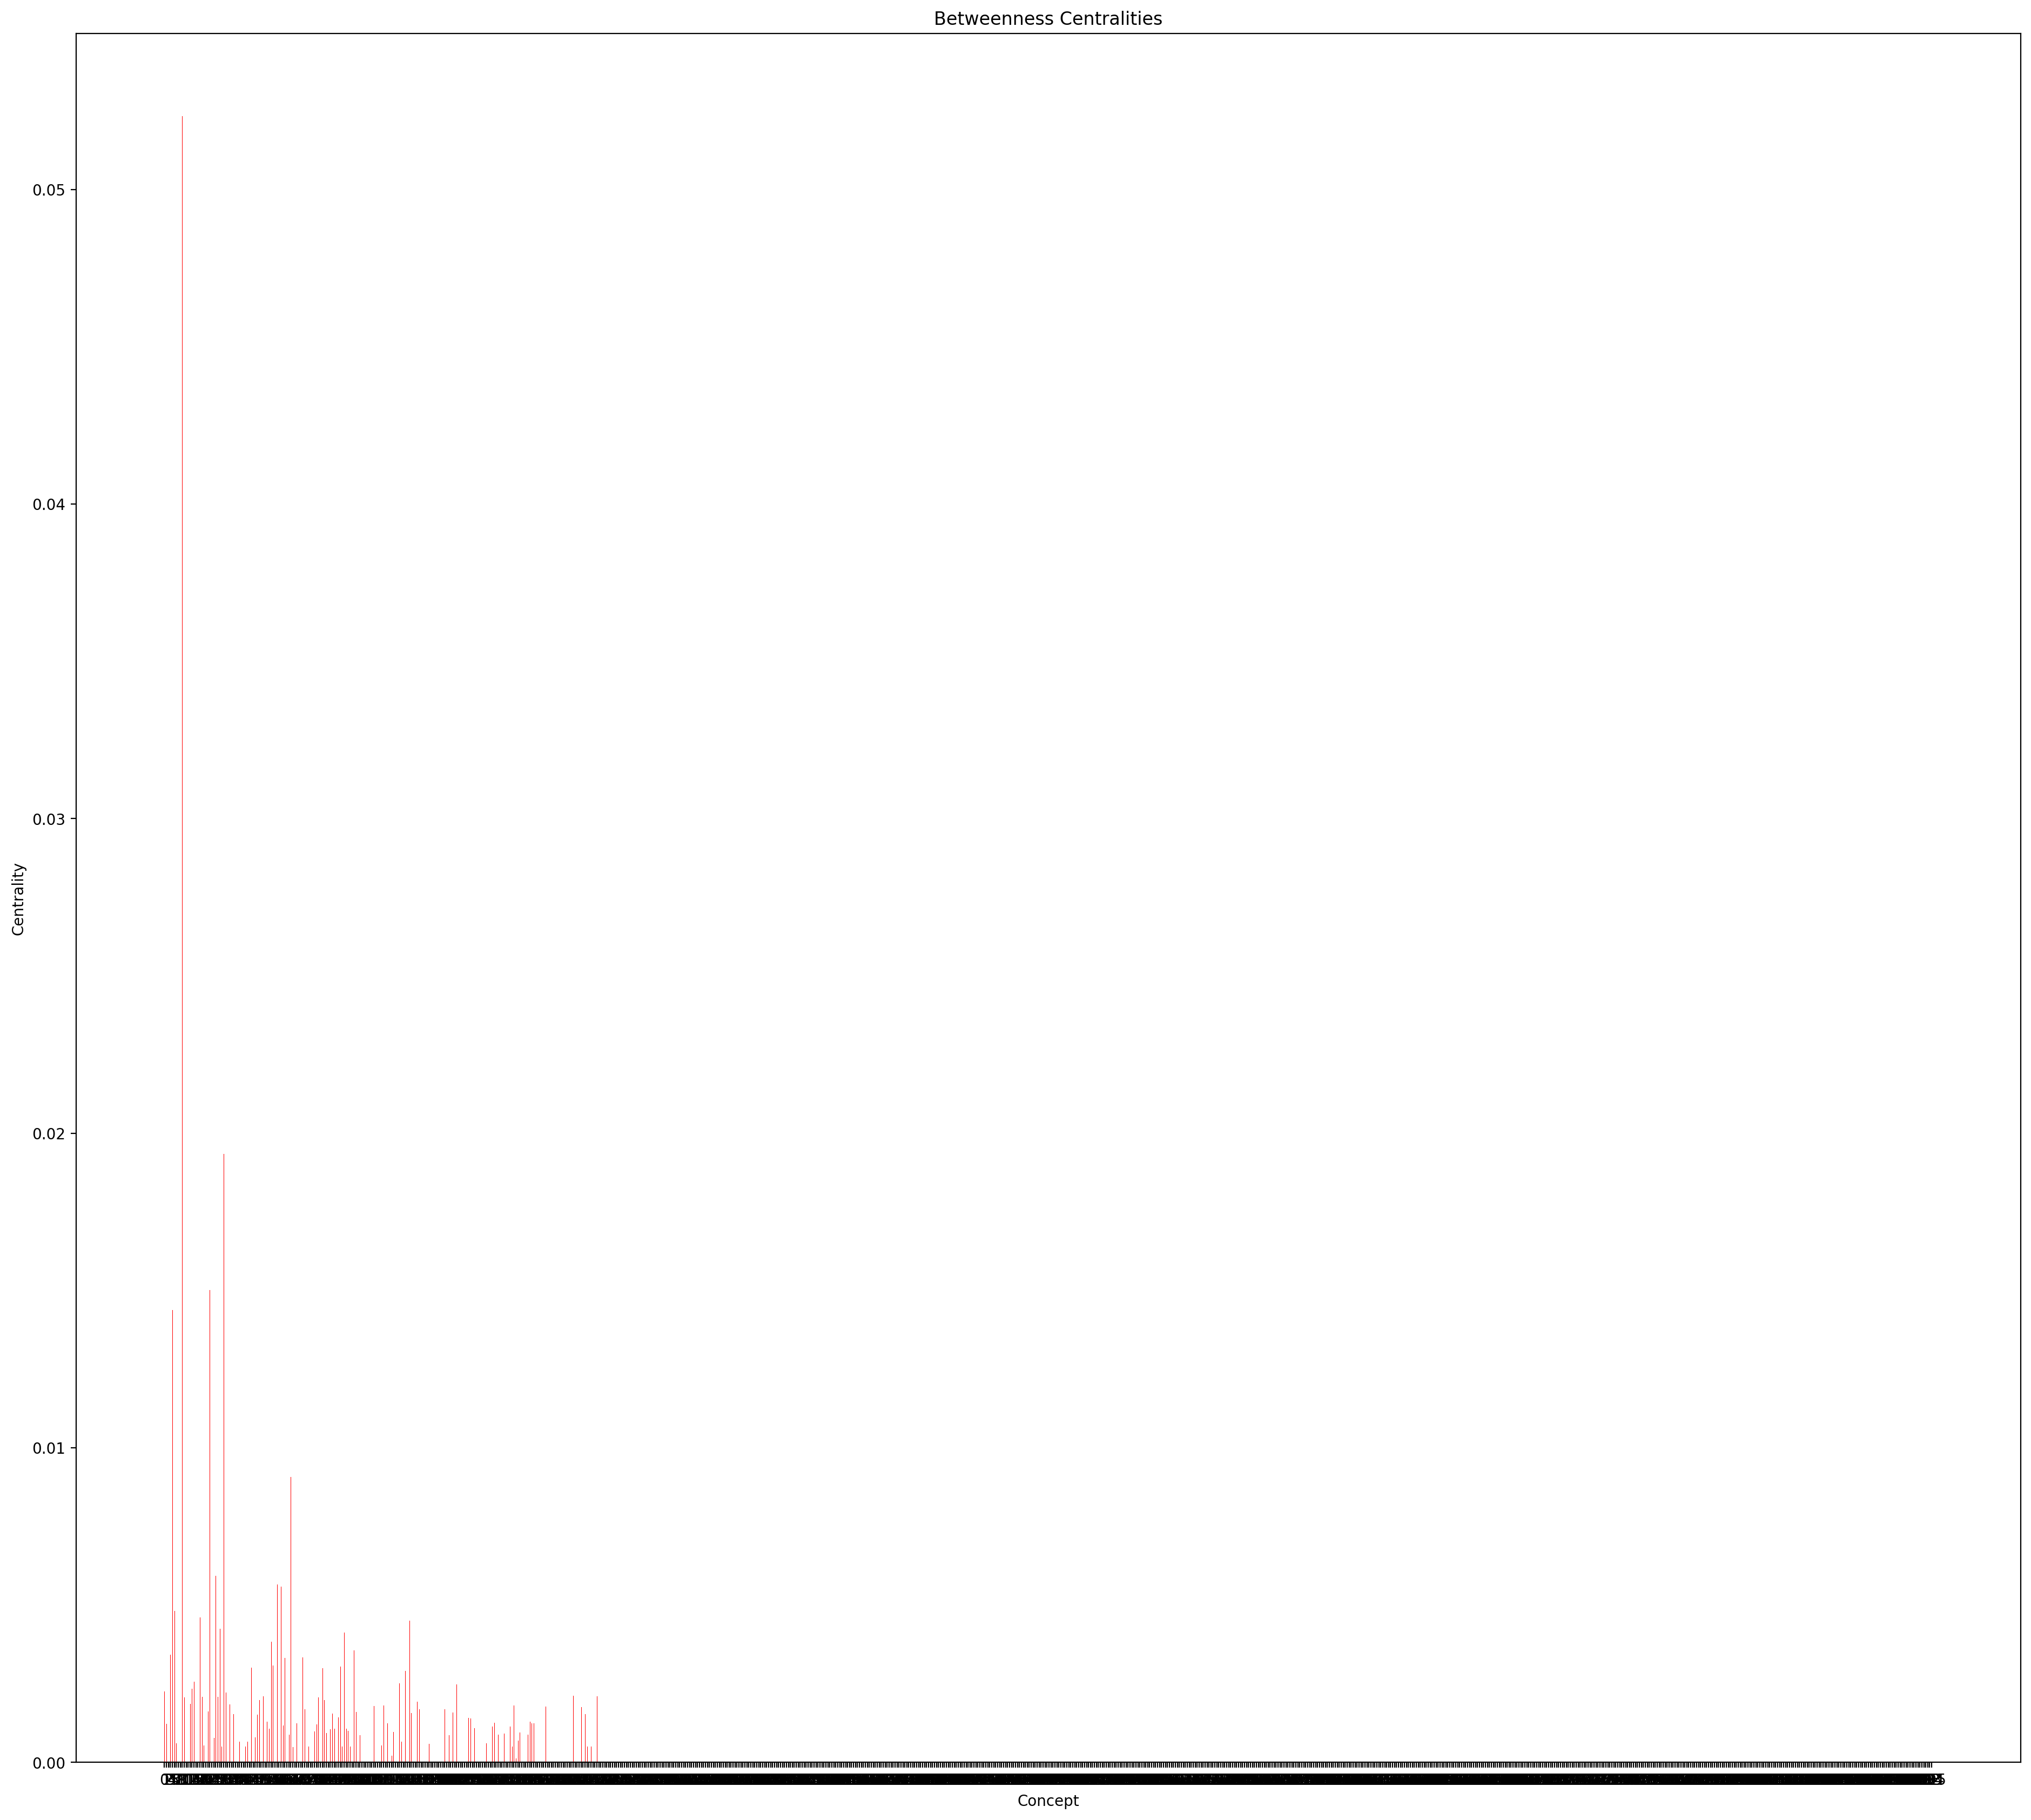

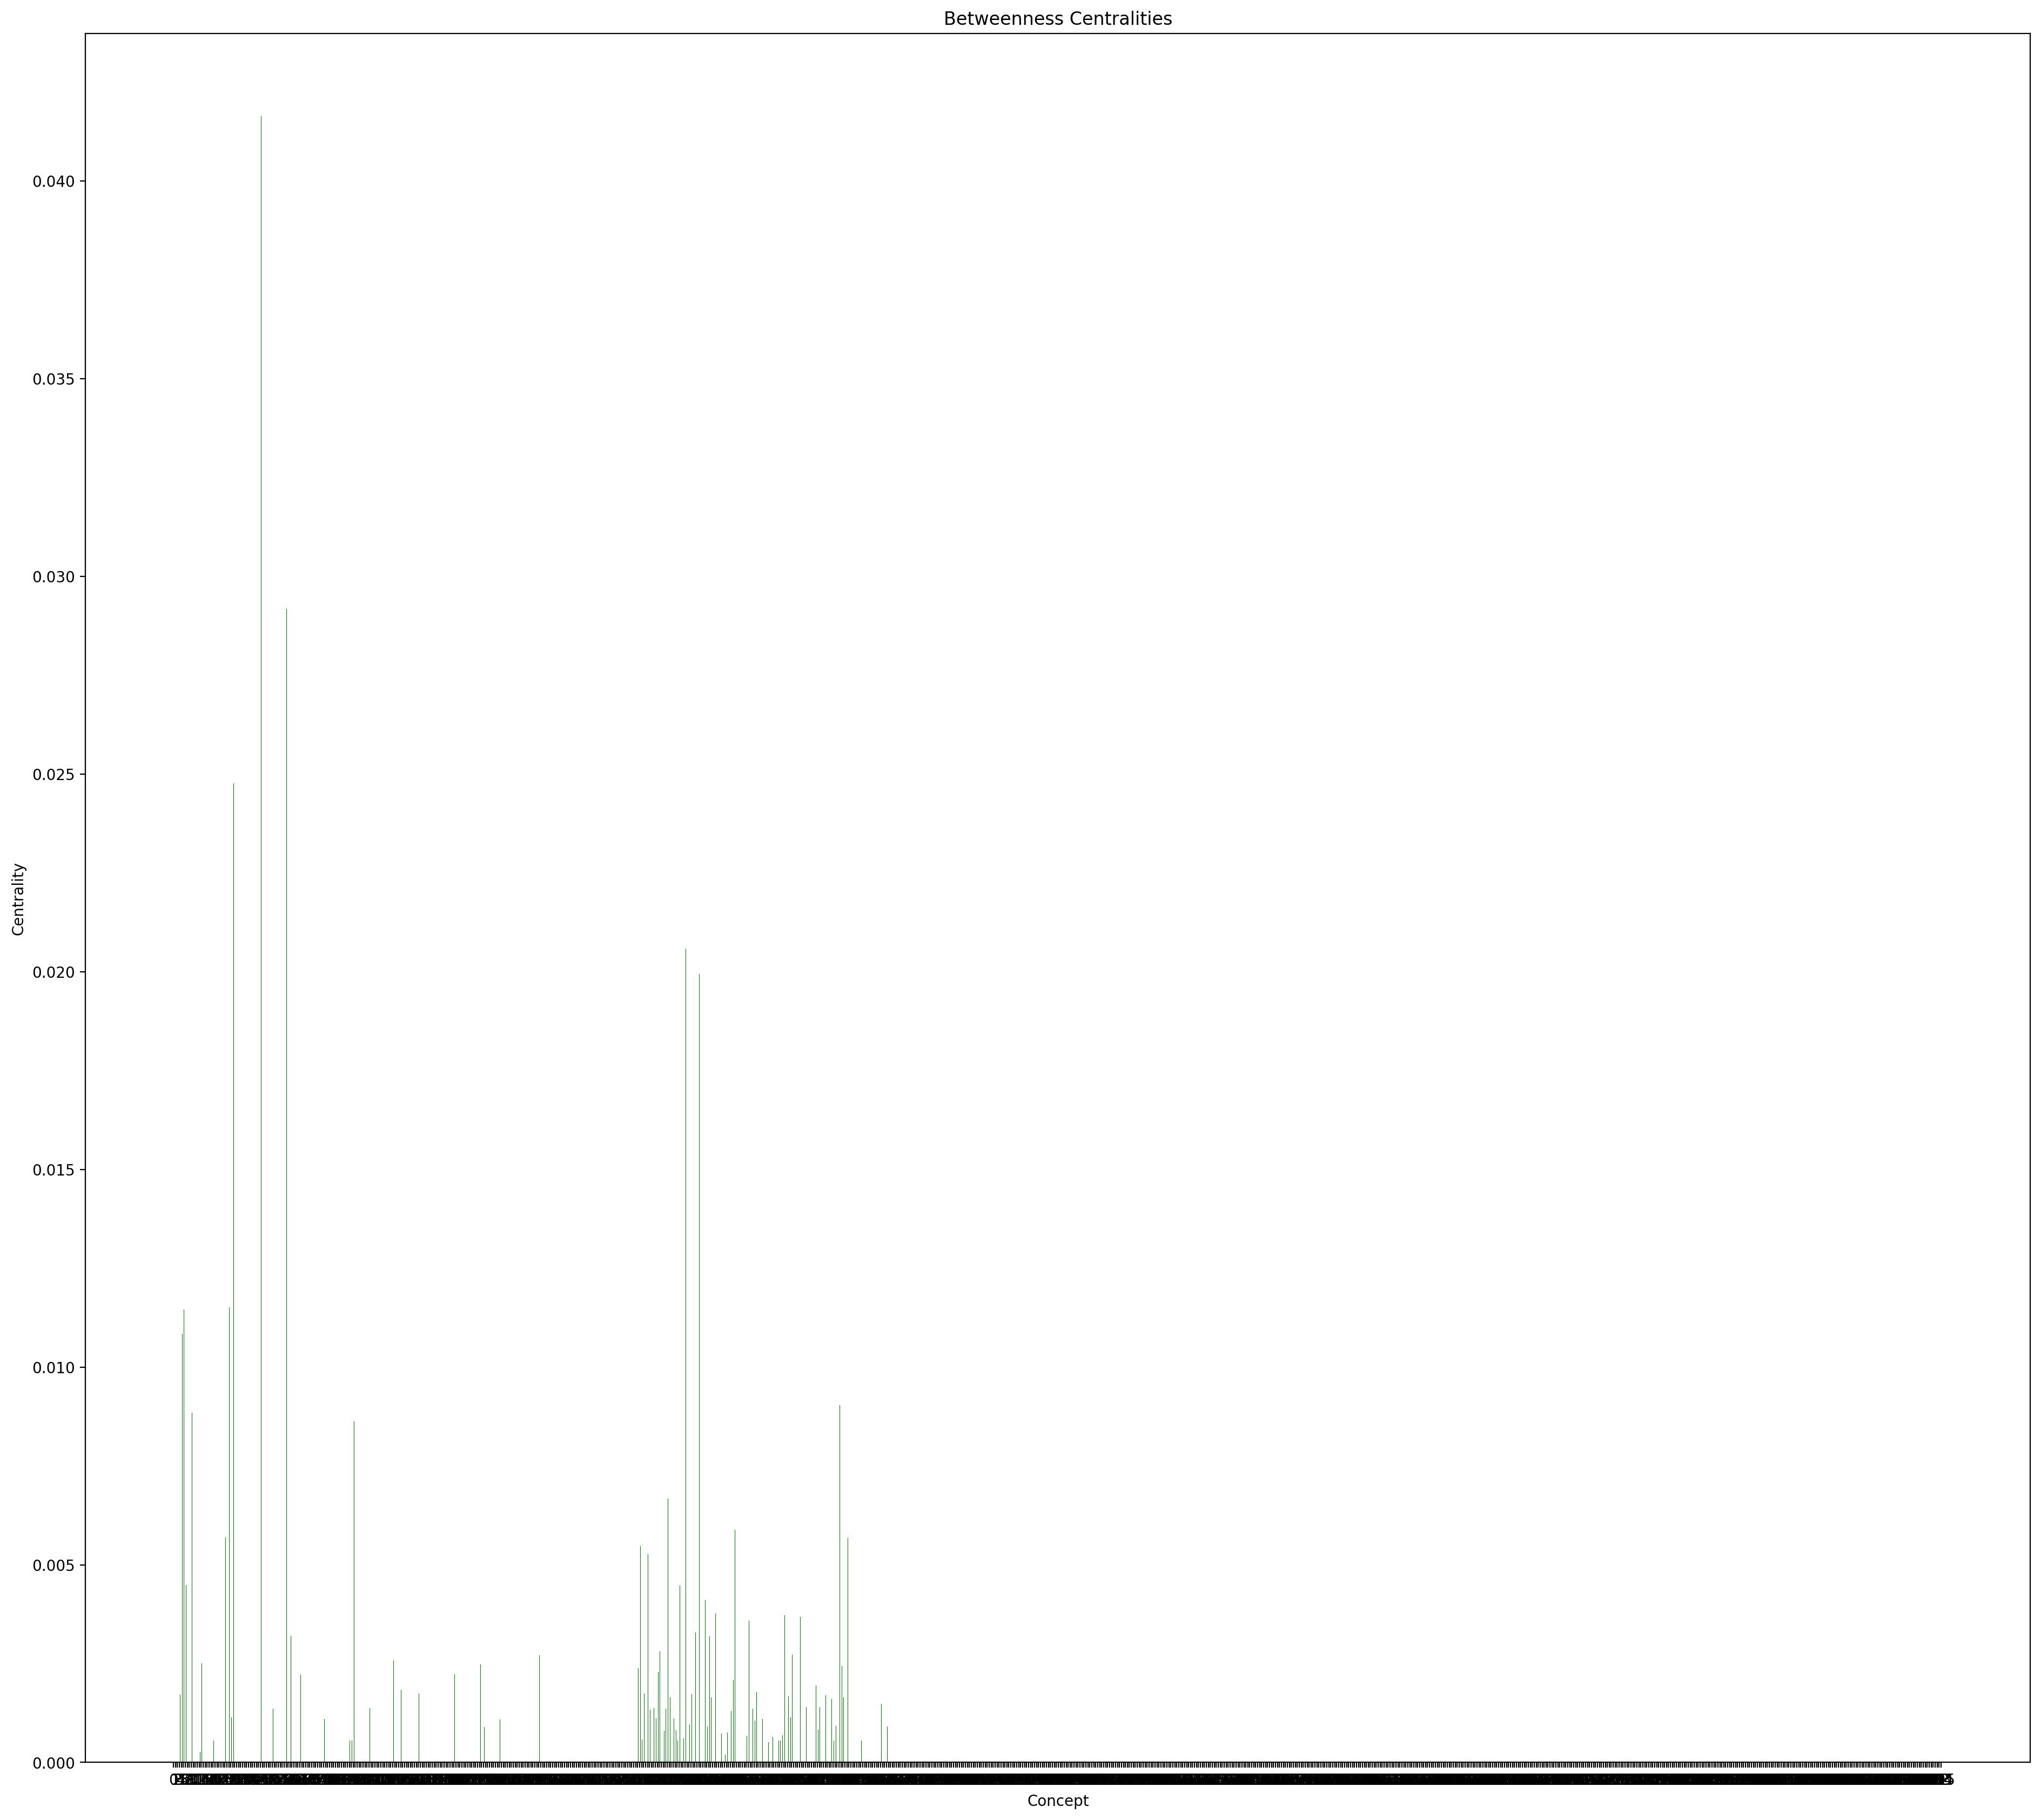

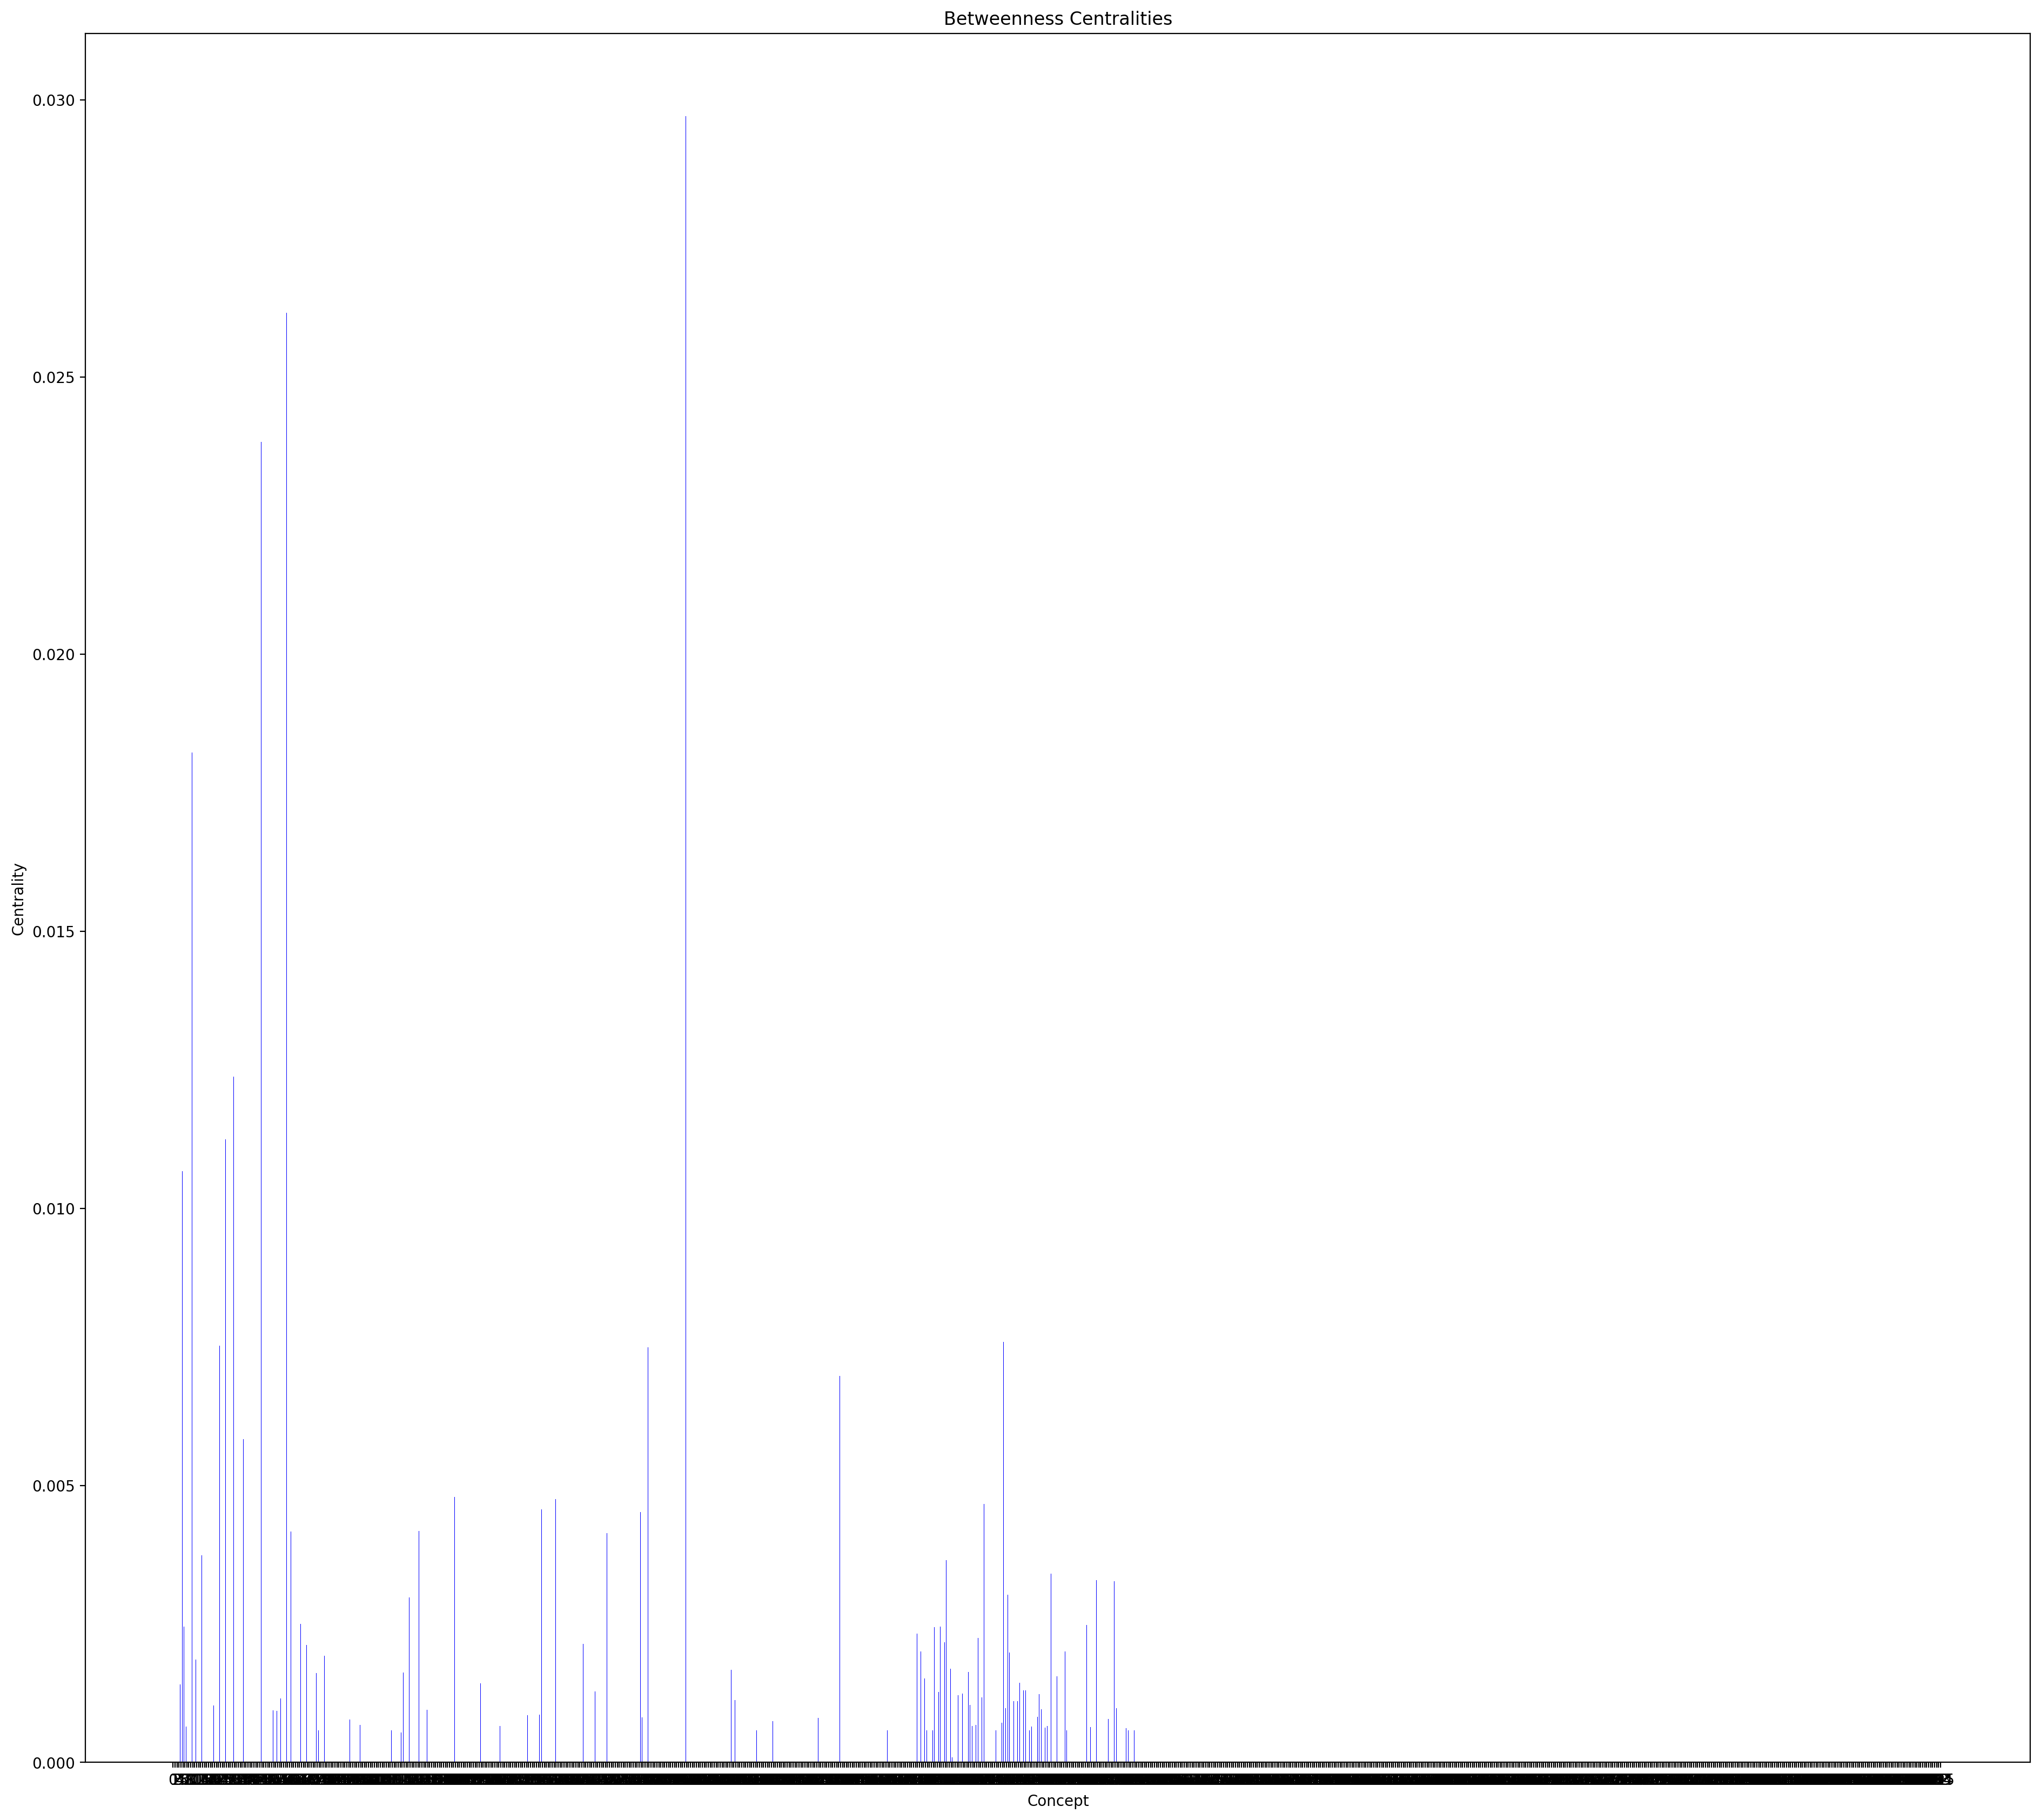

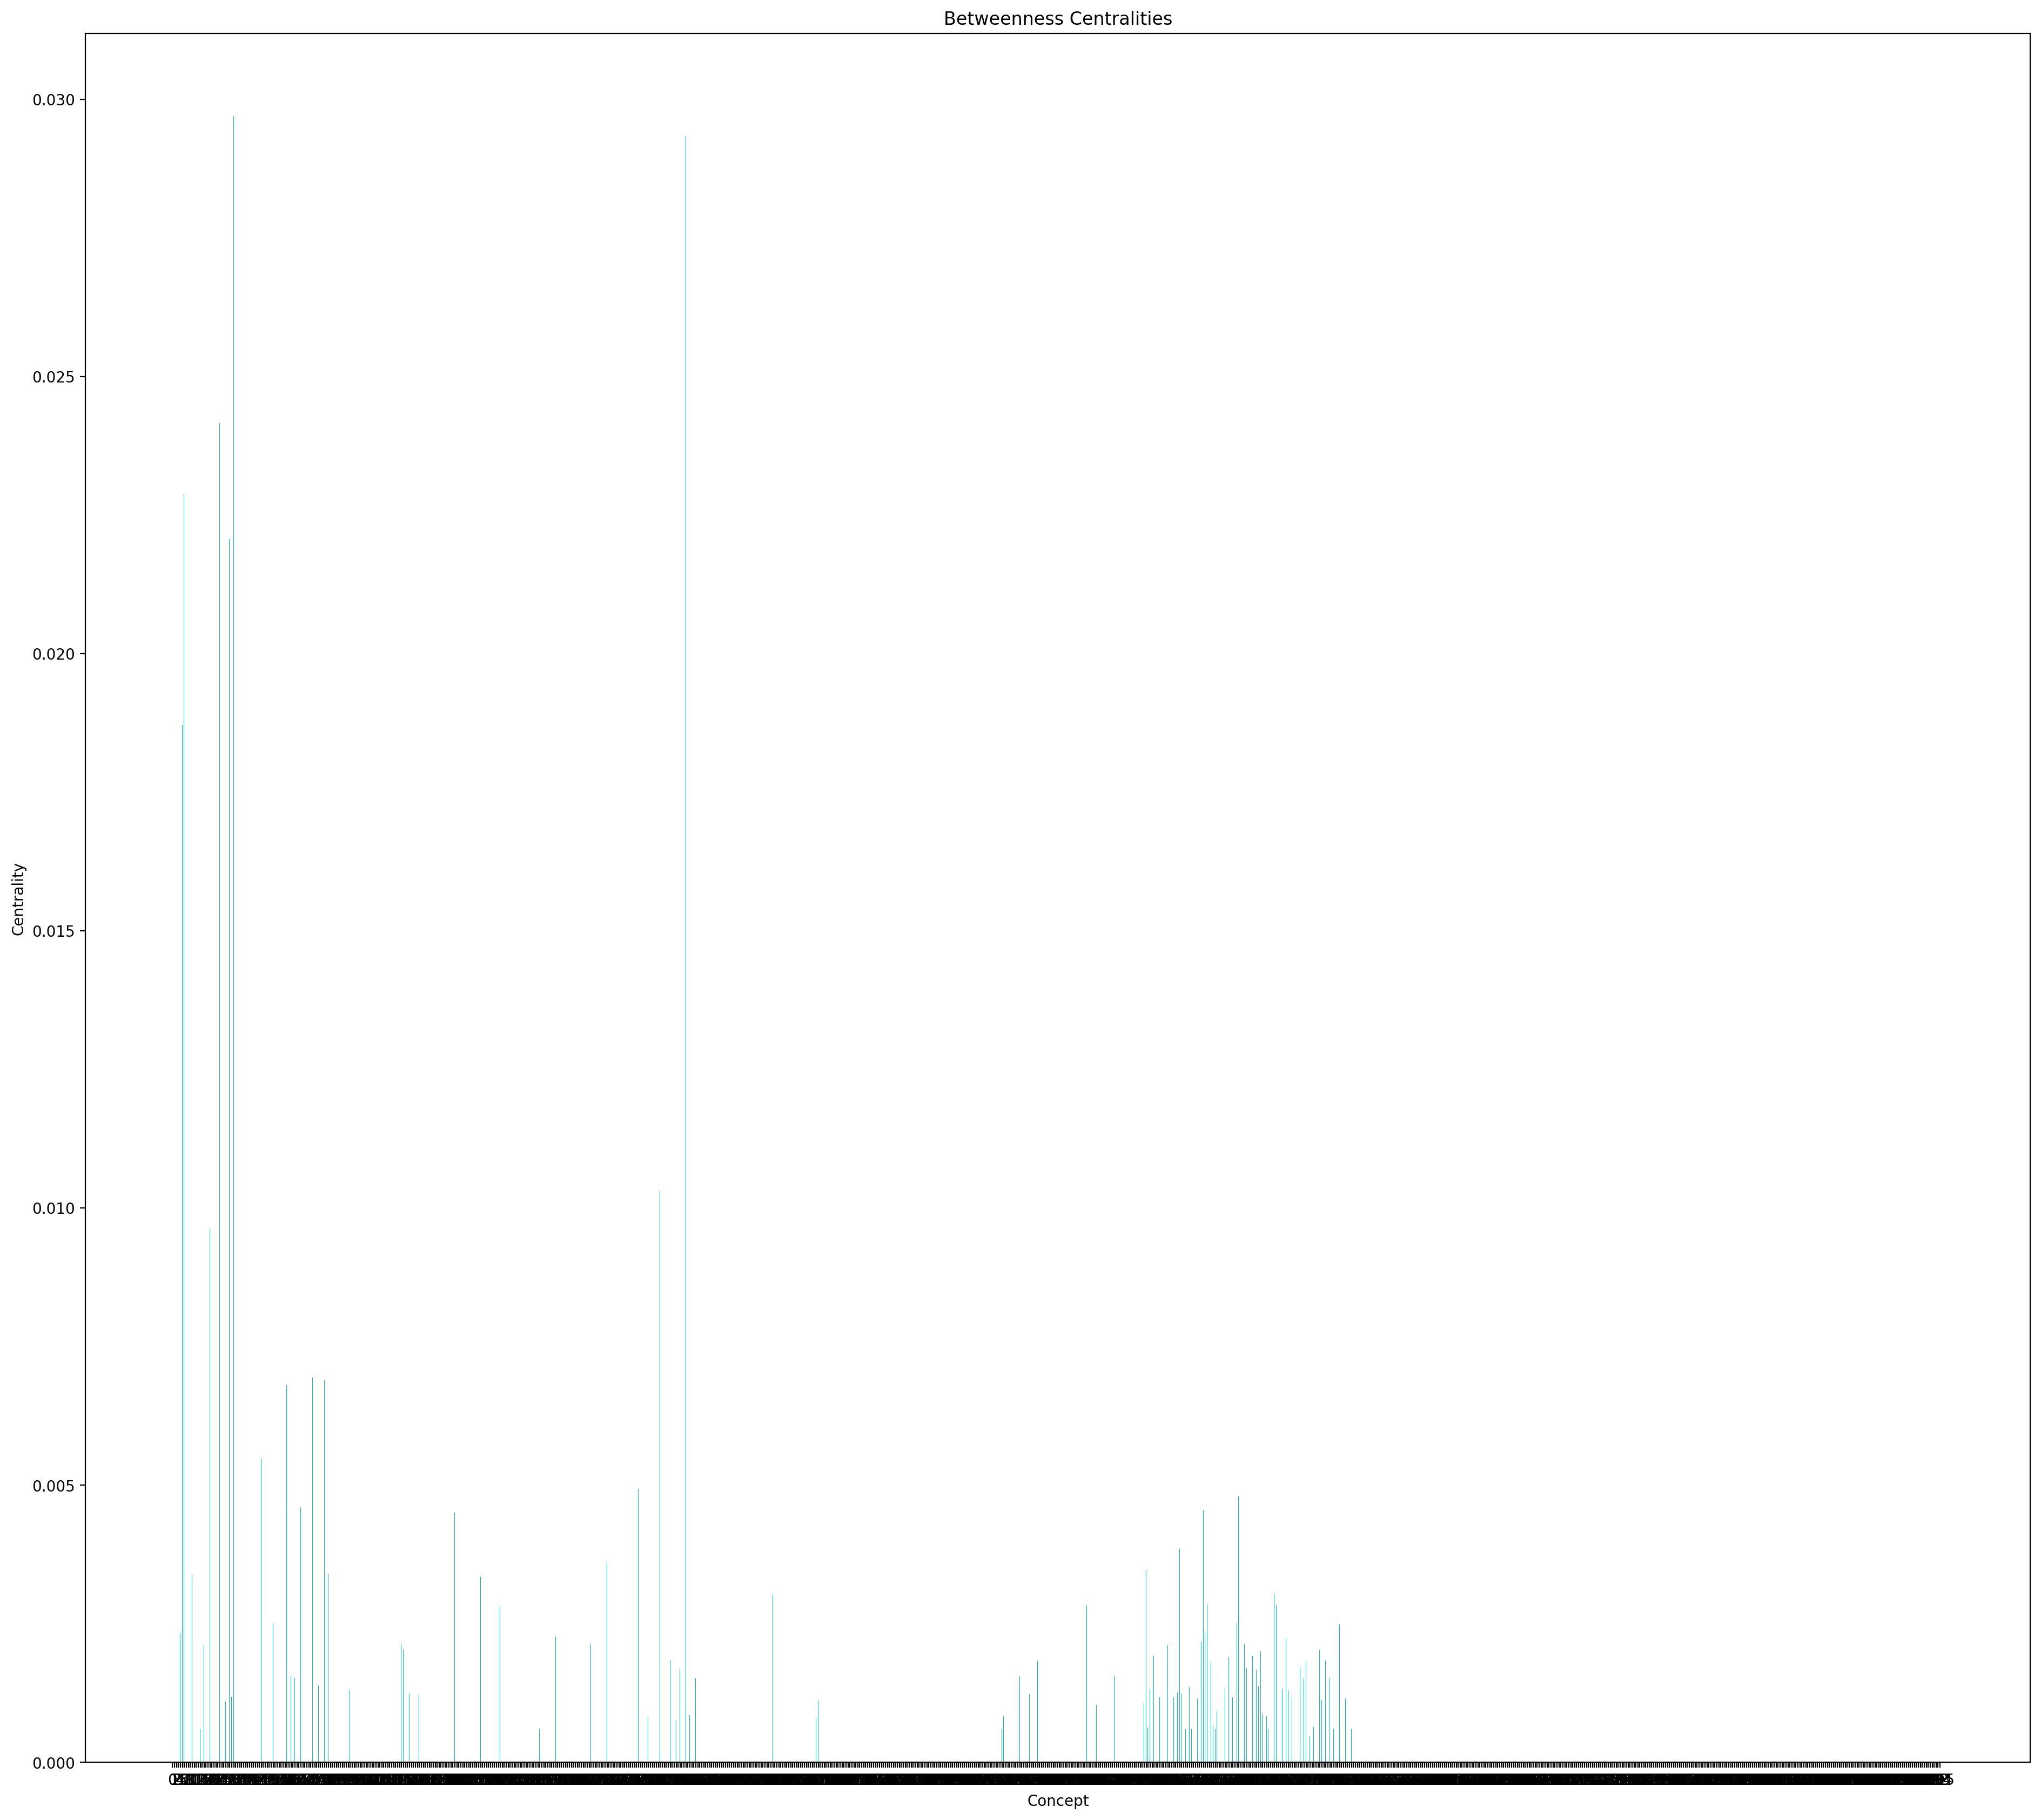

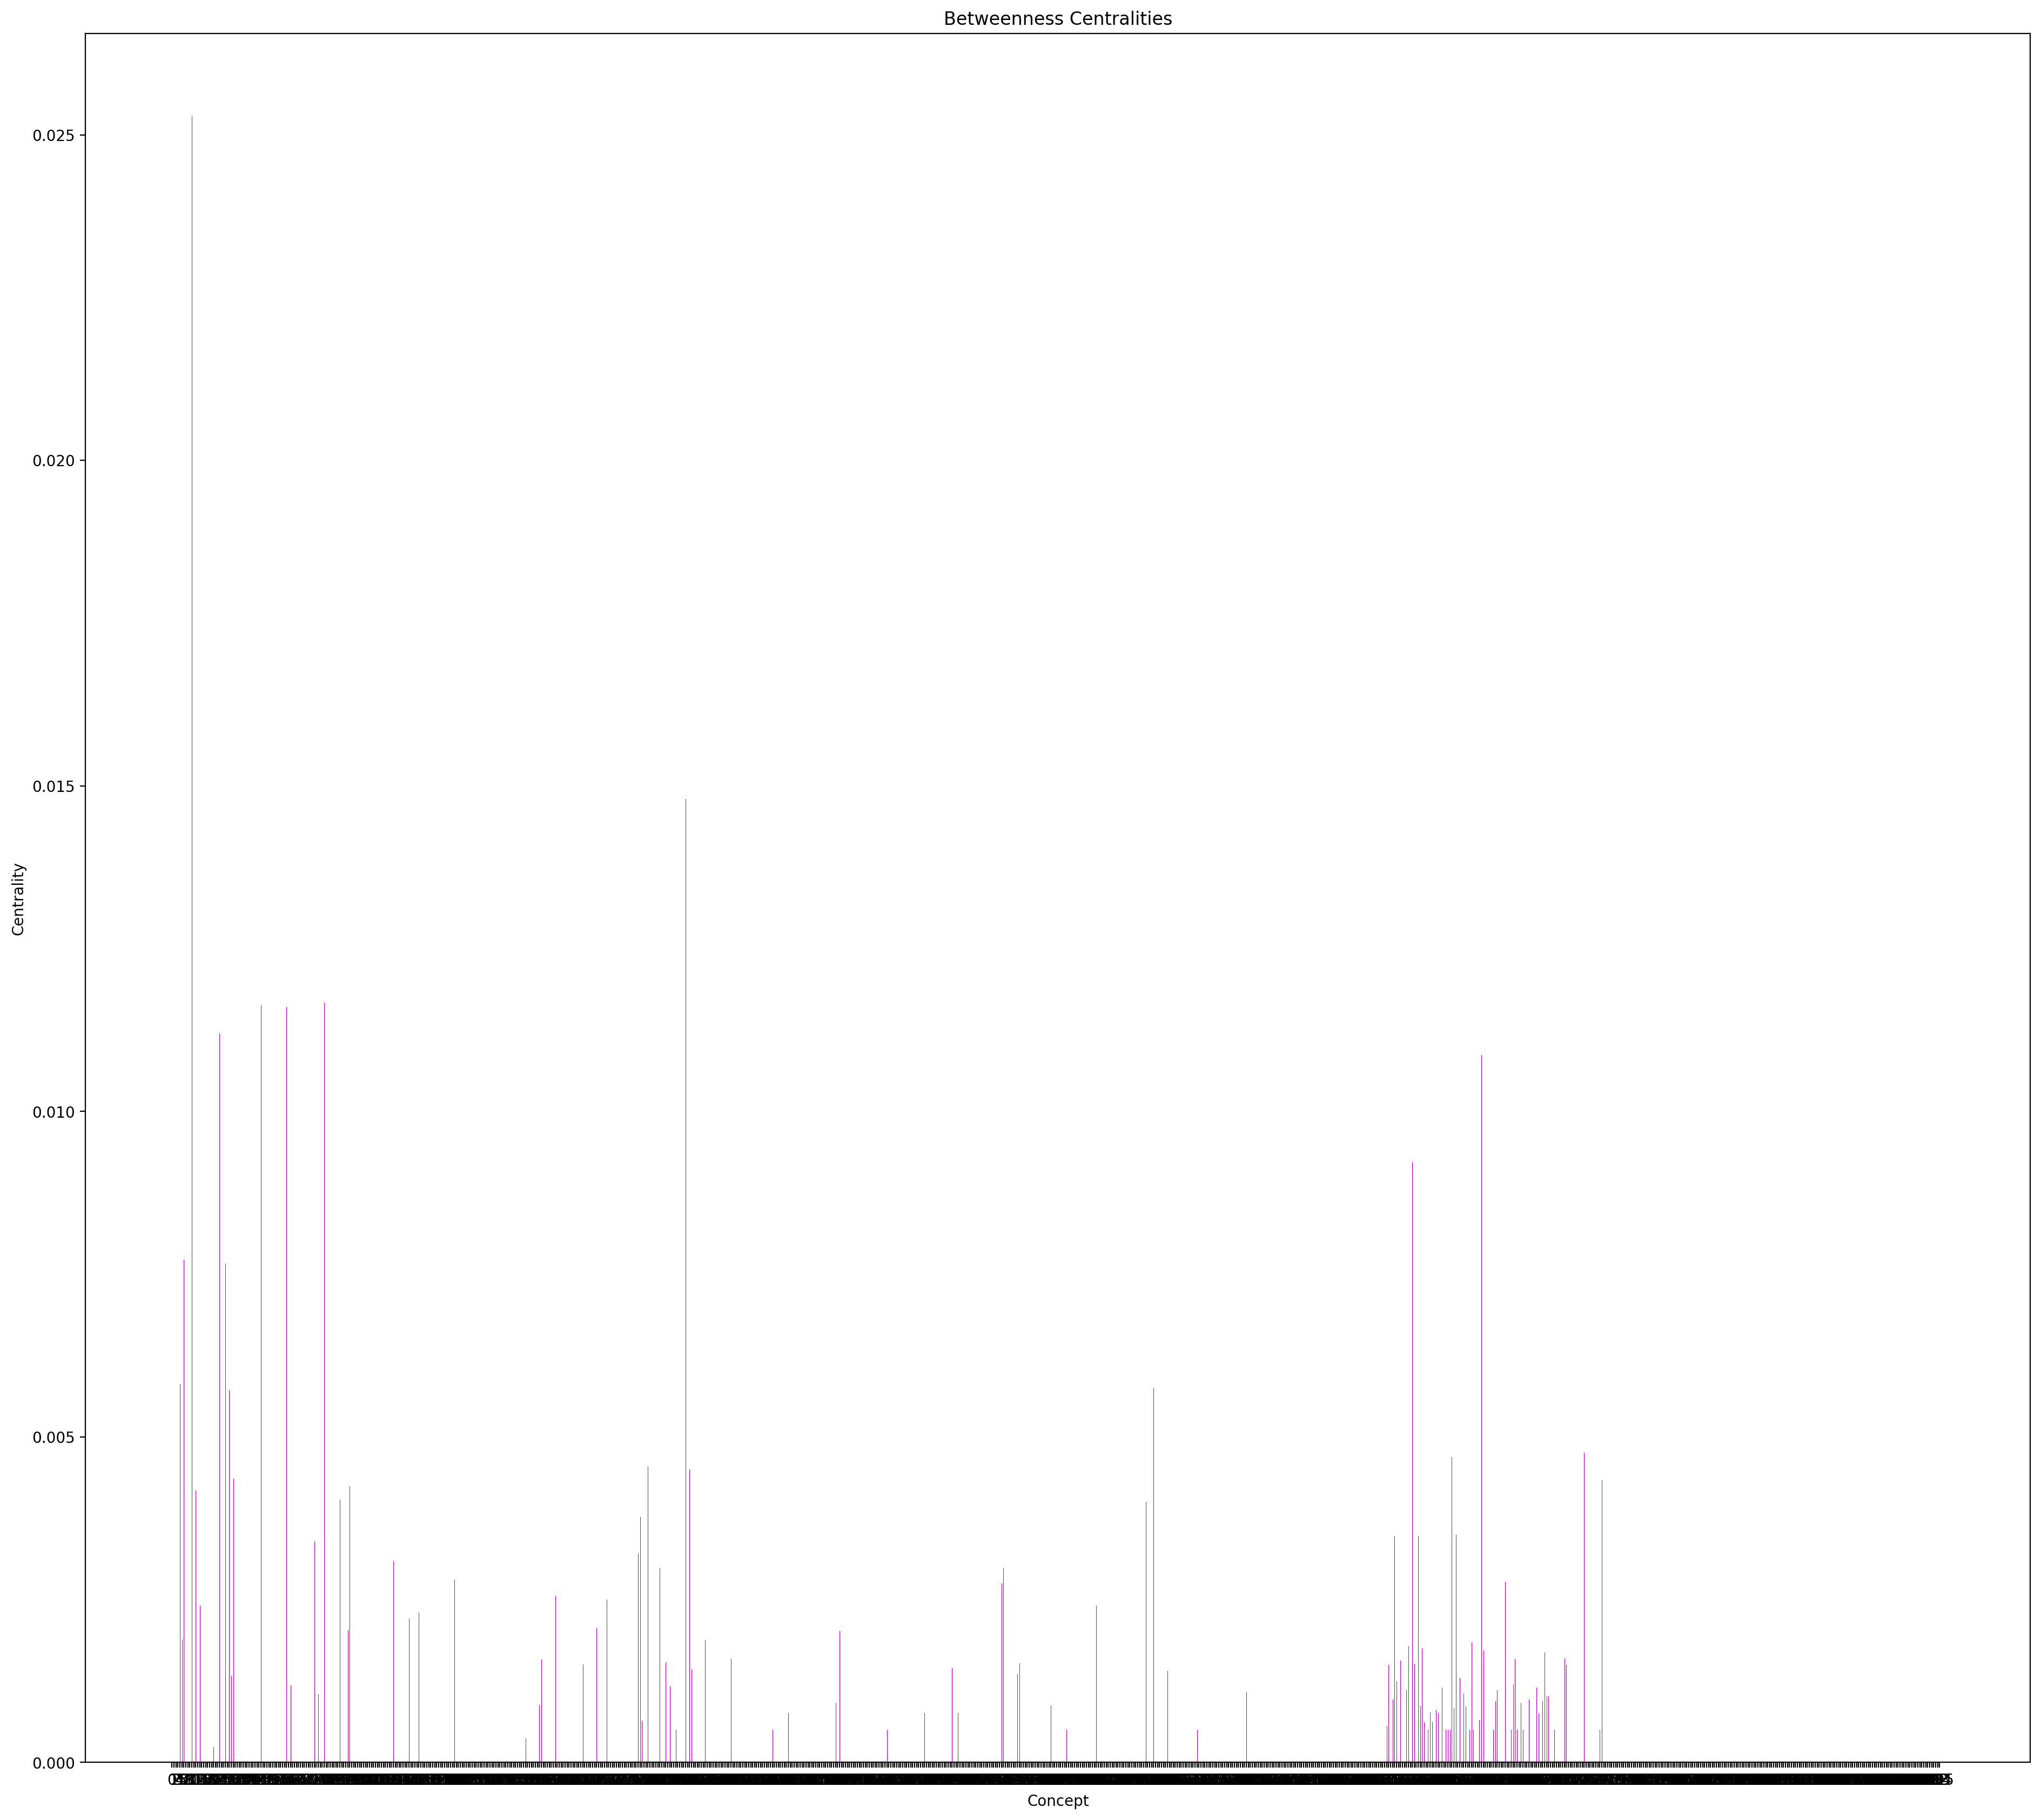

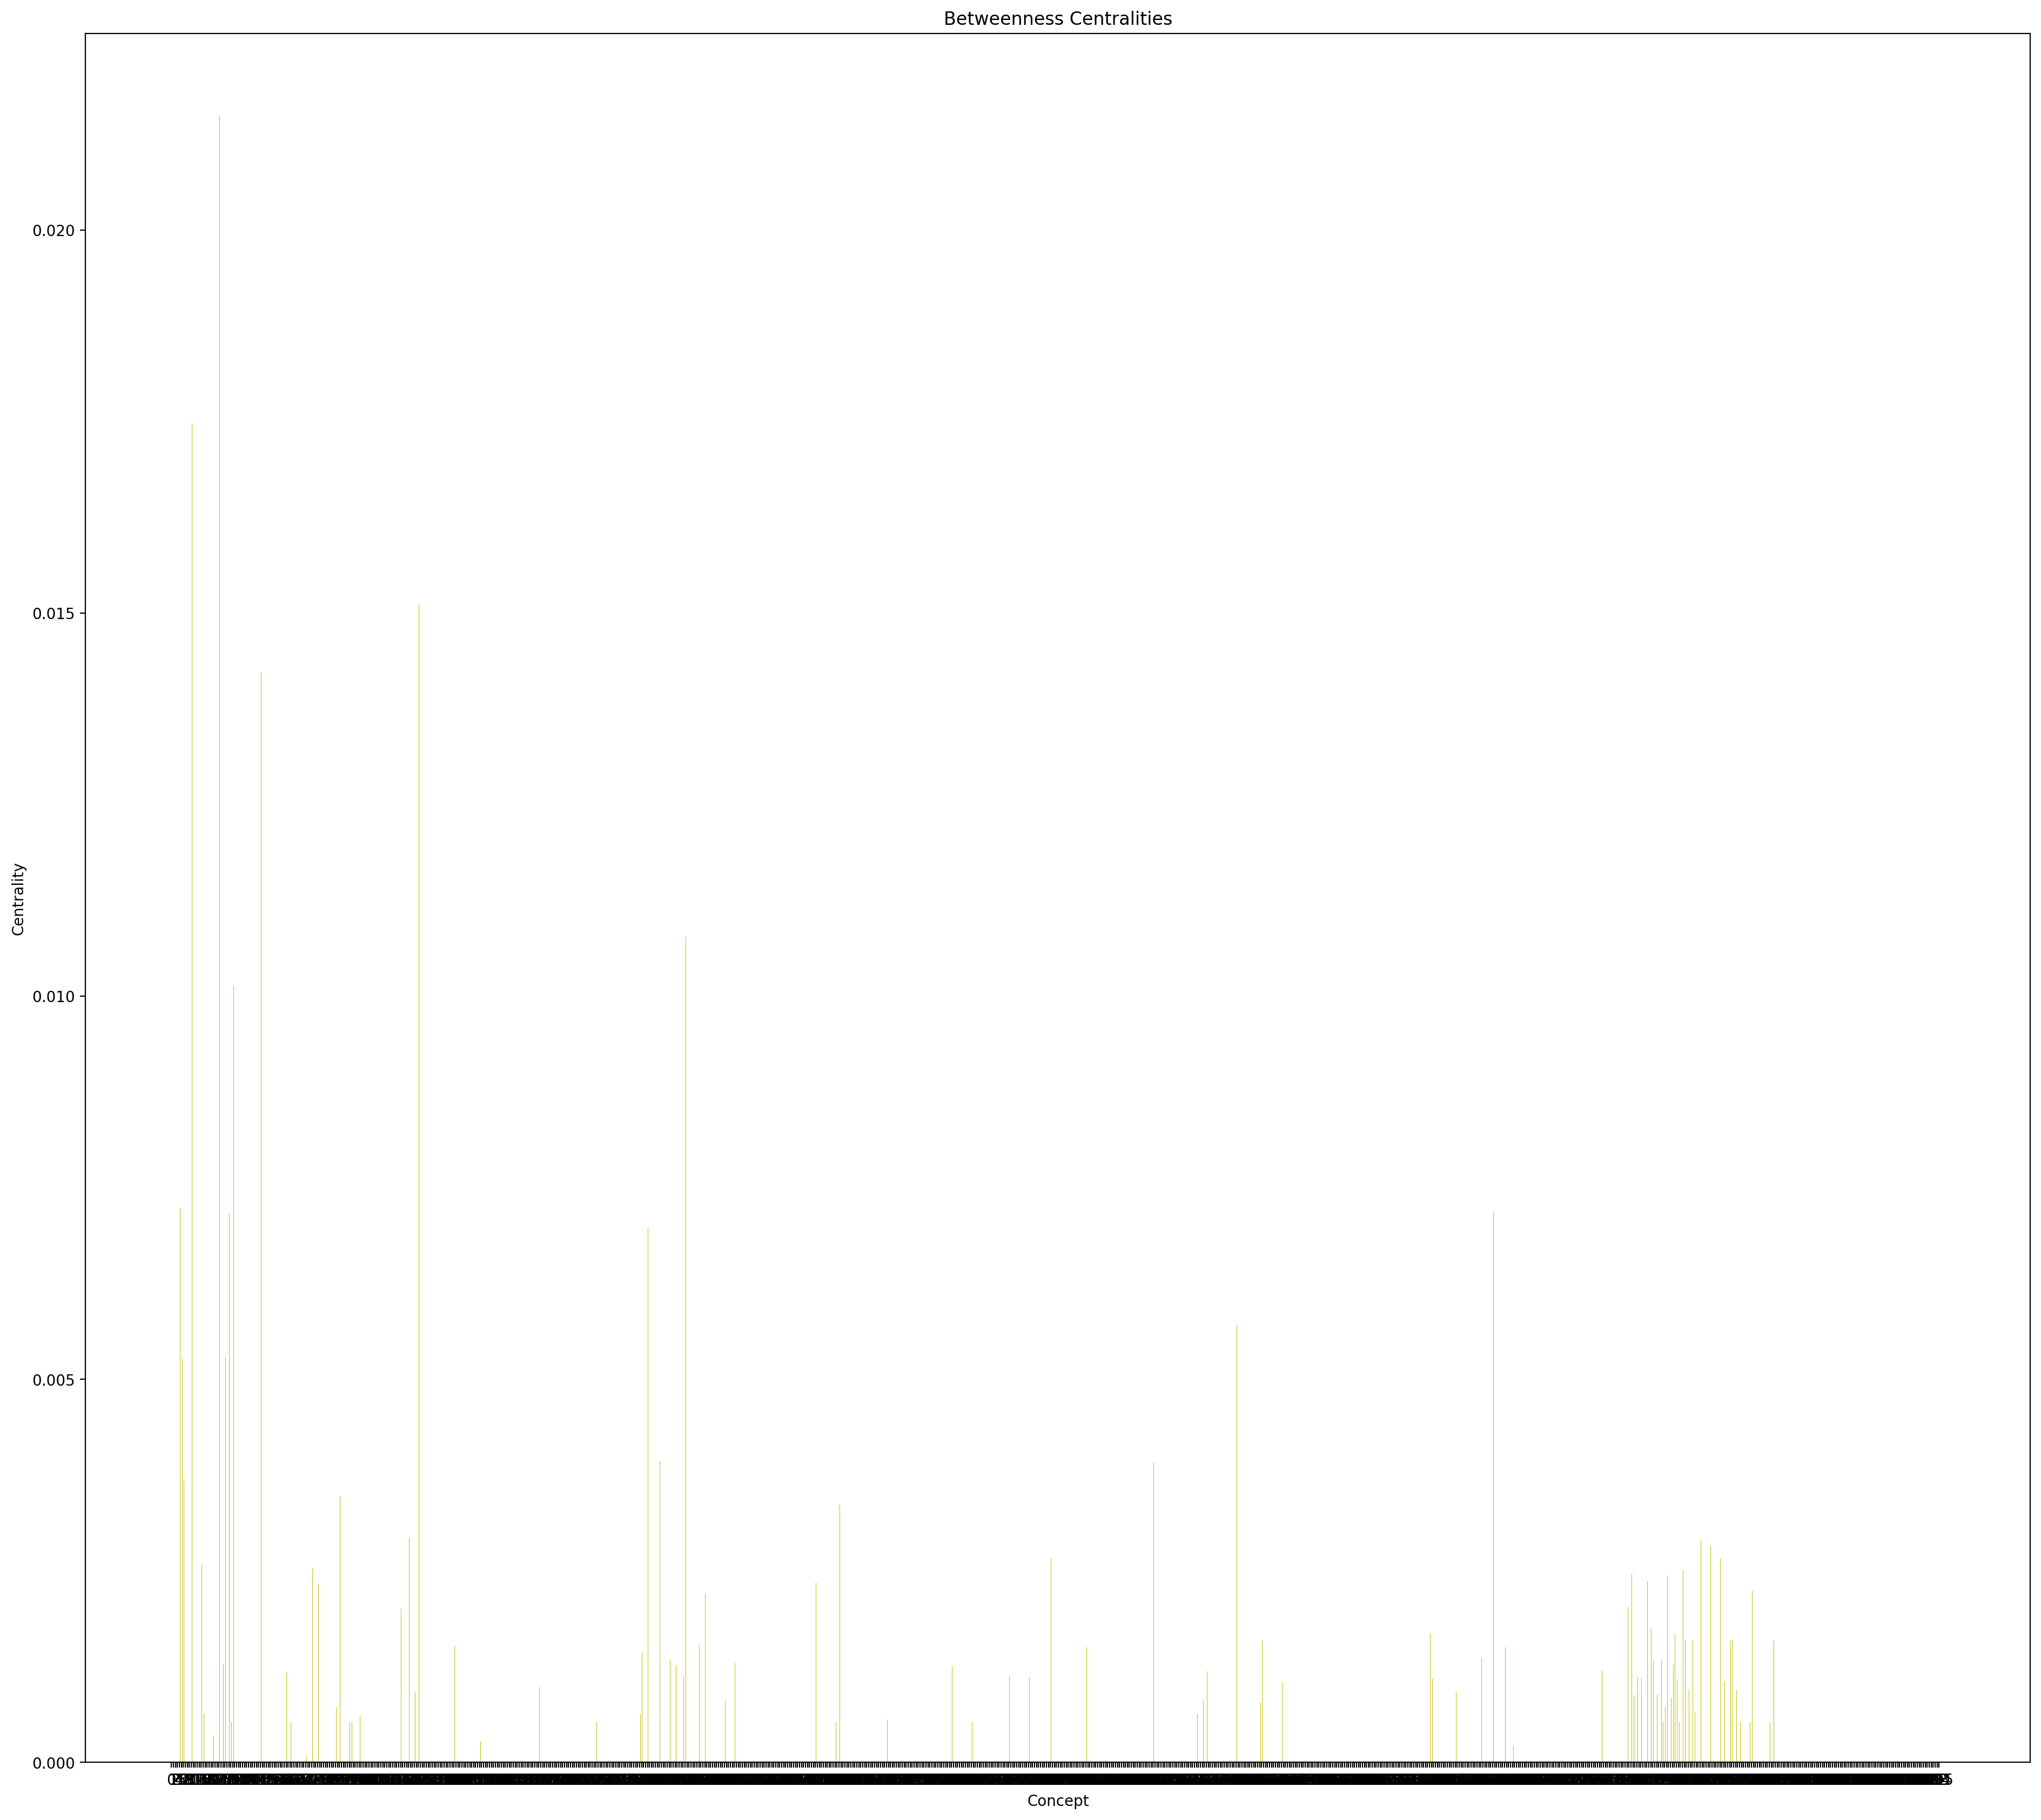

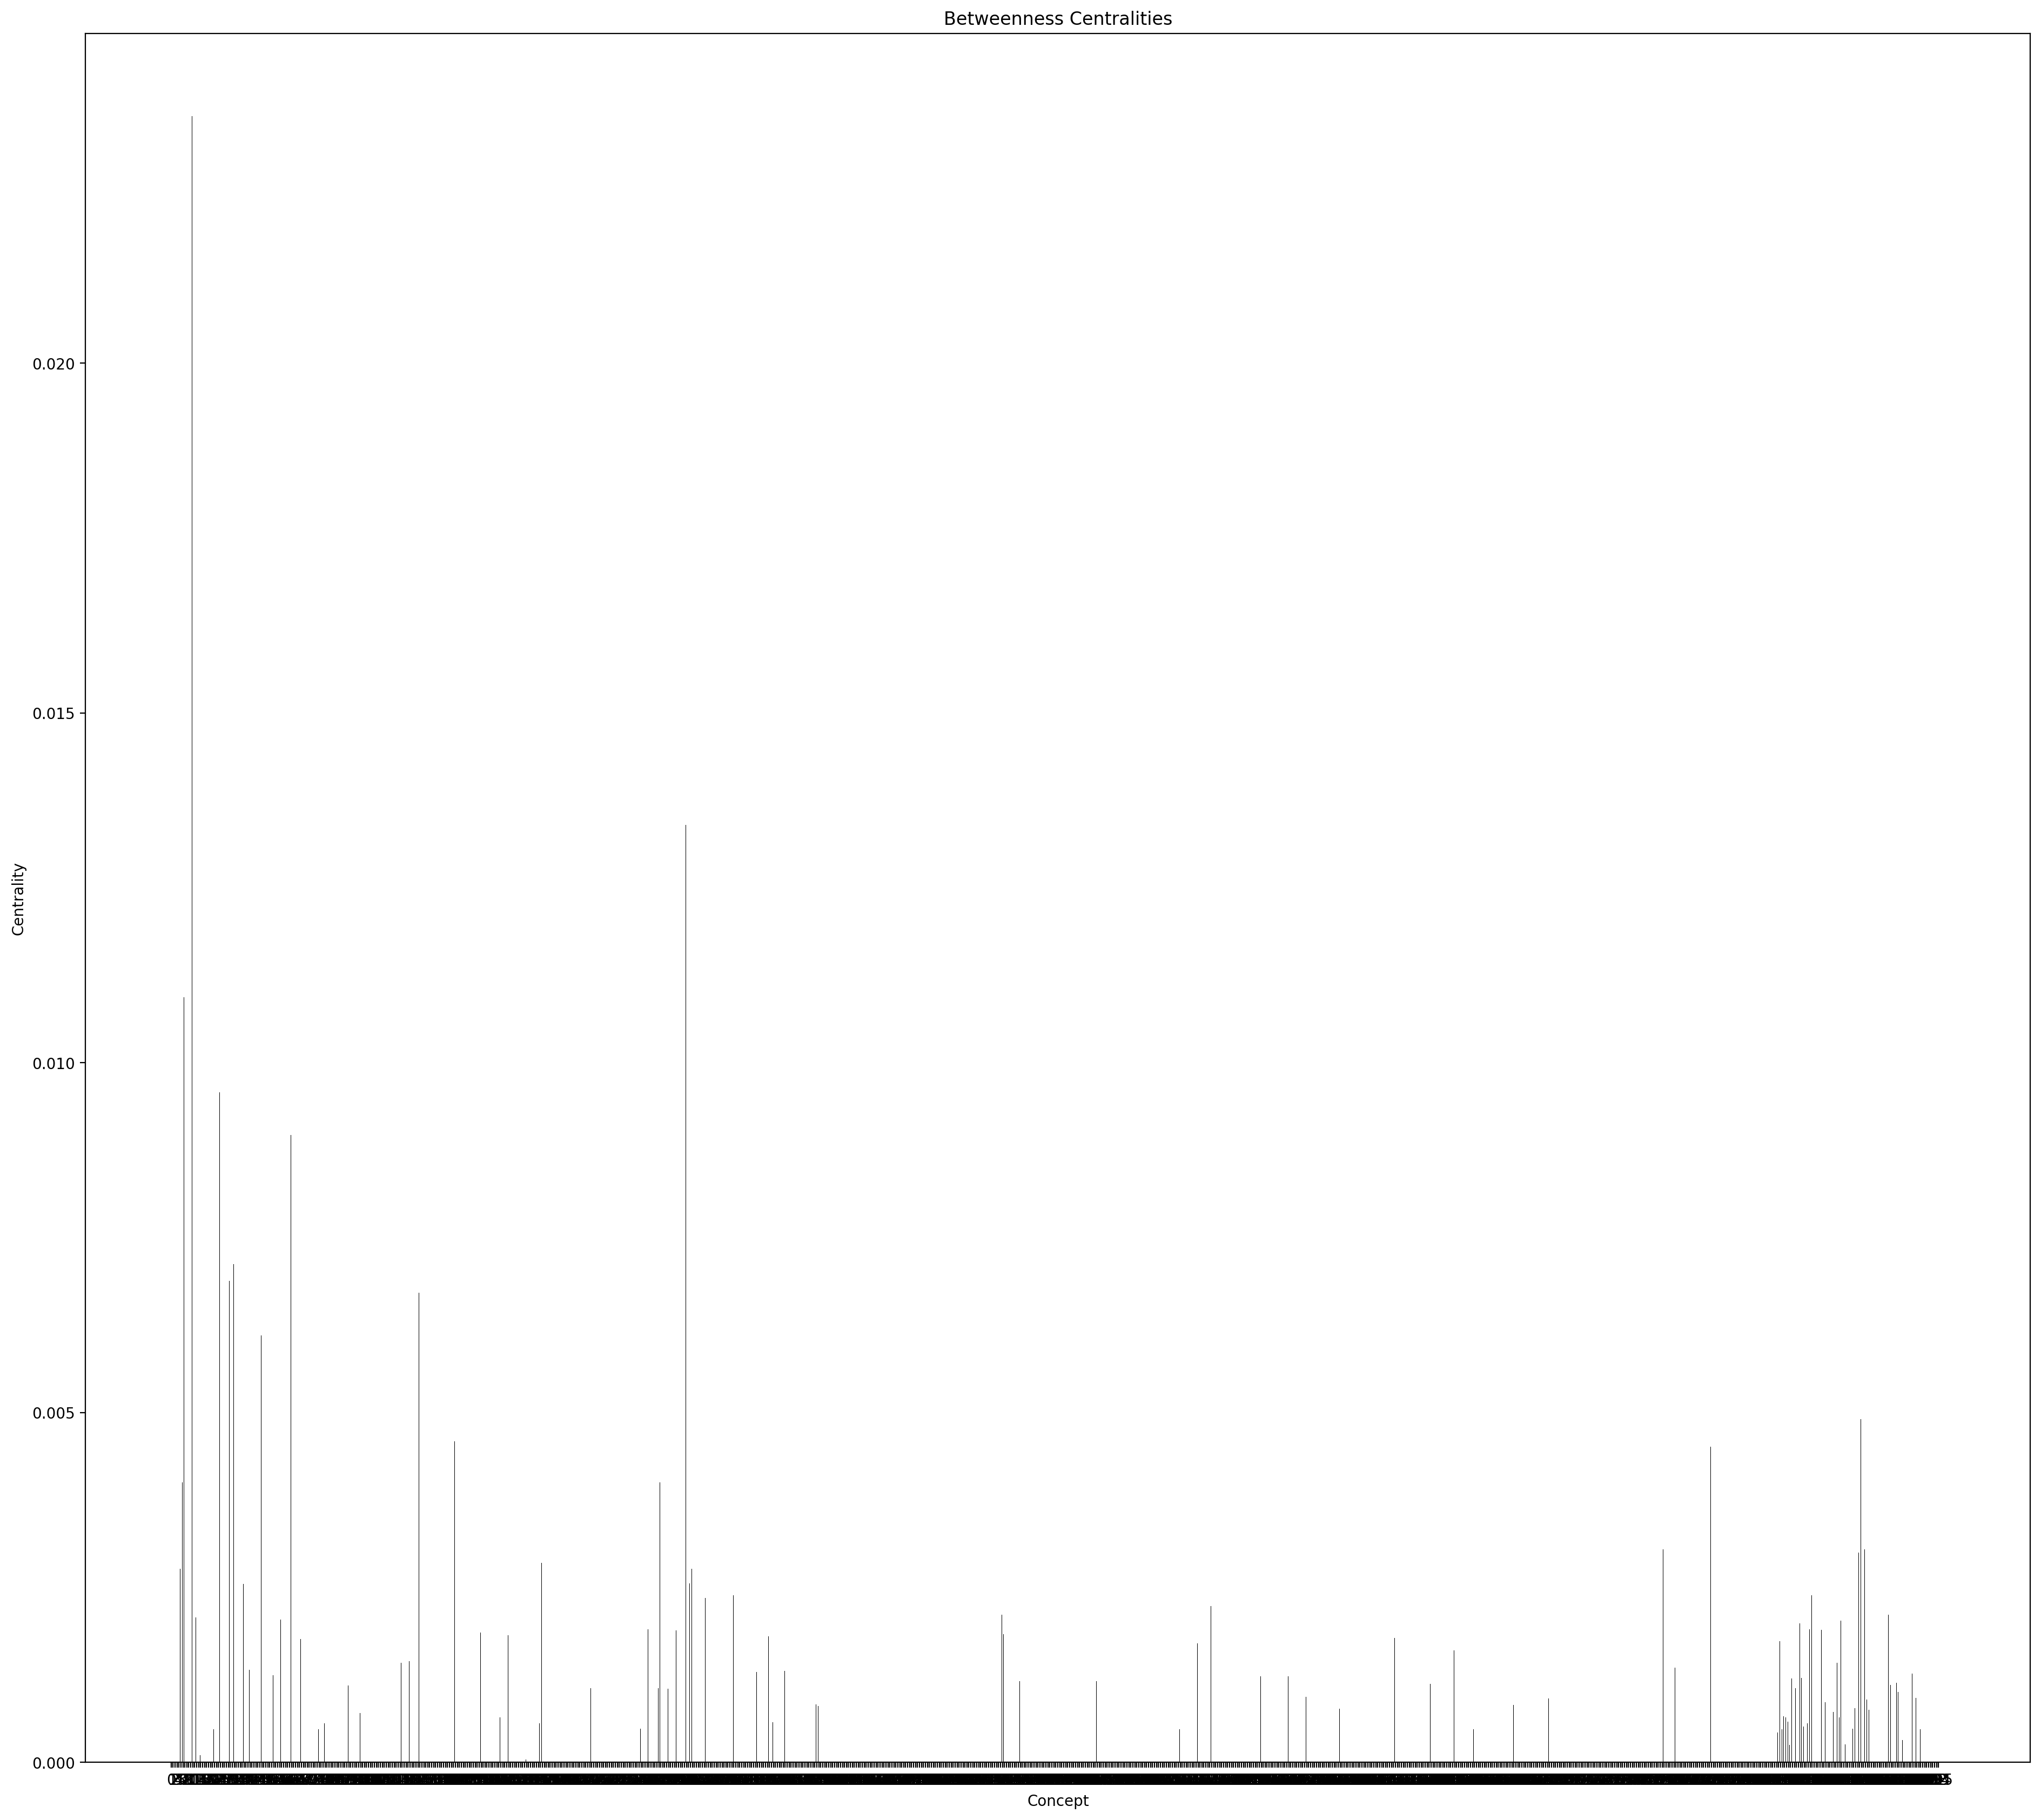

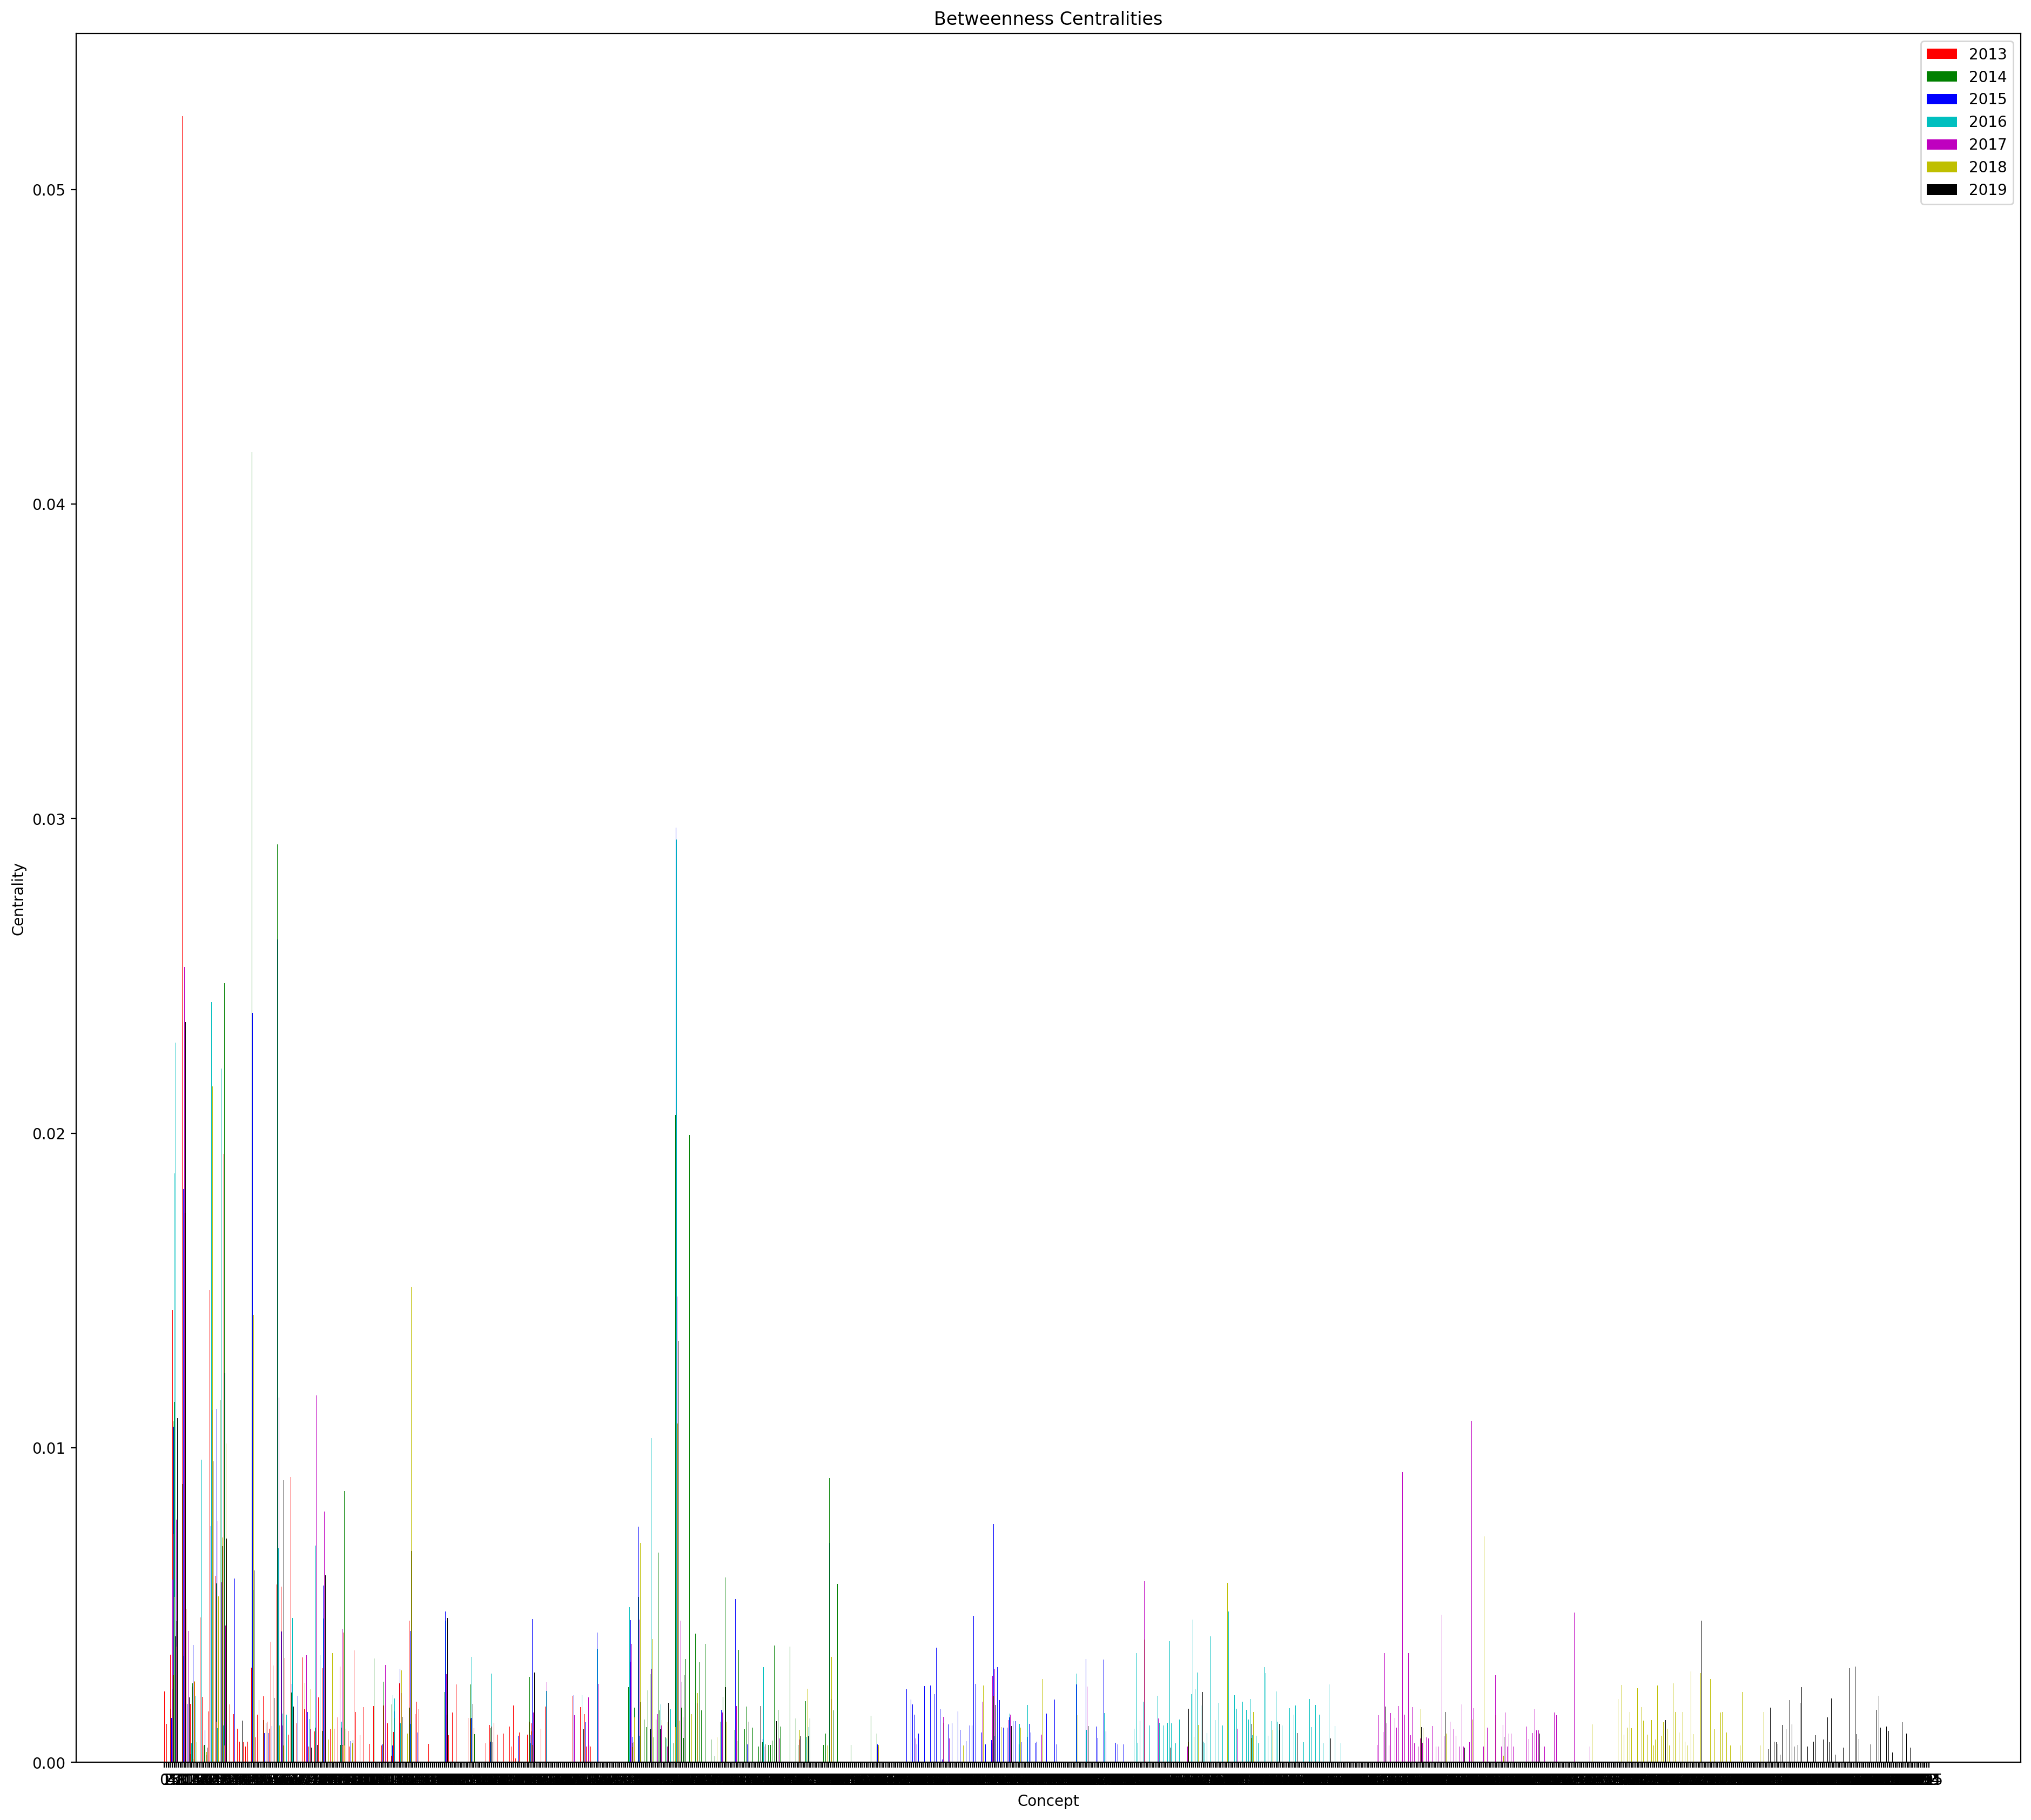

In [14]:
print('ALL BETWEENNESS CENTRALITIES')
plot_all(bet_centrality, 'Betweenness Centralities')

TOP BETWEENNESS CENTRALITIES
65
{rdflib.term.URIRef('http://local/local.owl#ontology'): [0.052330550798693524, 0.008849535830694748, 0.01821907633114668, 0.003396915624452317, 0.025287971961764927, 0.017478123883567485, 0.02353333264470631], rdflib.term.URIRef('http://local/local.owl#semantic'): [0.019342858381081723, 0.02476490916902966, 0.012372650195006423, 0.029697087123833163, 0.0043594530781469005, 0.01013153300886524, 0.007120418243396857], rdflib.term.URIRef('http://local/local.owl#rdf'): [0.015023350962028639, 0, 0.007518559196107639, 0.02415915904346472, 0.011195367019267887, 0.021488393540841238, 0.009577681309261732], rdflib.term.URIRef('http://local/local.owl#semantic_web'): [0.0143719297477797, 0.010836749389200928, 0.010671656979076613, 0.01871654554816391, 0.0018836739779266212, 0.005268025277136386, 0.004004997236266924], rdflib.term.URIRef('http://local/local.owl#query_processing'): [0.009071030931085262, 0.0022159050473510664, 0.002498066098280097, 0.0045990147510321

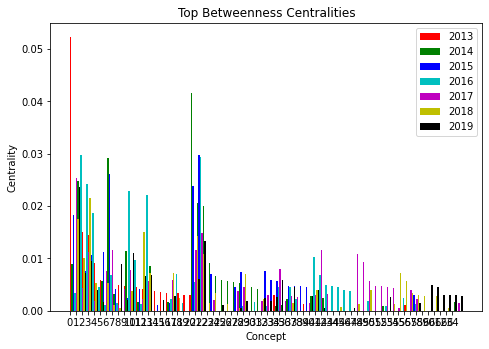

In [15]:
print('TOP BETWEENNESS CENTRALITIES')
print(len(top_bet_centrality))
print(top_bet_centrality)
plot_combined(top_bet_centrality, 'Top Betweenness Centralities')

BETWEENNESS CENTRALITY GRAPH EXAMPLES
Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2013:


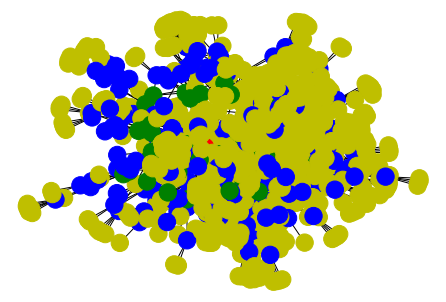

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2014:


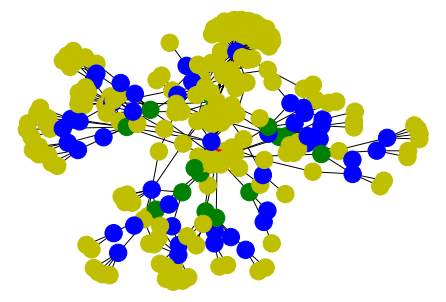

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2015:


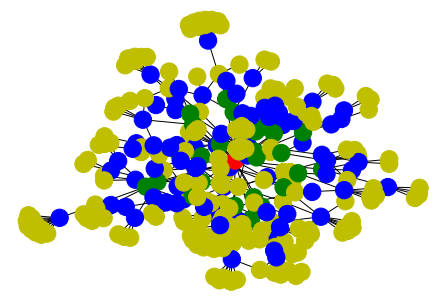

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2016:


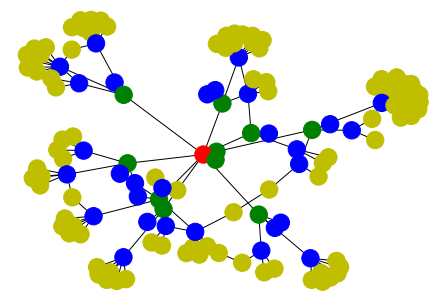

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2017:


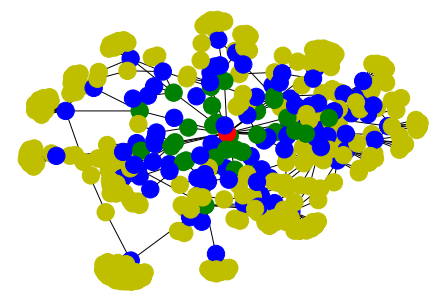

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2018:


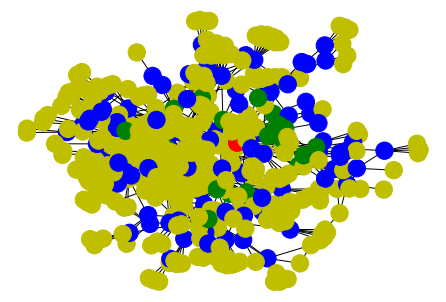

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2019:


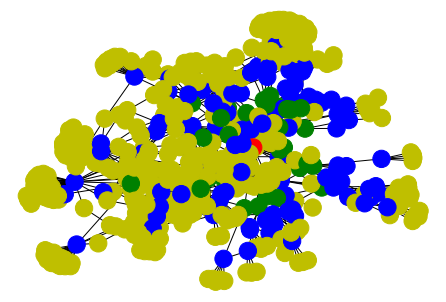

In [16]:
print('BETWEENNESS CENTRALITY GRAPH EXAMPLES')
for curr_year in nxgs.keys():
    for key in top_bet_centrality.keys():
        if key.endswith('#ontology'):
            draw_subgraph(curr_year, key, neighborhood_level=3)
            break